# Notes on condition of notebook

I have implemented a new methodology and have the algorithm set up so that either old algorithm or new algorithm can be used.  Next step is to get rid of the old approach.  

Since the new approach load data directly from dataframes, it should be possible to get rid of much of the OrderBook material, keeping only the dataframes which generate the orders.  This will require making some changes to calculate trading volume and uncleared quantities from the bk.bks, not the OrderBook itself.

The new approach has almost the same speed as the old (maybe 1-2 percent slower due to more bells and whistles).  The new approach is more configurable, so new dense or sparse books can be added.  I have not gotten the sparse and dense books to work yet.

Steps needed:

1. Redo functions to calculate volume and market statistics to use bk.bks.

2. Take legacy material out of OrderBook class, leaving behind only dataframes.

3. Take legacy material out of estimation, leaving only bk.bks.

4. Add and debug positive numbers of generic sparse orders and dense orders.  This cannot be done until legacy material taken out of optimization.

5. Return calculated market results: x, p, pa, q-x

5. Figure out how to pass market result back to dataframes in order book.


# Summary of Our Testing Strategy

After extensive testing, the results of which are not presented here, we decided to do quadratic programming calculations using the Python package Pytorch.

The quadratic programming algorithm was originally tested in several ways:

### Commercial Packages

We considered using free academic versions of commercial packages like Gurobi or Mosek but found the interface too clunky, too slow, and too hard to learn.  

One issue is that our quadratic programming problem has "easy" assumptions (diagonal positive definite quadratic matrix and box inequality constraints) but is "big" (hundreds of equality constraints and hundreds of thousands or millions of inequality constraints).

Gurobi says is does not handle sparse matrices and uses cpus rather than gpus.  Maybe this is just the interface, and we did not figure out how to use it properly.

Using Gurobi or other commercial packages is a possiblity for the future.


### Cvxopt Package

The Cvxopt package uses an interior point algorithm which works well. It has several disadvantages:

1. It uses its own sparse and dense matrix algebra language, which has its own commands (with difficult conversions back and forth to numpy/scipy).

2. It is difficult to edit code to make the algorithm work differently.  Cvxopt does offer the option to supply custom solvers. We used this option to solve the linearized system with a Cholesky decomposition of a matrix whose dimensions are the number of assets.  The Cvxopt default would try to solve an impossible gigantic system with a bigger Cholesky decomposition.

3. It does not perform calculations on a gpu.

4. It is slower than alternatives. Perhaps the sparse matrix calculations are not parallelized???

### Numpy and Scipy

A variation on the Cvxopt algorithm was implemented in Numpy and Scipy direclty (using a variation of the algorithm described by Vandenberghe (2011???). This provided more flexibility but had several shortcomings: 

1. Numpy does not seem to parallelize element-by-element operations on vectors, even though they are parallelized on matrix-matrix operations (using mkl). 

2. Scipy uses a single core for sparse matrix and vector operations. 

3. Numpy and Scipy do not use a gpu.

### OSQP

OSQP is a gradient-based optimization algorithm for quadratic programming. In general first-order methods (gradient) can achieve quick progress early in the optimization process, then slow down as they converge to equilibrium. In contrast, second order methods (based on hessians or linearizing first-oder conditions, such as interior point methods), converge very fast (quadratically) when close to the optimum. 

We downloaded the OSQP algorithm from the Stellato website and also wrote our own version based on the paper by Stellato et al. In both cases, the algorithm slowed down greatly before getting close to equilibrium prices. Even after thousands of iterations, it was not close to convergence.

For our problem, it is necessary to calculate market-clearing prices accurately, even for very poorly conditioned problems (low liquidity limit order books). This rules out OSQP.

More generally, each iteration of the interior point method is surprisingly simple. It requires mostly element-by-element calculations plus a few sparse-matrix--vector products, except for two bigger ones:  a Cholesky decomposition and the construction of the symmetric positive definite matrix to be decomposed. The number of rows and columns of this matrix is equal to the number of assets.  If the number of assets is small enough, Cholesky decomposition seems to be the best approach.

For a very large number of assets, some other way of solving a linear system will be needed, perhaps conjugate gradient method with some variations?

### Gradient method

We wrote our own bespoke gradient method and also tried various Scipy optimizers using gradient-like methods.  

None of these worked efficiently. These methods have two problems:

1. Gradient methods do not achieve enough accuracy.

2. Gradient methods do not make smart decisions about search directions because they use local rather than global information.

Second-order methods in Scipy were too hard to implement and would also suffer from Scipy not parallelizing sparse matrix-vector products.

For example, we tried using conjugate gradient method to solve linearized system.  This did not work well because we want our algorithm to deal well with poorly conditioned linear approximations. Conjugate gradient performs poorly in such cases for two reasons: it takes many iterations, and numerical error accumulates over these many iterations.

### Cupy

Cupy does calculations on a gpu.  We found it slower and less flexible than Pytorch (discussed next).

### Qpsolvers

Qpsolvers is a python package which interfaces between generic quadratic programming problems and various quadratic programming packages, including both free and commercial ones.

We could not get this package to improve our approach.


### Pytorch

Pytorch is has a language for arrays which mimics Numpy.  It has several advantages: 

1. It parallelizes element-by-element calculations on vectors, both on the cpu and gpu. 

2. It uses multiple cpu and gpu cores for other operations, including some sparse ones (???).

3. It makes it easy to do calculations on a gpu. 

4. The cpu and gpu calculations are fast. 

Pytorch has other advantages not relevant for this project. It has automatic differentiation, which is useful in optimization problems requiring complicated gradient and hessian calculations.  It also has a convenient optimization infrastructure, which is useful for neural nets and machine learning.  This optimization framework has algorithms for feeding data to optimizers efficiently.

Pytorch has disadvantages, which can be overcome: 

1. There is more overhead than Numpy for each call to the vectorized array operations. This can be reduced (or even eliminated) by compiling Pytorch code with torchscript.

2. Sparse matrix-vector products are not implemented on the cpu using Windows (This requires a work-around function described below).

After extensive testing, the details of which are not in this notebook, we discovered that:

1. On cpus, pytorch is somewhat faster than cvxopt and numpy/scipy.  Pytorch can be further speeded up by compiling with torchscript, but the speedup is typically 30 percent or less.  The cpu calculations are fastest using two cores. More than two cores slows things down. This is true with numpy and scipy as well.  This presumably results from overhead from using multiple cores combined with the sequential nature of the optimization, which limits parallel calculations.

2. On the gpu, Pytorch is about 3-5 times faster than Pytorch on the cpu (relatively faster for bigger problems with more orders).  Pytorch is faster on both element-by-element calculations and sparse matrix-matrix and matrix-vector calculations. The quadratic programming algorithm does not have many dense matrix-matrix calculations, but they are faster on the gpu than on cpu as well.

Why does pytorch work so well? Pytorch seems to have its own programming language written in C/C++. This language has optimized algorithms for array calculations. This achieves speed and also overcomes Python's global interpreter lock (GIL), making parallelization easier.  It seems to have good algorithms for the gpu. The gpu algorithms are multiple times faster than cpu algorithms for element-by-element calculations, matrix-vector products, matrix-matrix products.  Its sparse gpu calculations are multiple times faster than sparse cpu calculations (contrary to conventional wisdom???). 

It can compile code on-the-fly with torchscript. This presumably gives C/C++ speeds to algorithms.  With torchscript, pytorch also seems to optimize code on-the-fly by analyzing it as it executes, then recompiling in a manner that speeds up calculations when it detects, for example, that array sizes are constant.  This can backfire in tests which change the size of arrays every few iterations but otherwise generally works well.  It does, however, require running tests three or more times to see maximum benefits. 

What is the overall computer science strategy behind Pytorch?  We are not sure but here is what we think based on experience and reading online discussions: Two big trends are (1) lazy evaluation based on saving computation graphs, (2) automatic differentiation, (3) parallel calculations, and (4) graphics cards. In general, there is a tradeoff between compiling things in advance and waiting as late as possible into runtime to compile things.  There is also a tradeoff between compiling templates, which can become complicated, and keeping the number of types small by not using many templates. Pytorch takes the approach of having a small number of types (not using templates) and compiling as late as possible while things are running. Having a small number of types might be making it possible to optimize each type better. Indeed, torchscript sometimes seems to wait until a function has run a couple of times, then recompiles it on the fly based on how it is actually used rather than how it might theoretically be used. This allows dynamic optimizations which would not be possible otherwise.

Torchscript is a limited language,  with significant constraints on the kinds of code which it can deal with. This explains why the quadratic programming algorithm below is broken into some otherwise nonintuitive steps. For example:

1. It also does not allow very convenient printing (presumably because its main uses case does not involve debugging).  

2. It likes to type things in a manner understandable by C/C++. Thus, it like dictionaries of objects which are the same type.  This requires workarounds.

3. It does not deal with classes very well if the classes define their own functions. In the quadratic programming algorithm below, there is extensive use of functions where classes would otherwise naturally be used.  For example, it would be natural to define linear operators as classes, but this does not seem to work in pytorch.

4. It handles torch.tensor types but not numpy and scipy types.

The quadratic programming algorithm below requires Pytorch but offers several options, including:

1. Switching between cpu and gpu to compare performance and numerical results.

2. Turning torchscript (torch.jit.script) on or off. Nevertheless, even when torchscript is not used, the code is essentially the same, conforming to torchscript's simplistic requirements.

3. Switching between float32 and float64. We find that float32 is not accurate enough and sometimes gets stuck due to rounding error. But it is twice as fast as float64.

### Summary

In what follows, there are two steps:

1. Simulating an order book:  This is done in numpy since the first version was in numpy, but it could be done more quickly in pytorch.

2. Quadratic program to calculate market clearing prices and quantities:  This is done in Pytorch due to computation efficiency, especially using the gpu. 

Switching from the numpy order book to the pytorch optimization requires an interface to convert objects from one type to another.

### Note on QP inputs

Quadratic programming algorithms often use a standard form which stacks inequality constraints on top of each other.  Instead of using this approach, our current approach treats the less-than constraints separately from the greater-than constraints, mimicking the mu and lambda notation in the paper rather than the standard quadratic programming approach with stacked constraints, called say z.  We have tried the standard approach as well.  Our approach is perhaps slightly slower since it involves twice as many Python function calls to do unstacked operations. We use it because it is easier to map the approach to the paper.

## TODO List

For further experimentation, these are possible directions:

1. Set up specific matrix-multiplication functions similar to the function for generating the AQA matrix. This would make the algorithm cleaner and easier to follow.

2. Add a larger number of user-defined portfolios to the order book. This would increase the number of registered portfolios by an enormous amount.  Mina suggests generating random portolios with a random number of assets in the portfolios. This allows measuring the sensitivity of the algorithm's execution time to the number of registered portfolios. If the portfolios are truly random, PK thinks there may be plenty of liquidity for almost all assets.  This might make a conjugate gradient method more efficient for solving the underlying linear system.

3. Put the individual-asset orders and pairs-trade orders into separate arrays.  The current approach stacks them into one array but needs to sort by number of portfolios and needs to carry around an extra parameter to remember the boundary between the sorted groups.  We might have separate sparse arrays for orders with 1, 2, 3,...,k portfolios, then put any orders with a larger number of assets into a separate category.  We need to figure out two numerical boundaries: When is it efficient to use the bespoke method for generating AQA, then after that when to shift from sparse to dense calculations.  For example, we might use a bespoke method for 1, 2, or 3-portfolio orders, use sparse arrays for 4, 5,...,25-portfolios, and dense arrays for 26+ portfolios per order.  This example would involve 5 arrays: 1-portfolio orders (like now), 2-portfolio orders (like now), 3-portfolio orders (need to add), 4-25 portfolio orders (sparse arrays), 25+ portfolio orders (dense arrays).  One advantage of separate arrays for these different portfolios is that the gpu may perform calculations at the same time since calculations are asynchronous. This, of course, assumes that the gpu is not totally occupied already.  The small P1000 gpu on PK's laptop has far fewer cores than newer gpus, so newer gpus may be much faster doing these calculations.

4. Develop a strategy for dealing with many assets, say N > 2000.  This would be relevant for corporate bond markets or for markets for all ticker symbols or all stock options simultaneously.  Presumably, Cholesky decomposition, which is an $N^3$ algorithm, will not work well because it offers limited opportunities for parallelization.  Another possibility might be conjugate gradient, but it will have to deal with poorly conditioned problems associated with very low liquidity for very illiquid assets.  Perhaps preconditioning with a Cholesky decomposition or approximation to a Cholesky decomposition might work. We deal with poor conditioning by adding a small amount of exchange trading to make linear approximations better conditioned. Inside the algorithm, another approach used is to add small quantities to the diagonal of the positive defininte matrix to be decomposed.  This makes it more positive definite, so that the Cholesky decomposition does not fail. We need to investigate more carefully whether some kind of dynamic adjustment to exchange inventories and adding elements to the diagonal can improve the performance of the algorithm.  If Cholesky decomposition is not used, the same approach could be used in the context of, say, the conjugate gradient method.  This is related to the problem of handling the rare cases when the algorithm gets stuck. This seems to be related to poor conditioning of the "liquidity matrix" in the linear system which needs to be solved.  In general, it can be "fixed" by adding more exchange trading. Adding more to the diagonal may or may not work since the resulting search direction may not be good enough. 

5. Figure out a good way to warm-start an interior point method.  This seems to be a difficult or even impossible problem, based on cursory look at literature on google scholar.  In this notebook, we do have an algorithm which starts iterations using float32 (for speed), then warm-starts when switching to float64 for the final iterations (for accuracy). This sometimes does not work well, perhaps due to rounding error making the float32 approximate solution, used as a warm start the float64 calculations, too far from the central path needed for the float64 calculations.

6.  Try free versions of commercial solvers such as Gurobi or Mosek.  The key issues seem to be overcoming a slow interface (which checks the form of the problum), using sparse arrays, and using gpus.

## Environment

This notebook runs runs in an environment created with Anaconda 4.10 using the following conda commands (approximately): 

**conda create -c defaults --name my_env_name numpy scipy matplotlib pandas numba notebook threadpoolctl tqdm conda**

**conda activate my_env_name**

**conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch**

The first command installs Python from the default directory, which automatically makes numpy use *mkl*. The third command use *cudatoolkit* version 11.3, but another version should probably work as well.  

NB: Using more cores by setting GLOBAL_NUM_THREADS = "8" instead of GLOBAL_NUM_THREADS = "1" may slow things down. 
The best performance might be obtained with GLOBAL_NUM_THREADS = "2".



### Global settings

##### NOTEBOOK_USER

This setting currently only affects CSV_PATH, LATEX_PATH, and NAME_SUFFIX, but it can be used for any settings which vary across users.

##### RUN_TYPE

1. Use **RUN_TYPE = 'workstation'** to reproduce the results in the paper on a workstation.  For the results in the paper, the workstation had an AMD Ryzen Threadripper 3960X processor, 24 cores running at 3.8GHz, and 128GB of memory running at 3600MHz.  This may take 5--6 hours.

2. Use **RUN_TYPE = 'laptop'** to produce more limited results than in the paper. This may take 3 hours on a laptop at 2.0Ghz.

3. Use **RUN_TYPE = 'test'** for testing to make sure the notebook runs properly. This should take a few minutes.

##### CSV_PATH and LATEX_PATH

Set to the local directory to which simulation results and latex figures and tables are saved.

##### NSEED

Change to generate different simulations.

##### NAME_SUFFIX

This suffix is placed into output files containing simulation results.  Results will have time stamp in name anyway. This can be used to identify a group of simulations more easily, but it does not need to be changed.

##### NUM_PRINT

This is an integer defining how much output to print, corresponding to number of iterations to print output results. If zero, minimal output is printed. A good value is 1 or 2.

##### NUM_THREADS

Set to a machine specific number based on number of cores available or based on restriction to say one or two cores.

##### GLOBAL_NUM_THREADS

This does not need to be changed. It is used with *os.environ[...]* two cells below to set maximum number of threads or cores for various packages.

##### B_USE_PYTORCH = True --- This option is no longer used

This will use pytorch rather than numpy for the quadratic program.  One advantage of pytorch on the cpu is that it seems to use multiple cores is situations where numpy uses only one core, such as element-by-element operations.  But pytorch seems to have more overhead than numpy for each operation.

##### B_USE_GPU = True

If using pytorch, setting to true tells pytorch to move the quadratic program algorithm to the gpu.  This seems to speed up execution time by a factor of about 3.

Experimentation suggests that a gpu with 4 GB of memory can handle problems with about 5 million orders; a gpu with 8 GB of memory can handle 10 million orders.  If a memory overflow error stops execution, it is necessary to restart the notebook to free up the memory.

##### B_TORCHSCRIPT_JIT = False

If set to true, this tells pytorch to compile the code.  In tests, this reduces execution time by about 15 percent. A big problem is that if the number of assets or number of orders changes, then the code is recompiled.  This is a big issue when doing the 500 simulations for the figures in which every simulation has a different number of orders or assets; the computation times are very high because they include compile times which are much greater than execution times.  Therefore, I have set this to False as a default setting.


In [1]:
NOTEBOOK_USER = 'RZ'
#NOTEBOOK_USER = 'PK'
#USER = 'DM'

# RUN_TYPE = 'workstation'
# RUN_TYPE = 'laptop'
RUN_TYPE = 'test'  # for quick testing. The value can be 'test' or anything other than 'workstation' or 'laptop'

# Set paths for saving results to hard disk:
'''
CSV_PATH = ("/home/dmalec/smart_finance/outputs/csv/" if NOTEBOOK_USER == 'DM'
        else "C:/Users/akyle/ask/code/flow-trading-csv/") if NOTEBOOK_USER == 'PK' else None

LATEX_PATH = ("/home/dmalec/smart_finance/outputs/latex/" if NOTEBOOK_USER == 'DM' 
        else "C:/Users/akyle/ask/code/flow-trading-latex/") if NOTEBOOK_USER == 'PK' else None
'''
CSV_PATH = ("C:/Users/richa/Documents/energy_forward_market/outputs/csv/")
LATEX_PATH = ("C:/Users/richa/Documents/energy_forward_market/outputs/latex/")

NSEED0 = 4321  # Sets seed globally for almost all simulations.  Change to get different results.
B_SAVE_RESULTS = True if RUN_TYPE == 'workstation' else True if RUN_TYPE == 'laptop' else False
NAME_SUFFIX = NOTEBOOK_USER + RUN_TYPE  # Suffix included in file name to identify source
# NUM_PRINT: -1 means print nothing, 0 means minimal printing, 
# n > 0 means print n iterations at top and bottom, and also n subiterations
NUM_PRINT = 0 if RUN_TYPE == 'workstation' else 0 if RUN_TYPE == 'laptop' else 0 
NUM_THREADS = 2 if RUN_TYPE == 'workstation' else 4 if RUN_TYPE == 'laptop' else 2
GLOBAL_NUM_THREADS = str(NUM_THREADS)
#B_USE_PYTORCH = True  # This must be True
B_USE_GPU = True
B_TORCHSCRIPT_JIT = False


### Load packages and set environment variables

In [2]:
import os

import mkl
#mkl.set_num_threads(1)

import threadpoolctl
import functools

os.environ["OMP_NUM_THREADS"] = GLOBAL_NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = GLOBAL_NUM_THREADS
os.environ["MKL_NUM_THREADS"] = GLOBAL_NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = GLOBAL_NUM_THREADS
#os.environ["NUMEXPR_MAX_THREADS"] = GLOBAL_NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = GLOBAL_NUM_THREADS
os.environ["NUMBA_NUM_THREADS"] = GLOBAL_NUM_THREADS

import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import numba
import numba.cuda
import typing

#numba.cuda.close()

import matplotlib
import matplotlib.pyplot as plt

import datetime
import timeit
import time
import sys
#import itertools
import cProfile
import pstats 
#import io
import dataclasses
import tqdm
import pprint

#pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 50)

print(f"{sys.version=}")
print("conda environment = ", os.environ["CONDA_PREFIX"])
print(f"{np.__version__=}")
print(f"{scipy.__version__=}")
print(f"{pd.__version__=}")
print(f"{numba.__version__=}")
print(f"{matplotlib.__version__=}")

try:
    import torch
    print(f"{torch.__version__=}, {torch.version.cuda=}")
except:
    print("Pytorch not available.")

print(f"{mkl.get_max_threads()=}")

print("time stamp = ", datetime.datetime.now().strftime('%Y-%m%d-%H%M'))
tstart = time.time()



sys.version='3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'
conda environment =  C:\Users\richa\anaconda3\envs\my_env_name
np.__version__='1.26.2'
scipy.__version__='1.11.4'
pd.__version__='2.1.1'
numba.__version__='0.58.1'
matplotlib.__version__='3.8.0'
torch.__version__='2.1.1', torch.version.cuda='11.8'
mkl.get_max_threads()=2
time stamp =  2023-1204-2042


The next cell checks whether numpy is using mkl.  If it is, you should see something like *libraries = ['mkl_rt']*.

In [3]:
np.show_config()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: C:/Users/richa/anaconda3/envs/my_env_name/Library/include
    lib directory: C:/Users/richa/anaconda3/envs/my_env_name/Library/lib
    name: mkl-sdl
    openblas configuration: unknown
    pc file directory: C:\b\abs_7267ja_mqz\croot\numpy_and_numpy_base_1701295083047\_h_env\Library\lib\pkgconfig
    version: '2023.1'
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep1610466607184
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  c++:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.0
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x86_64
   

The next cell shows details of the conda environment.

In [4]:
!conda info


     active environment : base
    active env location : C:\Users\richa\anaconda3\envs\my_env_name
            shell level : 1
       user config file : C:\Users\richa\.condarc
 populated config files : C:\Users\richa\.condarc
          conda version : 23.10.0
    conda-build version : not installed
         python version : 3.11.5.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=12.3=0
                          __win=0=0
       base environment : C:\Users\richa\anaconda3\envs\my_env_name  (writable)
      conda av data dir : C:\Users\richa\anaconda3\envs\my_env_name\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
      

# Utility Functions

### Function to format printing of floats with torch.jit

torch.jit does not allow formatting of printed numbers.  This function is a workaround.

In [5]:
@torch.jit.ignore
def fprn(pre : str, x : float, fmt : str):
    print((pre + "{x:" + fmt + "}").format(x=x), end="")

@torch.jit.ignore
def fprni(pre : str, x : int):
    print((pre + "{x:}").format(x=x), end="")

@torch.jit.script
def g():
    i = 1234
    x = 5.678912345
    y = 1.23456789
    fprni("i=", i)
    fprn(", y=", y,  "1.3")
    fprn(", x=", x,  ".2e")
    print(" done")
    
g()        

i=1234, y=1.23, x=5.68e+00 done


### Function to format pandas output nicely in tables

The function shows integers without a decimal and shows floats with 3-7 digits of accuracy using exponential notation where appropriate.


In [6]:
format_pd = (lambda  x:  "{:}".format(x) if type(x) == str
             else "{:}".format(x) if (type(x)==int and abs(x) <= 10000000)
            else "{:.2e}".format(x) if abs(x) < 0.00999999
            else "{:.2e}".format(x) if abs(x) >= 1000.00 
            else "{:.4f}".format(x)) 

def test_format_pd():

    pd.options.display.float_format = format_pd

    df = pd.DataFrame({'A' : [0.00000000001234567, 0.001234567, 0.01234567, 0.00, 123.4567, 12345.67, 123456789.123],
                          'B' : [0, 'one' + 'two', 10, 100, 10**4, 10**4, 10**6]})
    display(df)
    
    # print(type(df.loc[1, 'B']) == str)
    
test_format_pd()    

,A,B
0,1.23e-11,0
1,1.23e-03,onetwo
2,0.0123,10
3,0.00e+00,100
4,123.4567,10000
5,1.23e+04,10000
6,1.23e+08,1000000


### Function to print summary information about both sparse and dense arrays ###


In [7]:
# Function to print information about arrays. For debugging.

def printa(x, s=None):  # Assumption: s == 'x'
    if s != None:
        try:
            print(s, end=", ")
        except:
            #print("no name")
            pass
    try:
        print(type(x), end=", ")
    except:
        #print("no type, ", end=", ")
        pass
    if type(x) in [list, set]:
        print("len = ", len(x), end=", ")
        for v in x:
            try:
                print("v=", type(v), end=", ")
            except:
                pass
            #print("")
            break
    if type(x) in [dict]:
        print("len = ", len(x), end=", ")
        for k in x:
            try:
                print("k=", type(k), end=", ")
                print("v=", type(x[k]), end=", ")
            except:
                pass
            #print("")
            break
    else:
        try:
            print(x.dtype, end=", ")
        except:
            #print("no dtype", end=", ")
            pass
        if np.ndim(x) == 0:
            try:
                print("shape=", x.shape, end=", ")
            except:
                pass
            try:
                print(x, end=", ")
            except:
                pass
        else:    
            try:
                print("shape=", x.shape, "=", np.prod(x.shape), end=", ")
            except:
                #print("no shape, ", end=", ")
                pass
            try:
                print("nnz=", x.size, ", fracnz=", x.size / np.prod(x.shape), end=", ")
            except:
                try:
                    print("nnz=", x.values().shape[0], ", fracnz=", x.values().shape[0] / np.prod(x.size()), end=", ")
                except:
                    #print("nnz undefined", end=", ")
                    pass
                #print("nnz undefined", end=", ")
                pass
            try:
                print("nans=", (~torch.isfinite(x.data)).sum().item(), end=", ")
                print("L1=", torch.linalg.norm(x, ord=1).item(), end=", ")
            except:
                try:
                    print("nans=", (~np.isfinite(x.data)).sum(), end=", ")
                    print("L1=", scipy.linalg.norm(x, ord=1), end=", ")
                except:
                    #print("nnz undefined", end=", ")
                    pass
            #try:
            #    if type(x) in [None, True, False, int, float, np.float32, np.float64, np.int32, np.int64, 
            #                   torch.float32, torch.float64, torch.int32, torch.int64]:
            #        print("value = ", x)
            #except:
            #    pass
    print("")
    
def test_printa():
    x = np.array([1.00, 0.00, 5.00, 0.00, np.nan])
    y = scipy.sparse.csr_matrix(x)
    z = 5.00
    c = np.array(99.99)
    none = None
    b = True
    xt = torch.tensor(55.55)
    xt2 = torch.tensor([66.66])
    xt3 = torch.tensor([[66.66, np.nan, 0.00], [66.66, np.nan, 0.00]])
    xt4 = xt3.to_sparse_csr()
    d = {'a' : 1, 'b' :2}
    v = [1.00, 2, 3]
    printa(x, 'x')
    printa(y, 'y')
    printa(z, 'z')
    printa(c, 'c')
    printa(none, 'none')
    printa(xt, 'xt')
    printa(xt2, 'xt2')
    printa(xt3, 'xt3')
    printa(xt4, 'xt4')
    printa(None, 'none')
    printa(b, 'b')
    printa(v, 'v')
    printa(d, 'd')
    
test_printa()    

x, <class 'numpy.ndarray'>, float64, shape= (5,) = 5, nnz= 5 , fracnz= 1.0, nans= 1, 
y, <class 'scipy.sparse._csr.csr_matrix'>, float64, shape= (1, 5) = 5, nnz= 3 , fracnz= 0.6, nans= 1, 
z, <class 'float'>, 5.0, 
c, <class 'numpy.ndarray'>, float64, shape= (), 99.99, 
none, <class 'NoneType'>, None, 
xt, <class 'torch.Tensor'>, torch.float32, shape= torch.Size([]), tensor(55.5500), 
xt2, <class 'torch.Tensor'>, torch.float32, shape= torch.Size([1]) = 1, 

C:\Users\richa\AppData\Local\Temp\ipykernel_32736\2028477231.py:93: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  xt4 = xt3.to_sparse_csr()


nans= 0, L1= 66.66000366210938, 
xt3, <class 'torch.Tensor'>, torch.float32, shape= torch.Size([2, 3]) = 6, nans= 2, L1= nan, 
xt4, <class 'torch.Tensor'>, torch.float32, shape= torch.Size([2, 3]) = 6, nnz= 4 , fracnz= 0.6666666666666666, 
none, <class 'NoneType'>, None, 
b, <class 'bool'>, True, 
v, <class 'list'>, len =  3, v= <class 'float'>, 
d, <class 'dict'>, len =  2, k= <class 'str'>, v= <class 'int'>, 


### Decorator function class to time function calls

In [8]:
class Ftimer:

    def __init__(self, bprint):
        self.dt = np.nan
        
    def __call__(self, bprint=True):
        def factory(func):
            @functools.wraps(func)
            def decorator(*args, **kwargs):
                t0 = time.time()
                try:
                    return func(*args, **kwargs)
                finally:
                    self.dt = time.time() - t0
                    if bprint == True:
                        print("ftimer = ", self.dt, " sec")
            return decorator
        return factory

ftimer = Ftimer(bprint=True)

@ftimer()
def test_ftimer():
    n = 10**6
    rng = np.random.default_rng()
    x = rng.standard_normal((n,))
    res = x * x
    return res

test_ftimer()
print("most recent time stored by ftimer = ", ftimer.dt)    

ftimer =  0.011522054672241211  sec
most recent time stored by ftimer =  0.011522054672241211


### Decorator to control number of threads

In [9]:
def fthrds(nthreads=NUM_THREADS, user_api='blas', bprint=True):
    def factory(func):
        @functools.wraps(func)
        def decorator(*args, **kwargs):
            with threadpoolctl.threadpool_limits(limits=nthreads, user_api=user_api): 
                try:
                    return func(*args, **kwargs)
                finally:
                    if bprint == True:
                        print("nthreads = ", nthreads, ", user_api = ", user_api)
        return decorator
    return factory

print("Should print information for both 'mkl' and 'openmp'")
pprint.pprint(threadpoolctl.threadpool_info())
print("")

#@fthrds(nthreads=1, user_api='openmp')
@fthrds(nthreads=1, user_api='blas')
def test_fthrds():
    n = 10**6
    rng = np.random.default_rng()
    x = rng.standard_normal((n,))
    res = x * x
    print("Should be approximately 1.00: ", res.sum() / float(n))

print("result of test_fthrds()")
test_fthrds()
pass

Should print information for both 'mkl' and 'openmp'
[{'filepath': 'C:\\Users\\richa\\anaconda3\\envs\\my_env_name\\Library\\bin\\mkl_rt.2.dll',
  'internal_api': 'mkl',
  'num_threads': 2,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2023.1-Product'},
 {'filepath': 'C:\\Users\\richa\\anaconda3\\envs\\my_env_name\\Library\\bin\\libiomp5md.dll',
  'internal_api': 'openmp',
  'num_threads': 2,
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'version': None}]

result of test_fthrds()
Should be approximately 1.00:  1.0003250263235859
nthreads =  1 , user_api =  blas


# Methodology for Simulating an OrderBook

We can think of the order book as consisting of three types of orders: (1) orders for individual assets, (2) orders for indexes, and (3) orders for pairs trades to buy one asset or index and sell a different asset or index. If the number of indexes is defined broadly enough, this could cover orders for arbitrary portfolios.  In our simulations, there are equally weighted and value weighted indexes for the market as a whole, for size quantiles (defined by expected dollar volume), and for industry quintiles defined by assets defined by having the same dollar volume rank modulo the number of industries.

In the base case Assumptions, we have $N = 500$ assets, $M = 100000$ orders, $num\_size\_indexes = 5$ size quantiles, and $num\_industry\_indexes = 10$ industry quantiles. This implies $(1 + 5 + 10) * 2 = 32$ index portfolios. While this is a small number of indexes compared to the theoretical number of $2^N$ different value-weighted and equally-weighted indexes, it gives a flavor for how index orders affect the way in which prices are determined. Keeping the number of indexes small also makes the algorithm for calculating prices faster, as discussed further below.

The Assumptions clas defines constants which determine the expected number and dollar size of orders for individual assets, indexes, and pairs trades. The actual number and size of orders is the result of simulations. Thus, the actual number of orders for an individual asset is the realization of a randome variabl whose mean and variance is defined in by assumptions but whose realization is random, typically approximating a Poisson process. 

Our general approach is to make assumptions about the number of orders, then use scaling assumptions to determin the relative expected dollar size of orders, with the actual dollar size determined by a scaling assumptions relating the number of orders to the size of orders. An additional scaling assumption defines expected total dollar order volume across all individual assets (excluding indexes and pairs trades).

The scaling relationship between the number and size of orders for individual assets and indexes is obtained by applying the market microstructure invariance hypothesis of Kyle and Obizhaeva (2016). Its main implication is that as dollar volume varies, the dollar size of orders varies with the $1/3$ power of the ratio of dollar volume to return variance, and the number of orders varies with the $2/3$ power of this ratio. Thus, increasing dollar volume by a factor of 8 while holding volatility constant implies that the number of orders increases by a factor of 4 and the size of orders increases by a factor of 2. This hypothesis simplifies the number of assumptions needed, since assumptions about the number of orders imply the expected size of orders, and vice versa.  It is also makes the simulation assumtions more realistic. For example, it is known that orders for thinly traded stocks are much smaller than orders for liquid stocks, and order for large liquid indexes like the market as a whole are very large indeed, approximating conformity with the invariance hypothesis. 

The value-weighted market index is assumed to have many orders, consistent with actual markets. The invariance hypothesis implies---realistically---that individual orders for the value-weighted market index have large dollar size. This implies that the overall value of the market index is heavily dependent on value-weighted market index orders.  In the current market design, the demand for indexes like the CME' S\&P 500 E-mini futures contract or actively traded ETFs like SPDR influence the prices of individual assets via index arbitrage trading. In our design, the index arbitrage is not necessary because the indexes are defined as the baskets of stocks themselves. Thus, in our design, when a trader buys the value-weighted market index, they do not obtain shares in an ETF-like asset but instead obtain different numbers of shares in $N=500$ different assets.

### Orders for Individual Stocks

Assume the total number of assets is $N = 500$, the total number of orders is $M = 100000$, and the fraction of total orders for individual assets is $frac_MA = 0.50$. Then the total number of orders for all individual assets is the nonstochastic quantity $MA := M * frac_MA = 100000 * 0.50 = 50000$. 

The expected number of orders for each asset is obtained by assuming that the expected number of orders for an asset has a lognormal distribution with (log)variance $std\_num\_orders\_asset = 1.7$. For each asset, an expected number of orders is generating by first drawing from this lognormal distribution for each stock, summing the 500 random lognormally distributed quantities, then dividing each draw from the lognormal by their sum to obtain for each asset the fraction of total orders expected for that asset. The mean of the lognormal distribution does not matter because the results add up to one after dividing by their sum. 

Next, for each of the $MA = 50000$ individual asset orders, a random variable is drawn from a multinomial distribution whose probability weights are the expected fraction of orders for each asset. The integer drawn from the multinomial distribution determines the asset to which the order applies. 

Since 1.7 is a large standard deviation, it is likely there are some assets with thousands of orders and some assets with no orders at all.  This is intentional. Our market clearing algorithm should be able to find market clearing prices and quantities for each asset, even when there are no individual asset orders for some assets.  Of course, every asset will be part of orders for a value-weighted or equally-weighted market portfolio. The prices of illiquid assets are therefore likely to be heavily influenced by orders for indexes.





# Class and function definitions related to simulations

### Assumptions Class

The Assumptions class defines default values for constants used to simulate an OrderBook.


In [10]:
@dataclasses.dataclass(frozen=False)
class Assumptions():
    """
    This class defines constants used to generate order books based on asset characteristics.
    It is simply a convenient way to put numerous related constants into one namespace.
    Descriptions of parameters are strings withe names preceded by an underscore.
    This makes it possible to construct tables describing parameters.
    """
        
    #self.DTYPE = np.float32
    dtype = np.float64

    N : int = 500 # number of assets
    _N = "Number of assets"
    M : int = 100000 # number of orders
    _M = "Number of orders"

    exch_liq_model : str = 'mina' # 'pete' = invariance, 'mina' = constant, 'eric' = proportional    
    x_exch_liq_model = "$\epsilon$ model 'mina', 'pete', 'eric'"
    exch_epsilon : dtype = 1.00e-2
    #_exch_epsilon = "$\epsilon$, exchange shares traded per dollar $\Delta p$ at $p=100$ dollars"    
    _exch_epsilon = "Slope of exchange's demand schedule (shares traded per dollar price change at \$100/share)"    
    exch_phpl_frac : dtype = 100.00
    _exch_phpl_frac = "Exchange $p_H - p_L$ as fraction of $p_0$"    

    stab_max_qv : dtype = 0.00
    _stab_max_qv = "Stabilizing order max q as multiple of v"
    stab_ph_frac : dtype = 0.70
    _stab_ph_frac =  "Fraction of $p_0$ where buying starts"
    stab_pl_frac : dtype = 0.20
    _stab_pl_frac =  "Fraction of $p_0$ where buying stops"
        
    fracMA : dtype = 0.50
    _fracMA = "Fraction of orders for individual assets"
    #fracBs : dtype = 0.10
    #_fracBs = "Fraction of orders for sparse portfolios of registered assets"
    #fracBd : dtype = 0.00
    #_fracBd = "Fraction of orders for dense portfolios of registered assets"
    subfracMX : dtype = 0.50
    _subfracMX = "Fraction of orders for indexes among orders for portfolios"    

    num_size_indexes : int = 5
    _num_size_indexes = "Number of size indexes"
    num_industry_indexes : int = 10
    _num_industry_indexes  = "Number of industry indexes"

    # Decomposition of total index trading by type of index:
    # Invariance uses this to define the number and size of orders.
    # Put a lot of trade into a single vw market index! Should have more orders than largest stock.
    
    market_index_share : dtype = 0.80
    _market_index_share = "Probability an index order is a market index order"    
    size_index_subshare : dtype = 0.50
    _size_index_subshare = "Probability a size or industry index order is a size index order"    
    ew_mkt_index_subshare : dtype = 0.0625
    _ew_mkt_index_subshare = "Probability a mkt index order is an EW mkt index order"    
    ew_size_index_subsubshare : dtype = 0.25
    _ew_size_index_subsubshare = "Probability a size index order is an EW size index order"    
    ew_industry_index_subsubshare : dtype = 0.25    
    _ew_industry_index_subsubshare = "Probability an industry index order is an EW industry index order"    

    ew_size_index_alpha : dtype = 0.00
    x_ew_size_index_alpha = "decay rate of dv share of ew mkt indexes"
    
    # Invariance suggests std_num_orders_asset = 2.5*2/3? 
    # Large value of self.std_num_orders_assets creates a few liquid assets and many illiquid assets.
    std_num_orders_asset : dtype = 1.7 
    _std_num_orders_asset = "Standard deviation of expected number of orders across assets"    

    std_order_size : dtype = 1.5  #log-standard-deviation of dollar size of asset order
    _std_order_size = "Standard deviation of order size given asset"

    dv_single_asset_orders : dtype = 1.00e+7
    _dv_single_asset_orders = "Expect total dollar volume of orders for individual assets"
        
    # Limit price on order is random variable distributed around initial price, 
    # 0.10 means + or - 10 percent of price
    std_limit_price : dtype = 0.10
    _std_limit_price = "Standard deviation of upper limit price as fraction of initial price"

    limit_bias : dtype = 0.30 # Buy order mean price reduced and sell order mean price increase by factor proportional to this value
    #_limit_bias = "Buy limits higher than sell limits"
    _limit_bias = "Mean deviation of upper limit price as fraction of initial price standard deviation"

    # Specify avg of pH - pL as fraction of asset price in basis points. 
    # For asset with p=$100.00, avg_ph_minus_pl = 1.00 means ph - pl=$0.01 = one basis point
    avg_ph_minus_pl_bp : dtype = 1.00 
    #_avg_ph_minus_pl_bp = "Avg. of $p_H - p_L$ in basis points"    
    _avg_ph_minus_pl_bp = "Mean difference between upper and lower limit prices (basis points)"    
    std_ph_minus_pl : dtype = 2.00  # log standard deviation applied to lognormal.
    #_std_ph_minus_pl = "St.dev. of $p_H - p_L$"
    _std_ph_minus_pl = "Standard deviation of difference between upper and lower limit prices"
    # Seed random number generator:
    #nseed : int = 1234
    #rng = np.random.default_rng(nseed)
        
    #vw_size_index_share : dtype = 0.08
    #ew_size_index_share : dtype = 0.02
    #vw_industry_index_share : dtype = 0.08
    #ew_industry_index_share : dtype = 0.02

    #@property # see below
    #self.vw_mkt_index_share = (1.00 - self.ew_mkt_index_share 
    #                       - self.vw_size_index_share - self.ew_size_index_share
    #                       - self.vw_industry_index_share - self.ew_industry_index_share)

    index_prices : dtype = 100.00
    _index_prices = "Mean index price"

    mean_asset_price : dtype = 100.00 # Should not matter much, can be scaled to one dollar
    _mean_asset_price = "Mean asset price"    
    std_asset_price : dtype = 0.00  # *** Should not matter much, can be almost zero
    _std_asset_price = "St.dev of mean asset prices across assets"

    # invariance_exponent determines how dollar order size varies with asset dollar volume
    # If invariance_exponent = 1/3 and dollar volume increases by factor of 8, 
    # dollar size of orders increases by factor of 2 and number of orders by factor of 4    
    invariance_exponent : dtype = 1.00 / 3.00
    _invariance_exponent = "Invariance exponent"
    # invariance_c = 2000.00 dollars is value from Kyle-Obizhaeva paper. 
    # Only effect of invariance_c here is to scale dollar volume and order size.
    # But different invariance_c changes simulation convergence tolerances since they involve dollar units.
    #invariance_c_factor : dtype = 1.00 # Constant with determines mean order size
    #_invariance_c_factor ="Invariance constant"    
    # TODO: Change invariance_m to property with exact calculation.  
    # Does not affect substance of results, but does have modest effect on scaling.
    #invariance_m : dtype = 0.60  # rescales INVARINCE_C, leave at 0.40
    #x_invariance_m = "Invariance moment ratio"    # prefix 'x' drops from table

    # Can change fraction to less than 0.50 (say 0.30?) to simulate a flash crash:
    fraction_buy_orders_asset : dtype = 0.50
    _fraction_buy_orders_asset = "Fraction buy orders for indexes and assets"    
    # fraction_buy_orders_index : dtype = 0.50 # not used since index orders are treated like asset orders
    
    Bs_M : int = 0
    _Bs_M = "Number of orders for sparse portfolios of registered assets"
    Bs_Rmin : int = 1
    _Bs_Rmin = "Minimum number of registered assets in sparse order"
    Bs_Rmax : int = 5
    _Bs_Rmax = "Maximum number of registered assets in sparse order"
    Bs_Wscale : dtype = 1.00
    _Bs_Wscale = "Scaling factor for size of sparse orders"
    Bs_std_ph_dollars : dtype = 1.00
    _Bs_std_ph_dollars = "Std dev of ph minus value based on p0 for sparse order"
    
    Bd_M : int = 0
    _Bd_M = "Number of orders for dense portfolios of registered assets"
    Bd_Rmin : int = 20
    _Bd_Rmin = "Minimum number of registered assets in dense order"
    Bd_Rmax : int = 50
    _Bd_Rmax = "Maximum number of registered assets in dense order"
    Bd_Wscale : dtype = 1.00
    _Bd_Wscale = "Scaling factor for size of dense orders"
    Bd_std_ph_dollars : dtype = 1.00
    _Bd_std_ph_dollars = "Std dev of ph minus value based on p0 for dense order"
    
    #self.tie_breaker_weight = 0.00001
    
    fracMX : dtype = dataclasses.field(init=False)
    fracM2 : dtype = dataclasses.field(init=False)
    #fracM : dtype = dataclasses.field(init=False)
    MX : int = dataclasses.field(init=False)
    M2 : int = dataclasses.field(init=False)
    MA : int = dataclasses.field(init=False)
    M0 : int = dataclasses.field(init=False) # number of order by the exchange (one buy order and one sell order for each asset)
    M0s : int = dataclasses.field(init=False) # number of order by the exchange (one buy order and one sell order for each asset)
    M1 : int = dataclasses.field(init=False)  # number of single portfolio order assets and indexes, excludes exchange
    Mall : int = dataclasses.field(init=False)  # total number of orders
    NX : int = dataclasses.field(init=False)
    NR : int = dataclasses.field(init=False)
    ew_mkt_index_share : dtype = dataclasses.field(init=False)
    vw_mkt_index_share : dtype = dataclasses.field(init=False)
    industry_index_subshare : dtype = dataclasses.field(init=False)
    ew_size_index_share : dtype = dataclasses.field(init=False)
    vw_size_index_share :  dtype = dataclasses.field(init=False)
    ew_industry_index_share :  dtype = dataclasses.field(init=False)
    vw_industry_index_share :  dtype = dataclasses.field(init=False)
    #invariance_c : dtype = dataclasses.field(init=False)
    
    def __post_init__(self):
        
        R = self.dtype

        # TODO: Need to adjust code to handle various zero values:
        assert 0.00 <= self.subfracMX and self.subfracMX <= 1.00
        # assert self.MX > 0  # It may be okay if c.MX == 0!
        assert 0.00 <= self.fracMA and self.fracMA <= 1.00
        assert self.num_size_indexes > 0
        assert self.num_industry_indexes > 0
        assert self.num_size_indexes <= self.N
        assert self.num_industry_indexes <= self.N

        assert 0.00 < self.market_index_share and self.market_index_share < 1.00
        assert 0.00 < self.size_index_subshare and self.size_index_subshare < 1.00
        assert 0.00 < self.ew_mkt_index_subshare and self.ew_mkt_index_subshare < 1.00
        assert 0.00 < self.ew_size_index_subsubshare and self.ew_size_index_subsubshare < 1.00
        assert 0.00 < self.ew_industry_index_subsubshare and self.ew_industry_index_subsubshare < 1.00
        
        self.fracMX : dtype = (1.00 - self.fracMA) * self.subfracMX
        self.fracM2 : R = (1.00 - self.fracMA) * (1.00 - self.subfracMX)
        #self.fracM : int = int(self.fracMX * self.M)
        self.MX : int = int(self.fracMX * self.M)
        self.M2 : int = int(self.fracM2 * self.M)
        self.MA : int = int(self.M - self.MX - self.M2)
        # number of order by the exchange (one buy order and one sell order for each asset):
        self.M0 : int = 2 * self.N if self.exch_epsilon != 0.00 else 0
        # number of stabilizing orders (one buy order and one sell order for each asset)        
        self.M0s : int = 2 * self.N  if self.stab_max_qv != 0.00 else 0
        # number of single portfolio order assets and indexes, excludes exchange
        self.M1 : int = self.MA + self.MX  
        # total number of orders        
        self.Mall : int = self.M0 + self.M0s + self.M1 + self.M2
        self.NX : int = 2 * (1 + self.num_size_indexes + self.num_industry_indexes)
        self.NR : int = self.N + self.NX

        self.vw_mkt_index_share : R = self.market_index_share * (1.00 - self.ew_mkt_index_subshare)
        self._vw_mkt_index_share = "Probability an index order is for the value-weighted market index"
        self.ew_mkt_index_share : R = self.market_index_share * self.ew_mkt_index_subshare
        self._ew_mkt_index_share = "Probability an index order is for the equally-weighted market index"
        self.industry_index_subshare : R = 1.00 - self.size_index_subshare
        self.vw_size_index_share : R = ((1.00 - self.market_index_share) * self.size_index_subshare
                                        * (1.00 - self.ew_size_index_subsubshare))
        self._vw_size_index_share = "Probability an index order is for a value-weighted size index"
        self.ew_size_index_share : R = ((1.00 - self.market_index_share) * self.size_index_subshare 
                                        * self.ew_size_index_subsubshare)
        self._ew_size_index_share = "Probability an index order is for an equally-weighted size index"
        self.vw_industry_index_share : R = ((1.00 - self.market_index_share) * self.industry_index_subshare 
                                            * (1.00 - self.ew_industry_index_subsubshare))
        self._vw_industry_index_share = "Probability an index order is for a value-weighted industry index"
        self.ew_industry_index_share : R = ((1.00 - self.market_index_share) * self.industry_index_subshare 
                                            * self.ew_industry_index_subsubshare)
        self._ew_industry_index_share = "Probability an index order is for an equally-weighted industry index"
        #self.invariance_c : R = 1500.00 * self.invariance_c_factor / (self.M + 1)
        
        temp = (self.vw_mkt_index_share + self.ew_mkt_index_share 
                + self.ew_size_index_share + self.vw_size_index_share
                + self.ew_industry_index_share + self.vw_industry_index_share)
        # print(f"{self.vw_mkt_index_share=}, {self.ew_mkt_index_share=}")
        # print(f"{self.ew_size_index_share=}, {self.vw_size_index_share=}")
        # print(f"{self.ew_industry_index_share=}, {self.vw_industry_index_share=}")

        assert np.isclose(temp, 1.00), "PKError: res = " + str(temp) + ". Shares should add up to one!"
        
    def make_documentation_table(self):
        d = dataclasses.asdict(self)
        vns = []
        docstrings = []
        values = []
        for k in d:
            try:
                v = getattr(self, k)
                cv = getattr(self, "_" + k)
                vns.append(k)
                docstrings.append(cv)
                values.append(v)
            except:
                pass
        df = pd.DataFrame({'Parameter' : vns, 'Base' : values, 'Description' : docstrings}, dtype=object)
        return df

    
def test_assumptions_display():    
    c = Assumptions()

    pd.options.display.float_format = format_pd
    pd.set_option('display.max_colwidth', 100)    
    #print(c.make_documentation_table())
    display(c.make_documentation_table())

test_assumptions_display()    
    

,Parameter,Base,Description
0,N,500,Number of assets
1,M,100000,Number of orders
2,exch_epsilon,0.0100,Slope of exchange's demand schedule (shares traded per dollar price change at \$100/share)
3,exch_phpl_frac,100.0000,Exchange $p_H - p_L$ as fraction of $p_0$
4,stab_max_qv,0.00e+00,Stabilizing order max q as multiple of v
5,stab_ph_frac,0.7000,Fraction of $p_0$ where buying starts
6,stab_pl_frac,0.2000,Fraction of $p_0$ where buying stops
7,fracMA,0.5000,Fraction of orders for individual assets
8,subfracMX,0.5000,Fraction of orders for indexes among orders for portfolios
9,num_size_indexes,5,Number of size indexes


The cell below converts the Assumptions() into a dictionary and displays the results.

Note that properties are not in the dictionary!

In [11]:
def test_display_Assumptions():
    c = Assumptions(**{'N' : 99, 'num_size_indexes' : 15, 'num_industry_indexes' : 3})
    display(dataclasses.asdict(c))

test_display_Assumptions()    

{'N': 99,
 'M': 100000,
 'exch_liq_model': 'mina',
 'exch_epsilon': 0.01,
 'exch_phpl_frac': 100.0,
 'stab_max_qv': 0.0,
 'stab_ph_frac': 0.7,
 'stab_pl_frac': 0.2,
 'fracMA': 0.5,
 'subfracMX': 0.5,
 'num_size_indexes': 15,
 'num_industry_indexes': 3,
 'market_index_share': 0.8,
 'size_index_subshare': 0.5,
 'ew_mkt_index_subshare': 0.0625,
 'ew_size_index_subsubshare': 0.25,
 'ew_industry_index_subsubshare': 0.25,
 'ew_size_index_alpha': 0.0,
 'std_num_orders_asset': 1.7,
 'std_order_size': 1.5,
 'dv_single_asset_orders': 10000000.0,
 'std_limit_price': 0.1,
 'limit_bias': 0.3,
 'avg_ph_minus_pl_bp': 1.0,
 'std_ph_minus_pl': 2.0,
 'index_prices': 100.0,
 'mean_asset_price': 100.0,
 'std_asset_price': 0.0,
 'invariance_exponent': 0.3333333333333333,
 'fraction_buy_orders_asset': 0.5,
 'Bs_M': 0,
 'Bs_Rmin': 1,
 'Bs_Rmax': 5,
 'Bs_Wscale': 1.0,
 'Bs_std_ph_dollars': 1.0,
 'Bd_M': 0,
 'Bd_Rmin': 20,
 'Bd_Rmax': 50,
 'Bd_Wscale': 1.0,
 'Bd_std_ph_dollars': 1.0,
 'fracMX': 0.25,
 'fracM2'

### OrderBook class

The order book class handles the manner in which Assumptions are used to generate a book of orders.

There are several different kinds of orders:

1. Orders for individual assets, generated randomly.
2. Orders for portfolios, generated randomly.
3. Orders for "pairs trades", which buy one asset or portfolio and sell another asset or portfolio in equal dollar amounts based on initial prices.
4. Modest "market making" orders placed by the exchange; such orders buy if the price is below the initial price and sell if it is aove the initial price, up to some limit defined as a large percentage price change.
5. "Stabilizing" orders which buy if prices fall a significant amount and sell if prices rise a significant amount.

In [12]:
# TODO: df_exchange and other order books might have indexes inherited from merge.  Need to drop index?


class OrderBook():
    """
    Based on Assumptions c, this class creates asset statistics (df_asset_stats and df_index_stats).
    Registered assets are either individual stocks with characteristics in df_asset_stats
    or indexes (portfolios of individual stocks with positive weights) with characteristics in df_index_stats.
    The two dataframes df_asset_stats and df_index_stats are concatented into df_stats.
    An order is for either one registered asset (buy or sell) 
    or two registered assets (pairs trade to buy one and sell another).
    The exchange is assumed to place its own orders, which are orders for single assets in df_exchange.
    Other orders for single assets (both individual stock and indexes) are in df_single_asset. 
    Orders for pairs trades are in df_pairs_trade.
    The dataframes df_exchange, df_single_asset, and df_pairs_trade contain one row for each order.
    The orders are constructed by simulation using df_asset_stats and df_index_stats, using Assumption constants c.
    Lognormal random variables are used for almost all simulated data.
    
    Given prices, the class can calculate execution quantities for each order, each registered asset, 
    and each underlying asset.
    This class does not define an algorithm calculate to market clearing prices. 
    It is contemplated that market clearing prices are 
    calculated elsewhere (CVXOPT, Gurobi, etc.) by an algorithm which clears the market for underlying assets, 
    not registered assets or orders.
    """
    def __init__(self, c=Assumptions(), nseed=123456):

        self.c = c
        self.dtype = c.dtype
        self.nseed0 = nseed
        self.rng = np.random.default_rng(nseed)
        
        self.df_asset_stats = self.make_asset_stats()
        self.df_index_stats = self.make_index_stats()
        
        self.df_stats = pd.concat([self.df_asset_stats, self.df_index_stats])
        self.df_stats['n'] = range(len(self.df_stats))
        self.df_stats['ndx'] = self.df_stats['n'].copy()
        self.df_stats = self.df_stats.set_index('ndx')
        
        # Define orders placed by the exchange itself:
        self.df_exchange = self.make_order_book_exchange()
        #assert len(self.df_exchange) == 2 * c.N, "PKError: Exchange should have2 orders for each asset!"
        
        # Define stabilizing orders:
        self.df_stabilizing = self.make_order_book_stabilizing()
        if c.stab_max_qv != 0.00:
            assert len(self.df_stabilizing) == 2 * c.N, "PKError: Should have 2 stabilizing orders for each asset!"
        else:    
            assert len(self.df_stabilizing) == 0, "PKError: Should have 0 stabilizing orders when c.stab_max_qv == 0.00!"

        # Define orders for single stocks and single indexes:
        self.df_single_asset = self.make_order_book_single_asset()
        
        # Make order books for pairs trades of asset-asset, asset-index, index-index:
        self.df_pairs_trade = self.make_order_book_pairs_trade()
        
        # Make order books for random sparse orders:
        self.df_sparse = self.make_order_book_random_sparse()
        
        # Make order books for random dense orders:
        self.df_dense = self.make_order_book_random_dense()

        # Give names to dataframes of orders:
        self.dfs_all = {'A0' : self.df_exchange, 
                             'A0s' : self.df_exchange,
                             'B1' : self.df_single_asset, 
                             'B2' : self.df_pairs_trade,
                             'Bs' : self.df_sparse, 
                             'Bd' : self.df_dense}
        
        # Pull data from order books to create numpy arrays for calculating market prices:
        
        self.q0 = self.df_exchange['q'].to_numpy()
        self.ph0 = self.df_exchange['ph'].to_numpy()
        self.pl0 = self.df_exchange['pl'].to_numpy()
        self.ph_minus_pl0 = self.df_exchange['ph_minus_pl_dollars'].to_numpy()
        self.n0 = self.df_exchange['n'].to_numpy()
        self.w0 = self.df_exchange['w'].to_numpy()
        self.order_type0 = self.df_exchange['order_type'].to_numpy()
        
        self.q0s = self.df_stabilizing['q'].to_numpy()
        self.ph0s = self.df_stabilizing['ph'].to_numpy()
        self.pl0s = self.df_stabilizing['pl'].to_numpy()
        self.ph_minus_pl0s = self.df_stabilizing['ph_minus_pl_dollars'].to_numpy()
        self.n0s = self.df_stabilizing['n'].to_numpy()
        self.w0s = self.df_stabilizing['w'].to_numpy()
        self.order_type0s = self.df_stabilizing['order_type'].to_numpy()

        self.q1 = self.df_single_asset['q'].to_numpy()
        self.ph1 = self.df_single_asset['ph'].to_numpy()
        self.pl1 = self.df_single_asset['pl'].to_numpy()
        self.ph_minus_pl1 = self.df_single_asset['ph_minus_pl_dollars'].to_numpy()
        self.n1 = self.df_single_asset['n'].to_numpy()
        self.w1 = self.df_single_asset['w'].to_numpy()
        self.order_type1 = self.df_single_asset['order_type'].to_numpy()

        self.q2 = self.df_pairs_trade['q'].to_numpy()
        self.ph2 = self.df_pairs_trade['ph'].to_numpy()
        self.pl2 = self.df_pairs_trade['pl'].to_numpy()
        self.ph_minus_pl2 = self.df_pairs_trade['ph_minus_pl_dollars'].to_numpy()
        self.n2b = self.df_pairs_trade['n_buy'].to_numpy()
        self.n2s = self.df_pairs_trade['n_sell'].to_numpy()
        self.w2b = self.df_pairs_trade['w_buy'].to_numpy()
        self.w2s = self.df_pairs_trade['w_sell'].to_numpy()
        self.order_type2 = self.df_pairs_trade['order_type'].to_numpy()

        # Consistency checks
        assert self.c.N == len(self.df_asset_stats), "PKERROR: failed consistency check"
        assert self.c.NX == len(self.df_index_stats), "PKERROR: failed consistency check"
        assert self.c.NR == len(self.df_stats), "PKERROR: failed consistency check"
        assert self.c.M0 == len(self.df_exchange), "PKERROR: failed consistency check"
        assert self.c.M0s == len(self.df_stabilizing), "PKERROR: failed consistency check"
        assert self.c.M1 == len(self.df_single_asset), "PKERROR: failed consistency check"
        assert self.c.M2 == len(self.df_pairs_trade), "PKERROR: failed consistency check"
        #print(self.c.M, self.c.M0, self.c.M1, self.c.M2)
        #print(self.c)
        assert self.c.Mall == (self.c.M0 + self.c.M0s + self.c.M1 + self.c.M2), "PKERROR: failed consistency check"
        
        self.q = np.concatenate([self.q0, self.q0s, self.q1, self.q2], axis=None)

        #assert ((self.q.shape[0] == self.c.Mall) and
        #        (self.q.ndim == 1)), "PKerror: incorrect shape = " + str(self.q.shape)

        # Define variables needed as inputs for quadratic programming problem:
        
        self.order_type = np.concatenate([self.order_type0, self.order_type0s, self.order_type1, self.order_type2], axis=None)
        
        self.ph = np.concatenate([self.ph0, self.ph0s, self.ph1, self.ph2], axis=None)
        self.pl = np.concatenate([self.pl0, self.pl0s, self.pl1, self.pl2], axis=None)
        self.ph_minus_pl = np.concatenate([self.ph_minus_pl0, self.ph_minus_pl0s, 
                                           self.ph_minus_pl1, self.ph_minus_pl2], axis=None)


        # Division by zero if self.q contains elements with zero values.
        #self.Dvec = (self.ph - self.pl) / self.q
        b_make_divide_by_zero_infinite = True
        if b_make_divide_by_zero_infinite:
            self.r_ph_minus_pl = np.empty_like(self.ph_minus_pl)
            self.r_ph_minus_pl[:] = +np.inf
            np.divide(1.00, self.ph_minus_pl, out=self.r_ph_minus_pl, where=(self.ph_minus_pl > 0.00))
            self.Dvec = np.empty_like(self.q)
            self.Dvec[:] = +np.inf
            np.divide(self.ph_minus_pl, self.q, out=self.Dvec, where=(self.q > 0.00))
        else:    
            #self.r_ph_minus_pl = 1.00 / (self.ph - self.pl)
            self.r_ph_minus_pl = 1.00 / (self.ph_minus_pl)
            self.Dvec = (self.ph_minus_pl) / self.q
            #self.Dvec = np.divide

        self.Dinvvec = 1.00 / self.Dvec
        self.Dsparse = scipy.sparse.dia_matrix((self.Dvec, [0]), shape=(self.Dvec.shape[0], self.Dvec.shape[0]))
        self.Dinvsparse = scipy.sparse.dia_matrix((self.Dinvvec, [0]), shape=(self.Dvec.shape[0], self.Dvec.shape[0]))

        self.zeros_n = np.zeros((self.c.N), dtype = c.dtype)
        self.zeros_m = np.zeros((self.c.Mall), dtype = c.dtype)
        self.zeros_2m = np.zeros((2 * self.c.Mall), dtype = c.dtype)

        w0 = scipy.sparse.csr_matrix((self.w0, (self.n0, range(self.c.M0))),
                                     shape=(self.c.NR, self.c.M0))
        w0s = scipy.sparse.csr_matrix((self.w0s, (self.n0s, range(self.c.M0s))),
                                     shape=(self.c.NR, self.c.M0s))
        w1 = scipy.sparse.csr_matrix((self.w1, (self.n1, range(self.c.M1))),
                                     shape=(self.c.NR, self.c.M1))
        w2b = scipy.sparse.csr_matrix((self.w2b, (self.n2b, range(self.c.M2))),
                                      shape=(self.c.NR, self.c.M2))
        w2s = scipy.sparse.csr_matrix((self.w2s, (self.n2s, range(self.c.M2))),
                                      shape=(self.c.NR, self.c.M2))

        w2 = w2b + w2s
        
        self.Wsparse = scipy.sparse.csr_matrix(scipy.sparse.hstack([w0, w0s, w1, w2], dtype=c.dtype))
        self.WTsparse = scipy.sparse.csr_matrix(self.Wsparse.transpose())
        
        self.Wsparse_coo = scipy.sparse.coo_matrix(self.Wsparse)
        self.WTsparse_coo = scipy.sparse.coo_matrix(self.WTsparse)
        
        self.absWsparse = self.Wsparse.__abs__()
        self.WWDinvvec = self.Wsparse.multiply(self.Wsparse).multiply(self.Dinvvec)
        self.DinvWTsparse = self.Dinvsparse.dot(self.WTsparse)

        # Definition of matrx R, which converts registered portfolios to assets:
        # R_mat = [I_N, RX_mat], where RX_mat is N x RX matrix defining registered portfolio (index) weights.
        # RX_mat can potentially be implemented as a sparse matrix, but here we make it dense:
        # vw indexes have weights proportional to asset dollar volume dv for assets in the portfolio
        # ew indexes have equal weights for assets in the portfolio
        # Assets in the portfolios are defined by start, stop, stride.
        # In more general application, users would define their own registered portfolios, which could be arbitrary.
        
        self.RX_mat = np.zeros((self.c.N, self.c.NX), dtype=self.dtype)
        bool_vw = self.df_index_stats['ticker'].str[0:3].str.contains('vw_')
        start = self.df_index_stats['asset_start'].to_numpy()
        stop = self.df_index_stats['asset_stop'].to_numpy()
        stride = self.df_index_stats['asset_stride'].to_numpy()
        dv = self.df_asset_stats['dv'].to_numpy()

        #with np.printoptions(precision=3):
        #    printa(self.RX_mat, "self.RX_mat")
        #    printa(dv, "dv")
        #    print(dv)
        #    r = 2
        #    print(start[r], stop[r], stride[r])
        #    print(dv[start[r]:stop[r]:stride[r]])

        for r in range(self.c.NX):
            if bool_vw[r] == True:
                self.RX_mat[start[r]:stop[r]:stride[r], r] = dv[start[r]:stop[r]:stride[r]] 
            else:
                self.RX_mat[start[r]:stop[r]:stride[r], r] = 1.00 
        # Scale weights in each column to sum to one based on sums of dollar volumes or ones in each column:
        self.RX_mat = self.RX_mat / self.RX_mat.sum(axis=0).reshape(1,-1)
        
        #printa(self.RX_mat.T, "self.RX_mat.T")
        #print(self.RX_mat.T)
        
        # TODO: Adjust for prices not equal to one here:!!!!
        p0assetinv = 1.00 / self.df_asset_stats['p0'].to_numpy().reshape(c.N, 1)
        p0index = self.df_index_stats['p0'].to_numpy().reshape(1, c.NX)
        self.RX_mat = p0assetinv * self.RX_mat * p0index  

        assert self.RX_mat.min() >= 0.00, "PKError: Every element of self.RX_mat should be nonnegative!"
        
        #self.RXT_mat = self.RX_mat.T.copy()
        self.RXT_mat = np.array(self.RX_mat.T.copy())

        self.I_N = np.zeros((self.c.N, self.c.N), dtype=self.dtype)
        for i in range(self.c.N):
            self.I_N[i,i] = 1.00
        self.R_mat = np.hstack([self.I_N, self.RX_mat])
        
        self.pbenchmark = self.df_asset_stats['p0'].to_numpy()
        self.pa = self.pbenchmark
        self.x = np.zeros_like(self.q)

        self.net_dollar_demand_norm = 99999999999.9999
        
        qpinputs = {}
        qpinputs['dtype'] = self.Dvec.dtype   # typically np.float64
        qpinputs['m'] = self.Dvec.shape[0]   # number of orders, I in paper
        qpinputs['n'] = self.pa.shape[0]   # number of assets, N in paper
        qpinputs['k'] = self.RX_mat.shape[1]   # number of registered portfolios
        dtype = qpinputs['dtype']
        m = qpinputs['m']
        n = qpinputs['n']
        # Sigma = scipy.sparse.eye(n, dtype=dtype)
        I_n = scipy.sparse.eye(n, dtype=dtype)
        qpinputs['RX'] = np.ascontiguousarray(self.RX_mat)  # registered portfolio weights (shares / portfolio unit)
        qpinputs['RXs'] = scipy.sparse.csr_matrix(qpinputs['RX'])  #  also registered portfolio weights (shares / portfolio unit)
        Rmat = np.concatenate([I_n.toarray(), self.RX_mat], axis=1)
        qpinputs['Rs'] = scipy.sparse.csr_matrix(Rmat) # registered portfolio weights (shares per portfolio unit, ones for individual assets)
        qpinputs['Dsmat'] = scipy.sparse.diags(self.Dvec) # slope of order (dollars / portfolio unit^2) like lambda in Kyle-1985

        qpinputs['Ws'] = self.Wsparse # subportfolio weight in order (asset units, +=buy, -=sell), order has one or two nonzero weights
        qpinputs['Wst'] = self.WTsparse # subportfolio weight in order (asset units, +=buy, -=sell), order has one or two nonzero weights

        qpinputs['Wcoo'] = self.Wsparse_coo # subportfolio weight in order (asset units, +=buy, -=sell), order has one or two nonzero weights
        qpinputs['Wtcoo'] = self.WTsparse_coo # subportfolio weight in order (asset units, +=buy, -=sell), order has one or two nonzero weights

        qpinputs['Gs'] = scipy.sparse.csr_matrix(scipy.sparse.vstack([scipy.sparse.diags(-np.ones((m,))),
                                                                    scipy.sparse.diags( np.ones((m,)))]))

        #qpinputs['c'] = -self.ph # negative of limit price (dollars / portfolio unit)
        #qpinputs['b'] = np.zeros((n,), dtype=dtype) # quantity to clear market (shares)
        #qpinputs['h'] = np.hstack([np.zeros_like(self.q), self.q]) # order quantity limits (portfolio units)
        #qpinputs['p0'] = self.pbenchmark
        #qpinputs['q'] = self.q

        qpinputs['ph'] = self.ph # negative of limit price (dollars / portfolio unit)
        qpinputs['mkt_clear'] = np.zeros((n,), dtype=dtype) # quantity to clear market (shares)
        qpinputs['xzero'] = np.zeros_like(self.q)
        qpinputs['q'] = self.q
        qpinputs['p0'] = self.pbenchmark
        
        qpinputs['order_type'] = self.order_type
        qpinputs['b_exch_order'] = (self.order_type == 0)
        qpinputs['b_stab_order'] = (self.order_type == -1)
        qpinputs['b_pair_order'] = (self.order_type == 2)
        
        qpinputs['b_q_constraint'] = np.hstack([~(self.q == self.q), self.q == self.q])
        #qpinputs['b_q_constr_order_type'] = np.hstack([np.zeros_like(self.order_type), self.order_type])
        qpinputs['constr_order_type'] = np.hstack([self.order_type, self.order_type])

        qpinputs['b_exch_q_constraint'] = (qpinputs['b_q_constraint'] & (qpinputs['constr_order_type'] == 0))
        qpinputs['b_stab_q_constraint'] = (qpinputs['b_q_constraint'] & (qpinputs['constr_order_type'] == -1))
        
        self.qpinputs = qpinputs # inputs to quadratic program
        
        # Do this when estimation options known: torch dtype and device not known yet!
        #self.initialize_torch_dictionaries_(dtype, device)  
    
        
    def update_demand(self, pa):
        """
        self.update_demand(prices) calculates the excess demand vector self.net_dollar_demand 
        given a price vector.  It also calculates many other statistics.
        FIXED? The style of this function is to "hardwire" what could otherwise be sparse matrix calculations.
        This function can be used as a template for defining bespoke sparse operations for orders.
        """
        
        self.pa = pa.copy()
        
        tempr = np.zeros(self.c.NR, dtype=self.dtype)
        tempr[:self.c.N] += self.pa
        tempr[self.c.N:] += self.RXT_mat @ self.pa
        
        self.pm = np.zeros(self.c.Mall, dtype=self.dtype)
        self.pm[self.order_type == 0] = tempr[self.n0] * self.w0
        self.pm[self.order_type == -1] = tempr[self.n0s] * self.w0s
        self.pm[self.order_type == 1] = tempr[self.n1] * self.w1
        self.pm[self.order_type == 2] =  tempr[self.n2b] * self.w2b
        self.pm[self.order_type == 2] += tempr[self.n2s] * self.w2s
        
        #self.pm = np.zeros(self.c.Mall, dtype=self.dtype)
        #self.pm[:self.c.M0] = tempr[self.n0] * self.w0
        #self.pm[self.c.M0 : self.c.M0 + self.c.M1] = tempr[self.n1] * self.w1
        #self.pm[self.c.M0 + self.c.M1 :] =  tempr[self.n2b] * self.w2b
        #self.pm[self.c.M0 + self.c.M1 :] += tempr[self.n2s] * self.w2s

        self.z = (self.ph - self.pm) * self.r_ph_minus_pl
        #self.fvec, self.Fvec = F_and_fr_jit(self.z, eps=0.0000001, factor=1.00)
        self.Fvec = np.maximum(np.minimum(self.z, 1.00), 0.00)
        self.x = self.q * self.Fvec
        
        tempr[:] = (  np.bincount(self.n0, self.w0 * self.x[self.order_type == 0], minlength=self.c.NR)
                        + np.bincount(self.n0s, self.w0s * self.x[self.order_type == -1], minlength=self.c.NR)
                        + np.bincount(self.n1, self.w1 * self.x[self.order_type == 1], minlength=self.c.NR)
                        + np.bincount(self.n2b, self.w2b * self.x[self.order_type == 2], minlength=self.c.NR)
                        + np.bincount(self.n2s, self.w2s * self.x[self.order_type == 2], minlength=self.c.NR))

        self.net_demand = np.zeros(self.c.N, dtype=self.dtype)

        self.net_demand[:] = tempr[:self.c.N] + self.RX_mat @ tempr[self.c.N:]
        
        #tempr[:] = (  np.bincount(self.n0, self.w0 * self.x[:self.c.M0], minlength=self.c.NR)
        #                + np.bincount(self.n1, self.w1 * self.x[self.c.M0 : self.c.M0 + self.c.M1], minlength=self.c.NR)
        #                + np.bincount(self.n2b, self.w2b * self.x[self.c.M0 + self.c.M1 :], minlength=self.c.NR)
        #                + np.bincount(self.n2s, self.w2s * self.x[self.c.M0 + self.c.M1 :], minlength=self.c.NR))

        #self.net_demand = np.zeros(self.c.N, dtype=self.dtype)

        #self.net_demand[:] = tempr[:self.c.N] + self.RX_mat @ tempr[self.c.N:]

        self.net_dollar_demand = self.pbenchmark * self.net_demand
        self.net_dollar_demand_norm = np.linalg.norm(self.net_dollar_demand, 2)
        
        return self.net_dollar_demand_norm

    def calculate_volume_stats(self):
        """
        This function calculates statistics based on trading volume.  
        It is assumed that update_demand(...) has already been called.
        The important statistic self.uncleared_share gives the fraction of total dollar volume which
        did not clear. The message msg summarized volume statistics.
        The uncleared volume share is printed dollars per million (i.e., multiplied by 10**6), so
        unclpM = 1.00 means one dollar per 1,000,000 dollars of volume did not clear.
        """
        #c = self.c
        
        self.dollar_volume = (self.pbenchmark * (self.R_mat @ self.absWsparse.dot(self.x))).sum()
        self.exchange_dollar_volume = (self.pbenchmark * (self.R_mat @ 
                     self.absWsparse[:, self.order_type == 0].dot(self.x[self.order_type == 0]))).sum()
        self.stabilizing_dollar_volume = (self.pbenchmark * (self.R_mat @ 
                     self.absWsparse[:, self.order_type == -1].dot(self.x[self.order_type == -1]))).sum()
        self.single_asset_dollar_volume =  (self.pbenchmark * (self.R_mat @ 
                      self.absWsparse[:, self.order_type == 1].dot(self.x[self.order_type == 1]))).sum()
        self.pairs_trade_dollar_volume =  (self.pbenchmark * (self.R_mat @ 
                        self.absWsparse[:, self.order_type == 2].dot(self.x[self.order_type == 2]))).sum()
        self.net_dollar_volume_vec = self.pbenchmark * np.abs(self.R_mat @ self.Wsparse.dot(self.x))
        self.uncleared_dollar_volume = self.net_dollar_volume_vec.sum()

        if self.dollar_volume != 0.00:
            self.uncleared_share = self.uncleared_dollar_volume / self.dollar_volume
            self.exchange_share = self.exchange_dollar_volume / self.dollar_volume
            self.stabilizing_share = self.stabilizing_dollar_volume / self.dollar_volume
            self.single_asset_share = self.single_asset_dollar_volume / self.dollar_volume
            self.pairs_trade_share = self.pairs_trade_dollar_volume / self.dollar_volume
        else:    
            self.uncleared_share = 0.00
            self.exchange_share = 0.00
            self.stabilizing_share = 0.00
            self.single_asset_share = 1.00
            self.pairs_trade_share = 0.00

        msg = "unclpM=" + f"{(self.uncleared_share * 1.00e6):.1e}"
        msg += ", exchpM=" + f"{(self.exchange_share * 1.00e6):.1e}"
        msg += ", stabpM=" + f"{(self.stabilizing_share * 1.00e6):.1e}"
        msg += ", pairspM=" + f"{(self.pairs_trade_share * 1.00e6):.1e}"
        msg += ", dv10^6=" + f"{(self.dollar_volume * 1.0e-6):.4e}"
        #msg += "norm=" + f"{self.net_dollar_demand_norm:.1e}"
        
        d = {}
        d['norm'] = self.net_dollar_demand_norm
        d['unclpM'] = self.uncleared_share * 1.00e6
        d['exchpM'] = self.exchange_share * 1.00e6
        d['stabpM'] = self.stabilizing_share * 1.00e6
        d['pairpM'] = self.pairs_trade_share * 1.00e6
        d['dvM'] = self.dollar_volume * 10e-6
        d['dollar_volume'] = self.dollar_volume
        d['exchange_dollar_volume'] = self.exchange_dollar_volume
        d['single_asset_dollar_volume'] = self.single_asset_dollar_volume
        d['pairs_trade_dollar_volume'] = self.pairs_trade_dollar_volume
        d['uncleared_dollar_volume'] = self.uncleared_dollar_volume
        d['uncleared_share'] = self.uncleared_share
        d['exchange_share'] = self.exchange_share
        d['stabilizing_share'] = self.stabilizing_share
        d['single_asset_share'] = self.single_asset_share
        d['pairs_trade_share'] = self.pairs_trade_share
        d['net_dollar_volume_vec'] = self.net_dollar_volume_vec
        
        return msg, d

    def make_asset_stats(self):
        """
        Create a dataframe containing one row for each asset and columns of simulated asset statistics.
        The asset statistics are used to define the size and number of orders.
        Assets with high dollar volume have many orders of larger average size.
        We can eventually replace this with statistics estimated from CRSP or TAQ data.
        Here, asset "ticker" is a string name, which can be replaced by a real ticker symbol.
        """

        # Abbreviations to make typing easier and notation cleaner:
        c = self.c
        R = self.dtype

        df = pd.DataFrame({'n' : range(c.N)})

        # num_orders has lognormal distribution with mean c.MA / c.N
        df['num_orders'] = (self.rng.lognormal(mean = -0.50 * c.std_num_orders_asset ** 2, sigma = c.std_num_orders_asset, 
                                   size=c.N) * R(c.MA) / R(c.N))
        
        # Eliminate statistical error by scaling num_orders up or down to generate the correct total number of orders.
        df['num_orders'] = (df['num_orders'] / df['num_orders'].sum()) * R(c.MA)
        
        assert np.isclose(df['num_orders'].sum(), R(c.MA)), f"PKError: {df['num_orders'].sum()=} should equal {c.MA=}"
        
        # Placeholder for daily asset volatility of 2% per day
        df['sigma'] = 0.02
        
        df['p0'] = self.rng.lognormal(mean=np.log(c.mean_asset_price) - 0.50 * c.std_asset_price ** 2,
                                          sigma=c.std_asset_price, size=c.N )
        
        # num_orders is equivalent to gamma in invariance theory:
        df['gamma'] = df['num_orders']

        # dv means "dollar volume"
        # df['dv_share'] = df['dv'] / df['dv'].sum()
        # df['dv'] = df['avg_order_dollars'] * df['num_orders'] 
        df['dv_share'] = df['gamma'] ** (1.00 / (2.00 * c.invariance_exponent))
        df['dv_share'] = df['dv_share'] / df['dv_share'].sum()
        df['dv'] = df['dv_share'] * c.dv_single_asset_orders 
        
        df['mc_over_sigma_const'] = df['dv'] / df['gamma']**(1.00 / (2 * c.invariance_exponent))
        
        assert (df['mc_over_sigma_const'].std() < 1.00e-6), f"PKError: {df['mc_over_sigma_const'].std()=}, should equal 0.00"
        self.mc_over_sigma_const = df['mc_over_sigma_const'].median()

        # invariance formula for L from gamma = sigma**2 * L**2 / m**2
        # df['L'] = np.sqrt(df['num_orders']) * c.invariance_m / df['sigma']

        # invariance formula for average bet size = C * L
        #df['avg_order_dollars'] = c.invariance_c * df['L']
        #df['avg_order_dollars'] = np.sqrt(df['gamma'])
        df['avg_order_dollars'] = df['dv'] / df['gamma']

        df['avg_order_shares'] = df['avg_order_dollars'] / df['p0']
        
        
        # self.dv_assets = Total expected dollar volume across all assets. 
        # But here it is dollar volume of orders, not executions, so there is a discrepancy.
        # Actual volume will be less than dv_assets since not all orders are executed.
        #self.dv_assets = df['dv'].sum()
        
        #df['dv'] = self.rng.lognormal(mean=np.log(c.dollar_volume_assets / c.N) - 0.50 * c.std_asset_dollar_volume ** 2,
        #                                   sigma=c.std_asset_dollar_volume, size=c.N)

        df['v'] = df['dv'] / df['p0']  # expected daily share volume

        # Sort assets and change index so that asset 0 has highest volume and asset N has lowest:
        df = df.sort_values(['num_orders', 'dv', 'p0'], ascending=False)
        df['n'] = range(c.N)
        df['ndx'] = df['n']
        df = df.set_index(['ndx'])
        
        df['ticker'] = ['asset_' + str(n).zfill(4) for n in range(c.N)]
        
        # asset_start and asset_stop are for compatibility with make_index_stats, play no role
        df['asset_start'] = df['n']
        df['asset_stop'] = df['n'] + 1
        df['asset_stride'] = 1

        return df

    def make_index_stats(self):
        """
        Create a dataframe containing one row for each index and columns of defined index statistics.
        We can eventually replace this with ETF statistics estimated from CRSP or TAQ data.
        Here, index "names" are integer indices with descriptive strings.
        """

        c = self.c
        R = self.dtype

        # Create easily understood names for value weighted market index, equally weighted market index,
        # value-weighted quantile indexes, and equally weighted quantile indexes.
        # These names will eventually describe user-defined registered portfolios.
        # In production, ETFs will be included in assets described by c.N and c.MA, not here.
        # This is because registered portfolios clear by clearing underlying assets,
        # but ETFs clear by clearing the ETF symbol itself.

        # Users will likely register the ETF-mimicking create-and-redeem baskets as portfolios,
        # then arbitrage the ETF against the registered basket.
        # TODO: We might designate some assets as ETFs, then add registered ETF portfolio-mimicking baskets
        # A separate category of ETF arbitrage orders would keep the ETF price close to the price of the basket.
        # This might have the effect of worsening the condition number for estimation, destabilizing the CG method!

        tickers = ['vw_market', 'ew_market']
        for n in range(c.num_size_indexes):
            tickers.append('vw_size_' + str(n).zfill(2))
        for n in range(c.num_size_indexes):
            tickers.append('ew_size_' + str(n).zfill(2))
        for n in range(c.num_industry_indexes):
            tickers.append('vw_ind_' + str(n).zfill(2))
        for n in range(c.num_industry_indexes):
            tickers.append('ew_ind_' + str(n).zfill(2))

        df = pd.DataFrame({'ticker' : tickers}) 
        df['n'] = range(len(df))

        df['p0'] = c.index_prices
        #df['p0'] = 100.00
        df['sigma'] = 0.02
        
        # Calculate dollar volume shares dv_share for each index asset, using Assumptions in c:
        dv_share = [c.vw_mkt_index_share, c.ew_mkt_index_share]

        # For vw quantile index dollar volumes, use geometrically declining weights which sum to one:
        # For vw quantile indexes, use sum from n=0 to N of alpha^n = 1 - alpha^N / (1 - alpha) = 1 to make 
        # weights alpha**n / alpha_factor sum to one:
        # alpha = 0.50
        # alpha_factor = (1 - alpha**(c.num_size_indexes)) / (1 - alpha)
        # dv_share += list([c.vw_size_index_share * alpha**n 
        #                     / alpha_factor for n in range(c.num_size_indexes)])

        # ew_size_index_alpha = 1.00  # alpha should be between zero and one, inclusive.
        wts = np.array([c.ew_size_index_alpha**n for n in range(c.num_size_indexes)])
        wts = c.vw_size_index_share * wts / wts.sum()
        dv_share = dv_share + wts.tolist()
        
        # For ew index dollar volumes, use arithmetically or polynomial declining weights which sum to one:
        # Here, weights are proportional to N, N-1, ..., 1, which sums to N * (N+1) / 2.
        dv_share += list([(c.ew_size_index_share * R(c.num_size_indexes - n) 
                / R(c.num_size_indexes * (c.num_size_indexes + 1) / 2)) 
                               for n in range(c.num_size_indexes)])

        # Make gamma_share for each industry index the same, for both vw and ew:
        dv_share += [c.vw_industry_index_share 
                           / R(c.num_industry_indexes)] * c.num_industry_indexes
        dv_share += [c.ew_industry_index_share 
               / R(c.num_industry_indexes)] * c.num_industry_indexes
        df['dv_share'] = dv_share
        df['gamma'] = ( (df['dv_share'] * df['sigma']).pow(2.00 * c.invariance_exponent) * R(c.MX) 
                       / (df['dv_share'] * df['sigma']).pow(2.00 * c.invariance_exponent).sum() )
        
        # dv_share should sum to one, and gamma should sum to MX:
        #print(f"{df['dv_share'].sum()=} should be one")
        #print(f"{df['gamma'].sum()=} should be same as {c.MX=}")
        assert np.isclose(df['dv_share'].sum(), 1.00), f"PKError: {df['dv_share'].sum()=} should be 1.00"
        assert np.isclose(df['gamma'].sum(), R(c.MX)), f"PKError: {df['gamma'].sum()=} should be {c.MX=}."

        # gamma is the same thing as number of orders:
        df['num_orders'] = df['gamma']
        
        # invariance formula for L from gamma = sigma**2 * L**2 / m**2
        # df['L'] = np.sqrt(df['num_orders']) * c.invariance_m / df['sigma']

        # invariance formula for average bet size = C * L
        # df['avg_order_dollars'] = c.invariance_c * df['L']
        # CHECK NEXT LINE: EXPONENT IS 1/2 WHEN INVARIANCE EXPONENT IS 1/3. IS THIS THE CORRECT FORMULA?
        df['avg_order_dollars'] = self.mc_over_sigma_const * (df['gamma'] 
                                        ** (c.invariance_exponent / (1.00 - c.invariance_exponent)))
        df['avg_order_shares'] = df['avg_order_dollars'] / df['p0']

        # dv means "dollar volume"
        df['dv'] = df['avg_order_dollars'] * df['num_orders'] 
        
        # Portfolios include assets with indices in range(asset_start, asset_stop, 1):
        # vw_market and ew_market include everything
        # Example: If c.num_size_indexes = 5 and c.N = 50, then
        # asset_start = [0, 0, 0, 10, 20, 30, 40, 0, 10, 20, 30, 40]
        # asset_stop = [50, 50, 10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
        asset_start = [0, 0]
        asset_stop = [c.N, c.N]
        # vw and ew quantile portfolios include quantile ranges:
        asset_start += list([np.floor(R(c.N * n) / R(c.num_size_indexes)) 
                           for n in range(c.num_size_indexes)]) * 2
        asset_stop += list([np.floor(R(c.N * (n + 1.000000001)) / R(c.num_size_indexes)) 
                                for n in range(c.num_size_indexes)]) * 2
        # Stocks for industry portfolios are picked mod num_industry_indexes:
        asset_start += [n for n in range(c.num_industry_indexes)] * 2
        asset_stop += [c.N] * (2 * c.num_industry_indexes)
        asset_stride = [1] * (2 + 2 * c.num_size_indexes)
        asset_stride += [c.num_industry_indexes] * (2 * c.num_industry_indexes)
        # TODO: Add asset_oformat_pdet for industry indexes?
        df['asset_start'] = asset_start
        df['asset_stop'] = asset_stop
        df['asset_stride'] = asset_stride
        df[['asset_start', 'asset_stop']] = df[['asset_start', 'asset_stop']].astype(np.int64)

        # Normalize all index portfolios to have value of $100.00 --- Now done above
        # df['p0'] = c.index_prices
        
        df['v'] = df['dv'] / df['p0']  # expected daily share volume
        
        # Placeholder for daily asset volatility of 2% per day. Does not have any effect.
        df['sigma'] = 0.02

        return df

    def make_order_book_exchange(self, ptarget=None):
        """
        The exchange places one buy order and one sell order for each asset to stabilize prices.
        """

        df_asset_stats = self.df_asset_stats
        c = self.c
        # R = self.dtype

        # Exchange places one buy and one sell order for each asset,
        # so dfbuy and dfsell each have one row for each asset:

        # Exchange does not force asset prices to be positive.
        # Exchange trades exch_epsilon share of expected daily volume if price moves one sigma:
        # Exchange buys if price below ptarget, sells if price above ptarget
        # Set ph and pl to be far away from initial price:
        # max_num_sigma = 1.00e2
        # exch_max_qvtion = max_num_sigma * c.exch_epsilon

        vns = ['dv', 'v', 'p0', 'sigma', 'n']

        dfbuy = df_asset_stats[vns].copy()  # one row for each asset
        dfsell = df_asset_stats[vns].copy()

        # For different target, add argument ptarget to function and use here instead of p0. DONE!
        #if ptarget == None:
        #    dfbuy['ptarget'] = dfbuy['p0']
        #    dfsell['ptarget'] = dfsell['p0']
        #else:
        #    dfbuy['ptarget'] = ptarget
        #    dfsell['ptarget'] = ptarget
            
        #volume_adjustment_factor = c.exch_max_qv * (1.00 - 0.90 * c.fracMA) /  (c.fracMA + 0.01)    
        #volume_adjustment_factor = c.exch_max_qv

        assert c.exch_liq_model == 'mina', ("PKError: Require c.exch_liq_model == 'mina', not " + c.exch_liq_model)
        assert c.exch_epsilon >= 0.00,  ("PKError: Require c.exch_epsilon >= 0, not " + c.exch_epsilon)
        
        dfbuy['w'] = 1.00
        dfbuy['ph'] = dfbuy['p0']
        dfbuy['q'] = c.exch_phpl_frac * c.exch_epsilon * 100.00 / dfbuy['p0']
        dfbuy['ph_minus_pl_dollars'] = c.exch_phpl_frac * dfbuy['p0']
        if c.exch_epsilon == 0.00:
            dfbuy['ph_minus_pl_dollars'] = 1.00e-16  # Value does not matter. Orders gets dropped anyway!
        dfbuy['pl'] = dfbuy['ph'] - dfbuy['ph_minus_pl_dollars']  # Mina

        dfsell['w'] = -1.00
        dfsell['ph'] = -dfsell['p0']
        dfsell['q'] = c.exch_phpl_frac * c.exch_epsilon * 100.00 / dfsell['p0']
        dfsell['ph_minus_pl_dollars'] = c.exch_phpl_frac * dfsell['p0']
        if c.exch_epsilon == 0.00:
            dfsell['ph_minus_pl_dollars'] = 1.00e-16  # Value does not matter. Orders gets dropped anyway!
        dfsell['pl'] = dfsell['ph'] - dfsell['ph_minus_pl_dollars']

        # dfsell['ph_minus_pl_dollars'] = dfsell['q'] * 10000.00 / c.exch_epsilon
        # dfsell['pl'] = -dfsell['p0'] * (1.00 + dfsell['sigma'] * max_num_sigma)
        # #dfsell['q'] = exch_max_qvtion * dfsell['v']
        # dfsell['q'] = ((dfsell['ph'] - dfsell['pl']) * c.invariance_c * dfsell['L']**2 
        #               * c.exch_epsilon / dfsell['p0']**2)
        
        #dfsell['q'] = ((dfsell['ph'] - dfsell['pl']) * c.exch_epsilon / dfbuy['p0']**2)
        #dfsell['q'] = ((dfsell['ph'] - dfsell['pl']) * c.exch_epsilon / 10000.00)
        
        df = pd.concat([dfbuy, dfsell])
        
        df['order_type'] = 0

        assert len(df) == 2 * c.N, "PKError: Exchange should have 2 orders for each asset!"
        
        # Drop orders of zero size.  This may change the length of df
        df = df[df['q'] != 0.00]

        assert len(df) == self.c.M0, "PKERROR: failed consistency check"
        
        return df


    def make_order_book_stabilizing(self, ptarget=None):
        """
        The exchange places one buy order and one sell order for each asset to stabilize prices.
        """

        df_asset_stats = self.df_asset_stats
        c = self.c
        # R = self.dtype

        # One buy and one sell order for each asset,
        # so dfbuy and dfsell each have one row for each asset:

        vns = ['dv', 'v', 'p0', 'sigma', 'n']

        dfbuy = df_asset_stats[vns].copy()  # one row for each asset
        dfsell = df_asset_stats[vns].copy()
        
        # For different target, add argument ptarget to function and use here instead of p0. DONE!
        #dfbuy['ph'] = dfbuy['p0'] * (1.00 - c.stab_dp_frac)
        dfbuy['ph'] = dfbuy['p0'] * c.stab_ph_frac
        dfbuy['w'] = 1.00
        dfbuy['q'] = dfbuy['v'] * c.stab_max_qv
        #dfbuy['ph_minus_pl_dollars'] = dfbuy['p0']  * c.stab_phpl_frac
        dfbuy['ph_minus_pl_dollars'] = dfbuy['p0']  * (c.stab_ph_frac - c.stab_pl_frac)
        #dfbuy['pl'] = dfbuy['ph'] - dfbuy['ph_minus_pl_dollars'] 
        dfbuy['pl'] = dfbuy['p0'] * c.stab_pl_frac 
        
        #dfsell['ph'] = -dfsell['p0'] * (1.00 + c.stab_dp_frac)
        dfsell['ph'] = -dfsell['p0'] * (2.00 - c.stab_ph_frac)
        dfsell['w'] = -1.00
        dfsell['q'] = dfsell['v'] * c.stab_max_qv
        dfsell['ph_minus_pl_dollars'] = dfsell['p0']  * (c.stab_ph_frac - c.stab_pl_frac)
        #dfsell['pl'] = dfsell['ph'] - dfsell['ph_minus_pl_dollars'] 
        dfsell['pl'] = -dfsell['p0'] * (2.00 - c.stab_pl_frac) 
        
        df = pd.concat([dfbuy, dfsell])
        
        df['order_type'] = -1

        assert len(df) == 2 * c.N, "PKError: Should have 2 stabilizing orders for each asset!"
        
        # Drop orders of zero size.  This may change the length of df
        df = df[df['q'] != 0.00]

        assert len(df) == self.c.M0s, "PKERROR: failed consistency check"
        
        return df

    def make_order_book_single_asset(self):

        c = self.c
        # R = self.dtype

        df_stats = self.df_stats
        
        # Combine statistics for individual assets and registered indexes into one dataset.
        # This makes it possible to define to define orders for single assets and single indexes simultaneously
        # df_stats = pd.concat([df_asset_stats, df_index_stats])

        df_stats['frac_orders'] = df_stats['gamma'] / df_stats['gamma'].sum()
        df_stats['cum_frac_orders'] = df_stats['frac_orders'].cumsum()

        # Generate empty order book as dataframe with orders indexed i:
        
        df = pd.DataFrame({'i' : range(c.M1)})
        
        # Randomly pick asset n corresponding to each order based on order share:
        df['n'] = np.digitize(self.rng.uniform(low=0.00, high=1.00, size=c.M1),
                              df_stats['cum_frac_orders'], right=False)

        # Sort orders so that orders for same asset are together, 
        # most active individual asset n=0 at top, indexes at bottom:
        df = df.sort_values(['n'], ascending=True)

        # Change index of assets so orders for asset 0 come first:
        df['i'] = range(c.M1)
        df['idx'] = df['i']
        df = df.set_index(['idx'])

        # Retrieve order size and asset price from df_asset_stats: 
        df = df.merge(right=df_stats[['n', 'ticker', 'avg_order_dollars', 'avg_order_shares', 'p0']],
                                  how='left', on=['n'] )

        # Make actual order_shares random by multiplying by lognormal random variable with mean equal one:
        df['q'] = self.rng.lognormal(mean = -0.50 * c.std_order_size**2,
                                                sigma = c.std_order_size, size=c.M1) * df['avg_order_shares']

        df['ph_minus_pl_bp'] = self.rng.lognormal(mean = -0.50 * c.std_ph_minus_pl**2,
                                    sigma = c.std_ph_minus_pl, size=c.M1) * c.avg_ph_minus_pl_bp

        # Define buy and sell orders by letting portfolio weight w be +1 or -1 drawn from binomial distribution:
        df['w'] = self.rng.binomial(n=1, p=c.fraction_buy_orders_asset, size=c.M1) * 2.00 - 1.00
        df['w'] = df['w'].astype(self.dtype)

        # ph and pl are negative for sell orders and pl < ph, so need to multiply by w (twice):
        df['rv_limit_price'] = self.rng.lognormal(mean = -0.50 * c.std_limit_price**2, 
                                               sigma = c.std_limit_price, size=c.M1)
        # Multiply by 0.0001 to convert basis points to dollars
        
        limit_price_bias = c.limit_bias * c.std_limit_price
        
        df['ph'] = ( df['w'] * df['p0'] * (df['rv_limit_price'] - np.sign(df['w']) * limit_price_bias)
                          * (1.00 + np.sign(df['w']) * df['ph_minus_pl_bp'] * 0.0001 * 0.50) )
        df['pl'] = ( df['w'] * df['p0'] * (df['rv_limit_price'] - np.sign(df['w']) * limit_price_bias)
                          * (1.00 - np.sign(df['w']) * df['ph_minus_pl_bp'] * 0.0001 * 0.50) )
        
        df['ph_minus_pl_dollars'] = (df['w'] * df['p0'] * df['rv_limit_price']
                          * np.sign(df['w']) * df['ph_minus_pl_bp'] * 0.0001)
        
        df['order_type'] = 1
        
        return df
    
    def make_order_book_pairs_trade(self):

        c = self.c
        df_stats = self.df_stats
        # R = self.dtype

        df = pd.DataFrame({'i' : range(c.M2)})

        # Pick stock to buy randomly, proportional to 'frac_orders', using 'cum_frac_orders':
        df['n_buy'] = np.digitize(self.rng.uniform(low=0.00, high=1.00, size=c.M2),
                              df_stats['cum_frac_orders'], right=False)

        # Pick stock to sell randomly, making sure different stock is chosen to sell:
        df['n_sell'] = df['n_buy']
        assert c.N > 1, f"PKError: Must have at least two assets! {c.N=}"
        while (df['n_sell'] == df['n_buy']).sum() > 0:
            df.loc[df['n_sell'] == df['n_buy'], ['n_sell']] = np.digitize(self.rng.uniform(
                                low=0.00, high=1.00, size=((df['n_sell'] == df['n_buy']).sum(), 1)),
                              df_stats['cum_frac_orders'], right=False)

        df = df.sort_values(['n_buy', 'n_sell'], ascending=True)

        # Change index of assets so buy side of pairs trade orders sorted the same way as in df_stats:
        df['i'] = range(c.M2)
        df['idx'] = df['i']
        df = df.set_index(['idx'])

        # Merge asset charcteristics of buy half of pairs trade from orders for single stocks:
        df = df.merge(right=df_stats[['n', 'avg_order_dollars', 'avg_order_shares', 'p0', 'ticker']],
                                  how='left', left_on=['n_buy'], right_on=['n'] )

        # Rename single stock characteristics to indicate buy half of pairs trade order:
        df = df.rename(columns={'avg_order_dollars' : 'avg_order_dollars_buy',
                               'avg_order_shares' : 'avg_order_shares_buy',
                               'p0' : 'p_buy',
                               'ticker' : 'ticker_buy'})

        # Merge asset charcteristics of sell half of pairs trade from orders for single stocks:
        df = df.merge(right=df_stats[['n', 'avg_order_dollars', 'avg_order_shares', 'p0', 'ticker']],
                                  how='left', left_on=['n_sell'], right_on=['n'] )

        # Rename single stock characteristics to indicate sell half of pairs trade order:
        df = df.rename(columns={'avg_order_dollars' : 'avg_order_dollars_sell',
                               'avg_order_shares' : 'avg_order_shares_sell',
                               'p0' : 'p_sell',
                               'ticker' : 'ticker_sell'})

        # del df[['n_x', 'n_y']]

        # Define lognormal random size of long and short sides of pairs trade.
        # First generate lognormal with mean of one and variance of order size variance.
        # Then generate a random order for each asset with average size of single-stock order.
        # Finally, make dollar size of each leg of pairs trade order equal to dollar size of smaller leg.
        # Prefix 'rv_' means 'random variable':
        df['rv_order_dollars_buy'] = self.rng.lognormal(mean = -0.50 * c.std_order_size**2, 
                                                     sigma = c.std_order_size, size=c.M2)
        df['rv_order_dollars_sell'] = self.rng.lognormal(mean = -0.50 * c.std_order_size**2, 
                                                      sigma = c.std_order_size, size=c.M2)
        df['order_dollars_buy'] = df['rv_order_dollars_buy'] * df['avg_order_dollars_buy']
        df['order_dollars_sell'] = df['rv_order_dollars_sell'] * df['avg_order_dollars_sell']
        df['order_dollars'] = df[['order_dollars_buy', 'order_dollars_sell']].min(axis=1)
        
        df['q'] = 1.00

        df['ph_minus_pl_bp'] = self.rng.lognormal(mean = -0.50 * c.std_ph_minus_pl**2, 
                            sigma=c.std_ph_minus_pl, size=c.M2) * c.avg_ph_minus_pl_bp

        # Define pairs trade portfolio weights as shares with equal dollar value, 
        # opposite signs, different share amounts:
        df['w_buy'] = df['order_dollars'] / df['p_buy']
        df['w_sell'] = -df['order_dollars'] / df['p_sell']

        # Since buy an sell legs have same absolute size and opposite sign, center ph and pl around rv_limit_price,
        # with random value proportional to dollar size of legs:
        df['rv_limit_price'] = self.rng.lognormal(mean = -0.50 * c.std_limit_price**2, 
                                               sigma = c.std_limit_price, size=c.M2)
        df['ph'] = df['order_dollars'] *  (0.50 * 0.0001 * df['ph_minus_pl_bp'] + df['rv_limit_price'] - 1.00)
        df['pl'] = df['order_dollars'] * (-0.50 * 0.0001 * df['ph_minus_pl_bp'] + df['rv_limit_price'] - 1.00)
        
        df['ph_minus_pl_dollars'] = df['order_dollars'] *  0.0001 * df['ph_minus_pl_bp']
        
        df['order_type'] = 2

        return df

    def make_order_book_random_sparse(self):

        c = self.c
        df = pd.DataFrame({'i' : range(c.Bs_M)})

        m = c.Bs_M  #number of orders
        k = c.N + c.NX  #number of assets

        rmin = c.Bs_Rmin  # minimum nonzero weights per order
        rmax = c.Bs_Rmax  # maximum nonzero weights per order
        
        assert 0 < c.Bs_Rmin and c.Bs_Rmin < c.Bs_Rmax

        
        df['nnz_order'] = self.rng.integers(low=rmin, high=rmax, size=m)  # number of nonzero asset weights for each order

        nnz = df['nnz_order'].sum()  # total number of asset weights summed across all orders

        # Inputs into coo matrix:
        rows = np.repeat(range(m), df['nnz_order'])   #indices of orders
        cols = self.rng.integers(low=0, high=k, size=nnz)  #indices of registered portfolios
        wts_dollars = self.rng.standard_normal(nnz) * c.Bs_Wscale
        if c.Bs_M > 0:
            dollars_per_order = np.bincount(rows, weights=wts_dollars)
        else:
            dollars_per_order = np.nan # Should not matter since no orders.
        
        # Convert weights from dollars to shares
        #_n = df_stats['n'].to_numpy()
        _p0 = self.df_stats['p0'].to_numpy()
        _p = _p0[cols]  # price of registered portfolio based on p0
        wts_shares = wts_dollars / _p

        w = scipy.sparse.coo_matrix((wts_shares, (rows, cols)), shape=(m, k))
        w.sum_duplicates()

        df['q'] = 1.00
        df['dollars_per_order'] = dollars_per_order
        df['ph'] = dollars_per_order + c.Bs_std_ph_dollars * c.Bs_Wscale * self.rng.standard_normal(m)
        df['ph_minus_pl_bp'] = 100.00
        df['ph_minus_pl_dollars'] = df['ph_minus_pl_bp'] * 0.0001 

        w_index = pd.RangeIndex(k)
        df[w_index] = pd.DataFrame.sparse.from_spmatrix(w)
        
        df['order_type'] = 999  # not used yet!

        return df
    

    def make_order_book_random_dense(self):

        c = self.c
        df = pd.DataFrame({'i' : range(c.Bd_M)})

        m = c.Bd_M  #number of orders
        k = c.N + c.NX  #number of assets

        rmin = c.Bd_Rmin  # minimum nonzero weights per order
        rmax = c.Bd_Rmax  # maximum nonzero weights per order
        
        assert 0 < c.Bd_Rmin and c.Bd_Rmin < c.Bd_Rmax

        # Strategy: First construct a sparse coo matrix, then convert to dense.  May help testing.
        
        df['nnz_order'] = self.rng.integers(low=rmin, high=rmax, size=m)  # number of nonzero asset weights for each order

        nnz = df['nnz_order'].sum()  # total number of asset weights summed across all orders

        # Inputs into coo matrix:
        rows = np.repeat(range(m), df['nnz_order'])   #indices of orders
        cols = self.rng.integers(low=0, high=k, size=nnz)  #indices of registered portfolios
        wts_dollars = self.rng.standard_normal(nnz) * c.Bd_Wscale
        
        #print("xyz:", rows.shape, rows.dtype, wts_dollars.shape, wts_dollars.dtype)

        if m > 0:
            dollars_per_order = np.bincount(rows, weights=wts_dollars)
        else:
            # Value of dollars_per_order should not matter since there are no orders, but bincount fails.
            dollars_per_order = np.nan
        
        # Convert weights from dollars to shares
        #_n = df_stats['n'].to_numpy()
        _p0 = self.df_stats['p0'].to_numpy()
        _p = _p0[cols]  # price of registered portfolio based on p0
        wts_shares = wts_dollars / _p

        wstcoo = scipy.sparse.coo_matrix((wts_shares, (rows, cols)), shape=(m, k))
        wstcoo.sum_duplicates()
        wt = wstcoo.todense()
        w = wt.transpose().copy()

        df['q'] = 1.00
        df['dollars_per_order'] = dollars_per_order
        df['ph'] = dollars_per_order + c.Bd_std_ph_dollars * c.Bd_Wscale * self.rng.standard_normal(m)
        df['ph_minus_pl_bp'] = 100.00
        df['ph_minus_pl_dollars'] = df['ph_minus_pl_bp'] * 0.0001 
        
        df_temp = pd.DataFrame(wt, columns=pd.RangeIndex(k)).copy()
        df = pd.concat([df, df_temp], axis=1)

        #w_index = pd.RangeIndex(k)
        #df[w_index] = pd.DataFrame.sparse.from_spmatrix(w)
        #df[w_index] = pd.DataFrame(w)
        
        df['order_type'] = 999  # not used yet!

        return df
    
    
def f_test_order_book(bk=None):
    if bk == None:
        c = Assumptions(N=12, M=300, num_size_indexes=2, num_industry_indexes=4,
                avg_ph_minus_pl_bp=1.00, exch_epsilon=0.00, stab_max_qv = 0.00,
                mean_asset_price = 1.00e+2, std_asset_price = 0.00, index_prices=1.00e+2,
                       Bs_M = 100, Bd_M = 100)    

        bk = OrderBook(c, nseed=123456)
    
    print("\n", bk.c, "\n")
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    printa(bk.RX_mat.T, 'bk.RX_mat.T')
    print("\nbk.RX_mat.T:")
    display(bk.RX_mat.T)
    print("\ndf_index_stats:")
    display(bk.df_index_stats.head())
    display(bk.df_index_stats.tail())
    print("\ndf_asset_stats:")
    display(bk.df_asset_stats.head())
    display(bk.df_asset_stats.tail())
    print("\ndf_exchange:")
    display(bk.df_exchange)
    display(bk.df_exchange.head())
    display(bk.df_exchange.tail())
    print("\ndf_stabilizing:")
    display(bk.df_stabilizing)
    display(bk.df_stabilizing.head())
    display(bk.df_stabilizing.tail())
    print("\ndf_single_asset:")
    display(bk.df_single_asset.head())
    display(bk.df_single_asset.tail())
    print("\ndf_pairs_trade:")
    display(bk.df_pairs_trade.head())
    display(bk.df_pairs_trade.tail())
    print("\ndf_sparse:")
    display(bk.df_sparse.head())
    display(bk.df_sparse.tail())
    print("\ndf_dense:")
    display(bk.df_dense.head())
    display(bk.df_dense.tail())
    print("\ndf_index_stats all:")
    display(bk.df_index_stats)
    #display(bk.df_exchange)

f_test_order_book()    
    
    


 Assumptions(N=12, M=300, exch_liq_model='mina', exch_epsilon=0.0, exch_phpl_frac=100.0, stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, fracMA=0.5, subfracMX=0.5, num_size_indexes=2, num_industry_indexes=4, market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, std_num_orders_asset=1.7, std_order_size=1.5, dv_single_asset_orders=10000000.0, std_limit_price=0.1, limit_bias=0.3, avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0, index_prices=100.0, mean_asset_price=100.0, std_asset_price=0.0, invariance_exponent=0.3333333333333333, fraction_buy_orders_asset=0.5, Bs_M=100, Bs_Rmin=1, Bs_Rmax=5, Bs_Wscale=1.0, Bs_std_ph_dollars=1.0, Bd_M=100, Bd_Rmin=20, Bd_Rmax=50, Bd_Wscale=1.0, Bd_std_ph_dollars=1.0, fracMX=0.25, fracM2=0.25, MX=75, M2=75, MA=150, M0=0, M0s=0, M1=225, Mall=300, NX=14, NR=26, ew_mkt_index_share=0.05, vw_mkt_index_share=0.75, industry_index_subshare=0.5, e

array([[5.99161694e-01, 3.12899599e-01, 4.13916642e-02, 2.03915958e-02,
        6.52505888e-03, 5.64012930e-03, 5.53999738e-03, 3.51416544e-03,
        1.81859663e-03, 1.59405946e-03, 9.78210468e-04, 5.45229632e-04],
       [8.33333333e-02, 8.33333333e-02, 8.33333333e-02, 8.33333333e-02,
        8.33333333e-02, 8.33333333e-02, 8.33333333e-02, 8.33333333e-02,
        8.33333333e-02, 8.33333333e-02, 8.33333333e-02, 8.33333333e-02],
       [6.07663058e-01, 3.17339257e-01, 4.19789608e-02, 2.06809273e-02,
        6.61764139e-03, 5.72015576e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.95989622e-01, 2.51186589e-01,
        1.29990204e-01, 1.13940668e-01, 6.99208262e-02, 3.89720899e-02],
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01, 0.00000000e+00, 0.00


df_index_stats:


,ticker,n,p0,sigma,dv_share,gamma,num_orders,avg_order_dollars,avg_order_shares,dv,asset_start,asset_stop,asset_stride,v
0,vw_market,0,100.000,0.020,0.750,37.219,37.219,62970.588,629.706,2343699.308,0,12,1,23436.993
1,ew_market,1,100.000,0.020,0.050,6.119,6.119,25533.322,255.333,156246.621,0,12,1,1562.466
2,vw_size_00,2,100.000,0.020,0.075,8.019,8.019,29228.358,292.284,234369.931,0,6,1,2343.699
3,vw_size_01,3,100.000,0.020,0.000,0.000,0.000,0.000,0.000,0.000,6,12,1,0.000
4,ew_size_00,4,100.000,0.020,0.017,2.942,2.942,17703.817,177.038,52082.207,0,6,1,520.822


,ticker,n,p0,sigma,dv_share,gamma,num_orders,avg_order_dollars,avg_order_shares,dv,asset_start,asset_stop,asset_stride,v
9,vw_ind_03,9,100.000,0.020,0.019,3.182,3.182,18412.712,184.127,58592.483,3,12,4,585.925
10,ew_ind_00,10,100.000,0.020,0.006,1.530,1.530,12766.661,127.667,19530.828,0,12,4,195.308
11,ew_ind_01,11,100.000,0.020,0.006,1.530,1.530,12766.661,127.667,19530.828,1,12,4,195.308
12,ew_ind_02,12,100.000,0.020,0.006,1.530,1.530,12766.661,127.667,19530.828,2,12,4,195.308
13,ew_ind_03,13,100.000,0.020,0.006,1.530,1.530,12766.661,127.667,19530.828,3,12,4,195.308



df_asset_stats:


,n,num_orders,sigma,p0,gamma,dv_share,dv,mc_over_sigma_const,avg_order_dollars,avg_order_shares,v,ticker,asset_start,asset_stop,asset_stride
ndx,,,,,,,,,,,,,,,
0,0,69.587,0.020,100.000,69.587,0.599,5991616.940,10321.806,86103.036,861.030,59916.169,asset_0000,0,1,1
1,1,45.127,0.020,100.000,45.127,0.313,3128995.987,10321.806,69338.129,693.381,31289.960,asset_0001,1,2,1
2,2,11.716,0.020,100.000,11.716,0.041,413916.642,10321.806,35329.819,353.298,4139.166,asset_0002,2,3,1
3,3,7.308,0.020,100.000,7.308,0.020,203915.958,10321.806,27903.211,279.032,2039.160,asset_0003,3,4,1
4,4,3.419,0.020,100.000,3.419,0.007,65250.589,10321.806,19085.283,190.853,652.506,asset_0004,4,5,1


,n,num_orders,sigma,p0,gamma,dv_share,dv,mc_over_sigma_const,avg_order_dollars,avg_order_shares,v,ticker,asset_start,asset_stop,asset_stride
ndx,,,,,,,,,,,,,,,
7,7,2.263,0.020,100.000,2.263,0.004,35141.654,10321.806,15527.845,155.278,351.417,asset_0007,7,8,1
8,8,1.459,0.020,100.000,1.459,0.002,18185.966,10321.806,12466.635,124.666,181.860,asset_0008,8,9,1
9,9,1.336,0.020,100.000,1.336,0.002,15940.595,10321.806,11930.866,119.309,159.406,asset_0009,9,10,1
10,10,0.965,0.020,100.000,0.965,0.001,9782.105,10321.806,10138.675,101.387,97.821,asset_0010,10,11,1
11,11,0.653,0.020,100.000,0.653,0.001,5452.296,10321.806,8343.795,83.438,54.523,asset_0011,11,12,1



df_exchange:


,dv,v,p0,sigma,n,w,ph,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,


,dv,v,p0,sigma,n,w,ph,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,


,dv,v,p0,sigma,n,w,ph,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,



df_stabilizing:


,dv,v,p0,sigma,n,ph,w,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,


,dv,v,p0,sigma,n,ph,w,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,


,dv,v,p0,sigma,n,ph,w,q,ph_minus_pl_dollars,pl,order_type
ndx,,,,,,,,,,,



df_single_asset:


,i,n,ticker,avg_order_dollars,avg_order_shares,p0,q,ph_minus_pl_bp,w,rv_limit_price,ph,pl,ph_minus_pl_dollars,order_type
0,0,0,asset_0000,86103.036,861.030,100.000,1237.850,0.007,1.000,1.029,99.904,99.904,0.000,1
1,1,0,asset_0000,86103.036,861.030,100.000,583.355,0.122,-1.000,0.889,-91.925,-91.926,0.001,1
2,2,0,asset_0000,86103.036,861.030,100.000,842.823,0.028,-1.000,1.033,-106.324,-106.324,0.000,1
3,3,0,asset_0000,86103.036,861.030,100.000,66.566,0.010,1.000,0.878,84.785,84.785,0.000,1
4,4,0,asset_0000,86103.036,861.030,100.000,105.163,0.110,-1.000,0.969,-99.878,-99.879,0.001,1


,i,n,ticker,avg_order_dollars,avg_order_shares,p0,q,ph_minus_pl_bp,w,rv_limit_price,ph,pl,ph_minus_pl_dollars,order_type
220,220,21,vw_ind_03,18412.712,184.127,100.000,30.768,0.032,-1.000,0.926,-95.612,-95.612,0.000,1
221,221,22,ew_ind_00,12766.661,127.667,100.000,709.540,0.142,1.000,0.960,92.972,92.970,0.001,1
222,222,23,ew_ind_01,12766.661,127.667,100.000,37.176,4.578,1.000,1.029,99.917,99.871,0.047,1
223,223,24,ew_ind_02,12766.661,127.667,100.000,213.705,4.863,-1.000,0.850,-88.018,-88.060,0.041,1
224,224,24,ew_ind_02,12766.661,127.667,100.000,247.312,0.026,-1.000,1.067,-109.750,-109.750,0.000,1



df_pairs_trade:


,i,n_buy,n_sell,n_x,avg_order_dollars_buy,avg_order_shares_buy,p_buy,ticker_buy,n_y,avg_order_dollars_sell,avg_order_shares_sell,p_sell,ticker_sell,rv_order_dollars_buy,rv_order_dollars_sell,order_dollars_buy,order_dollars_sell,order_dollars,q,ph_minus_pl_bp,w_buy,w_sell,rv_limit_price,ph,pl,ph_minus_pl_dollars,order_type
0,0,0,1,0,86103.036,861.030,100.000,asset_0000,1,69338.129,693.381,100.000,asset_0001,0.657,0.299,56553.837,20725.391,20725.391,1.000,0.040,207.254,-207.254,0.967,-688.615,-688.699,0.084,2
1,1,0,1,0,86103.036,861.030,100.000,asset_0000,1,69338.129,693.381,100.000,asset_0001,2.337,0.134,201227.139,9277.271,9277.271,1.000,0.127,92.773,-92.773,0.931,-635.785,-635.903,0.118,2
2,2,0,1,0,86103.036,861.030,100.000,asset_0000,1,69338.129,693.381,100.000,asset_0001,0.532,0.421,45783.501,29214.923,29214.923,1.000,0.586,292.149,-292.149,1.066,1936.378,1934.666,1.712,2
3,3,0,1,0,86103.036,861.030,100.000,asset_0000,1,69338.129,693.381,100.000,asset_0001,0.117,0.019,10092.872,1284.823,1284.823,1.000,0.006,12.848,-12.848,0.973,-35.325,-35.326,0.001,2
4,4,0,1,0,86103.036,861.030,100.000,asset_0000,1,69338.129,693.381,100.000,asset_0001,0.021,4.577,1812.635,317334.577,1812.635,1.000,0.055,18.126,-18.126,0.920,-145.265,-145.275,0.010,2


,i,n_buy,n_sell,n_x,avg_order_dollars_buy,avg_order_shares_buy,p_buy,ticker_buy,n_y,avg_order_dollars_sell,avg_order_shares_sell,p_sell,ticker_sell,rv_order_dollars_buy,rv_order_dollars_sell,order_dollars_buy,order_dollars_sell,order_dollars,q,ph_minus_pl_bp,w_buy,w_sell,rv_limit_price,ph,pl,ph_minus_pl_dollars,order_type
70,70,17,3,17,14051.529,140.515,100.000,ew_size_01,3,27903.211,279.032,100.000,asset_0003,0.165,0.669,2316.712,18675.643,2316.712,1.000,0.170,23.167,-23.167,0.959,-95.186,-95.226,0.039,2
71,71,20,0,20,18412.712,184.127,100.000,vw_ind_02,0,86103.036,861.030,100.000,asset_0000,0.071,0.255,1309.879,21965.705,1309.879,1.000,0.688,13.099,-13.099,0.870,-170.024,-170.114,0.090,2
72,72,20,0,20,18412.712,184.127,100.000,vw_ind_02,0,86103.036,861.030,100.000,asset_0000,0.096,3.647,1770.841,314025.046,1770.841,1.000,0.031,17.708,-17.708,1.036,63.884,63.879,0.005,2
73,73,20,12,20,18412.712,184.127,100.000,vw_ind_02,12,62970.588,629.706,100.000,vw_market,0.305,0.998,5614.975,62845.973,5614.975,1.000,0.091,56.150,-56.150,0.885,-647.925,-647.977,0.051,2
74,74,25,0,25,12766.661,127.667,100.000,ew_ind_03,0,86103.036,861.030,100.000,asset_0000,3.415,0.501,43597.449,43137.150,43137.150,1.000,1.199,431.371,-431.371,1.046,1999.618,1994.446,5.171,2



df_sparse:


,i,nnz_order,q,dollars_per_order,ph,ph_minus_pl_bp,ph_minus_pl_dollars,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,order_type
0,0,2,1.000,-2.312,-3.150,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.008,0.000,0.000,0.000,0.000,-0.015,999
1,1,3,1.000,-0.049,-0.744,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,-0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,999
2,2,3,1.000,-1.106,-0.808,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.008,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,-0.005,0.000,0.000,0.000,0.000,0.000,0.000,999
3,3,2,1.000,-0.600,0.090,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.004,0.000,0.000,0.000,-0.002,0.000,0.000,0.000,999
4,4,2,1.000,-2.143,-3.571,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,999


,i,nnz_order,q,dollars_per_order,ph,ph_minus_pl_bp,ph_minus_pl_dollars,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,order_type
95,95,4,1.000,2.040,3.545,100.000,0.010,0.012,0.000,0.000,0.000,0.010,0.000,0.000,0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.013,999
96,96,1,1.000,-0.841,-1.399,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,999
97,97,1,1.000,-0.024,-0.411,100.000,0.010,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,999
98,98,1,1.000,-0.211,-1.795,100.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,999
99,99,4,1.000,0.834,-0.119,100.000,0.010,-0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,-0.004,0.005,0.000,0.000,0.000,999



df_dense:


,i,nnz_order,q,dollars_per_order,ph,ph_minus_pl_bp,ph_minus_pl_dollars,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,order_type
0,0,42,1.000,-1.850,-1.337,100.000,0.010,-0.008,-0.002,0.003,-0.003,-0.008,0.029,-0.002,0.000,0.003,0.016,-0.010,0.000,-0.032,0.000,-0.004,-0.015,0.006,0.000,0.005,0.000,-0.000,-0.005,0.004,0.000,0.005,-0.003,999
1,1,25,1.000,-6.311,-7.043,100.000,0.010,0.000,-0.022,0.009,0.010,-0.007,0.000,-0.007,0.002,-0.011,-0.008,0.003,0.000,-0.005,0.003,0.000,-0.007,0.000,0.000,-0.016,0.006,-0.001,0.000,0.000,0.006,-0.006,-0.012,999
2,2,22,1.000,-5.916,-5.712,100.000,0.010,0.001,-0.012,0.000,0.000,0.004,-0.009,0.000,-0.011,0.006,-0.005,-0.014,0.000,0.000,0.000,-0.001,-0.008,-0.011,0.000,0.000,0.000,0.007,-0.024,0.000,0.009,0.000,0.010,999
3,3,38,1.000,-7.864,-7.713,100.000,0.010,-0.003,0.004,0.000,0.017,0.000,0.002,0.000,0.012,-0.008,0.005,-0.001,-0.014,-0.016,0.019,-0.019,0.000,0.001,-0.017,-0.011,-0.022,-0.011,-0.003,-0.008,-0.015,0.000,0.006,999
4,4,35,1.000,-1.468,-1.445,100.000,0.010,-0.012,-0.008,-0.002,0.001,0.000,0.000,-0.004,0.024,0.000,-0.006,0.026,0.000,-0.023,0.000,0.004,-0.020,0.000,0.000,0.000,-0.000,-0.000,0.014,-0.018,0.000,0.009,0.001,999


,i,nnz_order,q,dollars_per_order,ph,ph_minus_pl_bp,ph_minus_pl_dollars,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,order_type
95,95,36,1.000,1.980,1.640,100.000,0.010,0.000,0.000,0.011,-0.023,0.012,-0.032,0.002,0.000,0.006,-0.026,0.009,0.008,-0.004,0.011,0.008,0.011,0.013,0.000,0.000,0.000,0.001,0.005,0.006,0.000,-0.009,0.012,999
96,96,24,1.000,2.548,2.769,100.000,0.010,0.000,0.000,-0.003,0.000,0.013,-0.002,0.004,0.007,-0.003,0.000,0.000,-0.012,0.019,0.020,-0.009,0.000,-0.006,-0.006,0.000,0.000,0.000,0.001,-0.009,0.000,0.012,0.000,999
97,97,22,1.000,-4.432,-4.279,100.000,0.010,0.010,0.005,0.000,0.006,0.000,-0.007,-0.002,-0.011,0.000,0.000,0.001,0.000,0.000,0.004,0.000,0.003,0.000,-0.028,-0.014,-0.009,-0.010,0.000,0.000,0.000,0.008,0.000,999
98,98,22,1.000,-2.387,-3.053,100.000,0.010,0.000,-0.007,-0.009,0.000,0.000,0.000,0.007,-0.012,0.000,-0.000,0.000,0.000,-0.013,-0.001,0.016,-0.006,0.000,-0.011,-0.016,0.000,0.012,0.000,0.022,-0.020,0.013,0.000,999
99,99,45,1.000,7.683,7.602,100.000,0.010,0.003,0.020,0.000,0.013,0.010,0.000,0.007,0.040,0.010,0.012,-0.013,0.000,-0.001,0.000,-0.005,-0.013,0.005,0.029,0.006,-0.007,0.006,0.000,-0.017,-0.003,-0.024,-0.002,999



df_index_stats all:


,ticker,n,p0,sigma,dv_share,gamma,num_orders,avg_order_dollars,avg_order_shares,dv,asset_start,asset_stop,asset_stride,v
0,vw_market,0,100.000,0.020,0.750,37.219,37.219,62970.588,629.706,2343699.308,0,12,1,23436.993
1,ew_market,1,100.000,0.020,0.050,6.119,6.119,25533.322,255.333,156246.621,0,12,1,1562.466
2,vw_size_00,2,100.000,0.020,0.075,8.019,8.019,29228.358,292.284,234369.931,0,6,1,2343.699
3,vw_size_01,3,100.000,0.020,0.000,0.000,0.000,0.000,0.000,0.000,6,12,1,0.000
4,ew_size_00,4,100.000,0.020,0.017,2.942,2.942,17703.817,177.038,52082.207,0,6,1,520.822
5,ew_size_01,5,100.000,0.020,0.008,1.853,1.853,14051.529,140.515,26041.103,6,12,1,260.411
6,vw_ind_00,6,100.000,0.020,0.019,3.182,3.182,18412.712,184.127,58592.483,0,12,4,585.925
7,vw_ind_01,7,100.000,0.020,0.019,3.182,3.182,18412.712,184.127,58592.483,1,12,4,585.925
8,vw_ind_02,8,100.000,0.020,0.019,3.182,3.182,18412.712,184.127,58592.483,2,12,4,585.925
9,vw_ind_03,9,100.000,0.020,0.019,3.182,3.182,18412.712,184.127,58592.483,3,12,4,585.925


### Quadratic Program Algorithm

The next cell is a quadratic programming algorithm to solve the model for market-clearing prices and quantities. The algorithm is implemented in numpy and scipy using an interior point method which follows the methodology in the *cvxopt* documentation but does not actually use the *cvxopt* package.  It should take a similar number of iterations as the cvxopt algorithm.

The algorithm is specialized to our problem, where the matrix $D$ ($Q$ in the algorithm) is diagonal positive definite. It can therefore be efficiently represented as a diagonal sparse matrix.  The algorithm uses registered portfolios to speed up execution. Each order trades one or two registered portfolios. Registered portfolio can be either single assets or indexes. Orders are specified by matrix $W$. The matrix $R$ is the portfolio weights defining registered portfolios. If formed explicitly, the matrix $R$ concatenates an identity matrix defining trivial weights for individual assets with another matrix $RX$ defining asset weights for indexes. Instead of forming the matrix $A = R @ W$ to first convert registered portfolio to asset weights, it is more efficient not to calculate $A$ explicitly but instead to multiply by $R$ and $W$ separately because both $R$ and $W$ are very sparse.  Moreover, it is not efficient to form the matrix $R$ explicitly because its embedded identity matrix is handles more efficiently by a linear operator which avoids explicitly multiplying by a diagonal matrix of ones.

The algorithm uses the *scipy.sparse.LinearOperator* class to wrap matrices which do not have to expressed explicitly.
I spent some time optimizing this algorithm for speed.
On my Lenovo P1 laptop with 6 physical cores, it solves problem with 100 assets and 5000 x 3 orders in less than 0.30 sec. The cvxopt algorithm (with my choice of Cholesky method of solving the KKT equations) takes about 0.67 + 0.22 sec, two or three times as long. I think David M.'s workstation should be twice as fast or more.

The algorithm is very short.  It should be easy to change or play with.  I have added some extra tweaking parameters, but they do not seem to make much difference.


### Quadratic Programming Problem Notation

The quadratic programming problem in this notebook is
$$
\min \tfrac{1}{2} x'P x + c'x \qquad \text{subject to} \qquad A x = b, \qquad G x \ge h.
$$
The quadratic programming problem in the paper is
$$
\min \tfrac{1}{2} x'D x - p_H'x \qquad \text{subject to} \qquad W x = 0_n, \qquad 0_m \le x \le q.
$$
The notation in this notebook uses the notation in Vandenberge (2010), "The CVXOPT linear and quadratic cone program solvers", a note describing the details of the *cvxopt* package.  We do not use the *cvxopt* package itself here but instead use our own direct implementation of the algorithms described in the note. Our implemention uses  *scipy* and *numpy* arrays. The *cvxopt* package uses a different package for matrix algebra; the different package has its own different implementation language. Using the same mathematical notation as Vandenberge's note makes comparing our implementation with the note easier. (One deviation from Vandengerge's notation is that we use $n$ for number of assets and $m$ for number of orders and $2m$ for number of constraints, while Vandenberge uses $n$ for number of orders and $p$ for number of assets.)

As quadratic programming problems go, ours is very simple. Vandenbergs considers different kinds of constraints which map into different kinds of cone programming problems.  We have a problem with very simple Euclidean cone constraints.  

Our problem is furthermore simlified since $P$ is diagonal and positive definite, $H$ stacks two identity matrices of opposite signs on top of each other to defined simple inequality constraints, and there is substantial sparsity in $A$ since portfolios representing orders for a single asset are defined as unit vectors and the only multiple-portfolio orders allowed are pairs trades.  We want to exploit the simplicity and sparsity of our problem in our algorithm.

Compared with notation in the paper: 

$x$ is an $m \times 1$ vector of portfolio units which maps to the same notation as $x$ in the paper. 

$P$ is an $m \times m$ diagonal positive definited matrix which maps to $D$ in the paper.

$c$ is and $m \times 1$ vector which maps to $-p_H$ in the paper.

$G' = [I_m, -I_m]$ is a $2m \times m$ matrix which helps define the constraints $0_m \le x \le q$ as one $2m$ vector of less-than inequalities.  The sparse matrix $G$ is implemented in this notebook as a linear operator $fG$ which does not have to do any multiplication by 1 or 0.

$h' = [0_m, q]$ is a $2m \times 1$ vector which stacks an $m$-vector of zeros onto $q$ to help define $0_m \le x \le q$ in the paper as $G x le h$ here.

$A = R W_s$ is an $n \times m$ matrix which maps to $W$ in the paper. The matrix $R = [I_n, R_x]$ is an $n \times (n+k)$ matrix of registered portfolio weights and $W_s$ is an $(n+k) \times m$ sparse matrix of number of units of portfolios which are traded by an order. The $n+k$ registered portfolio weights consistent of $n$ single asset portfolios defined by unit vectors in $I_n$ plus $k$ sets of portfolio weights defined by the $n \times k$ matrix R_x. Orders are allowed to trade either one portfolio (single asset or single index) or two portfolio (pairs trade). Thus, in the matrix $W_s$, each column of $W_s$ has either one nonzero element (which implies trading one asset or index) or two non-zero elements (defining a pairs trade, which in the simulations have one positive weight and one negative weight).  Note that $W_s$ in this notebook is different from $W$ in the paper. The subscript $s$ in $W_s$ means "sparse", not the dimension of the matrix.  The subscript $x$ in $R_x$ refers to indexes, not the dimension of $R_x$ which is $n \times k$, meaning one set of $n$ asset weights for each of $k$ portfolios.  In principle, the python representation of $R_x$ could be either a *numpy* dense matrix or a *scipy* sparse matrix.  We use the *scipy* sparse implementation becaus it is slightly faster due to the fact that most indexes have a substantial number of assets and therefore many nonzero weights.

$b$ maps to $0_n$, which implies markets clear when net excess demand is $b=0_n$, 0 for each asset.


### KKT Equations

The Lagrangian for our problem is
$$
L = \tfrac{1}{2} x'P x + c'x + y'(A x - b) + z'(G x - h).
$$
The solution to the maximization problem can be defined by KKT equations:
$$
P x + A'y + G'z + c = 0_m, \qquad A x - b = 0_n, \qquad s + G x - h = 0_{2m}, \qquad  s \ge 0_{2m}, \qquad z \ge 0_{2m}.
$$
Here, the first equation defines first-order conditions, the second eqution defines equality constraints for market clearing, the third equation defines inequality constriants to prevent overfilling and underfilling orders, and the inequalities define complementary slackness conditions. The variables $z$ and $y$ are multipliers for order quantities and asset prices; $s$ is a slack variable measuring the distance of $x$ from the constraint (two constraints for each order). Using slack variables $s$ allows the complementary slackness conditions $z \ge 0_{2m}, z \cdot (G x - h) = 0_{2m}$ to be written as $z \ge 0_{2m}$, $s \ge 0_{2m}$, $z \cdot s = 0_{2m}$.  Here, the dot operator means scalar multiplication.


### Interior Point Method

The interior point method can be derived by replacing the inequality constraints with log barrier penalty functions of the form $\mu 1_{2m} ' \log(G x - h)$, where $\mu >0$ is a scalar weight on the penalty function which puts the same weight on each constraint. The solution to the original problem is obtained in the limit as $\mu \rightarrow 0$.  When transformed into KKT equations, the equalities remain the same but the inequalities are replaced by
$$
s \cdot z = \mu, \qquad s \ge 0_{2m}, \qquad z \ge 0_{2m},
$$
To find a solution, the interior point method iterate by improving guesses until a good enough solution is found.

Let $x$, $y$, $z$, $s$ be a guess for a solution. At each iteration improvements $dx$, $dy$, $dz$, and $ds$ ar found such that $x + dx$, $y + dy$, $z + dz$, $s + ds$ are a better approximation to a solution to
$$
P (x + dx) + A'(y + dy) + G'(z + dz) + c = 0_m, \qquad A (x+ dx) - b = 0_n, \qquad s + ds + G (x + dx) - h = 0_{2m}, \qquad (s + ds) \cdot (z + dz) = \mu,
$$
which satisfies the constraints $s \ge 0_{2m}$, $z \ge 0_{2m}$.  The value of $\mu$ is gradually reduce toward 0. The iterations stop when the solution is good enough and $\mu$ is close enough to zero.



### Newton's Method

Define the initial errors
$$
r_x = P x + A'y + G'z + c, \qquad r_y = A x - b, \qquad r_z = s + G x - h.
$$
Now choose $\,dx\,$, $\,dy\,$, $\,dz\,$, $\,ds\,$ to improve the solution to
$$
P \,dx\, + A'\,dy\, + G'\,dz\, = -r_x, \qquad A \,dx\, = -r_y, \qquad \,ds\, + G \,dx\, = -r_z, \qquad (s + \,ds\,) \cdot (z + \,dz\,) = \mu, \qquad s \ge 0_{2m}, \qquad z \ge 0_{2m}.
$$
As a function of unknowns $\,dx\,$, $\,dy\,$, $\,dz\,$, $\,ds\,$, this system is nonlinear only because the product $\,ds\, \cdot \,dz\,$ appears in the fourth equation.

The nice theory of interior point methods divides the solution into two phases.  During the first phase, the value of $\mu$ is held constant until a close-enough solution with market clearing prices is found.  During the second phase, the value of $\mu$ is reduced and the system is re-solved.  Theoretical results on interior points methods show that if $\mu$ is not reduce too fast, Newton's method can be used efficiently to solve the system for different values of $\mu$ when a previous solution with near-market-clearing prices is used as a starting point.

The practical algorithm combines both of these steps into one step by trying to reduce $\mu$ to zero at each step.

The solution methodolgy using Newton's method works as follows: The linearized system is identical to the nonlinear system, except for two differences: (1) the $\,ds\, \cdot \,dz\,$ term is omitted in the fourth equation to make the system linear, and (2) $\mu$ has been changed to 0 in the fourth equation. These two changes give us the linear system
$$
P \,dx\, + A'\,dy\, + G'\,dz\, = -r_x, \qquad A \,dx\, = -r_y, \qquad \,ds\, + G \,dx\, = -r_z, \qquad s \cdot \,dz\, + z \cdot \,ds\,  = -s \cdot z.
$$
To enforce the inequality constraints $s + \,ds\, \ge 0_{2m}$, $ z + \,dz\, \ge 0_{2m}$ after solving the linear system, the solution  $\,dx\,$, $\,dy\,$, $\,dz\,$, $\,ds\,$ is scaled down with multiplication by a factor $\alpha$ so that the inequality constraints $s + \alpha \cdot \,ds\, > 0_{2m}$, $z + \alpha \cdot \,dz\, > 0_{2m}$ hold by some small but comfortable margin.

### Homemade function for sparse matrix multiplication of coo matrices

Pytorch does not implement sparse matrix multiplication for csr matrices on the cpu when using Windows, but it does implement sparse matrix multiplication for csr matrices on the gpu.

Pytorch does implement sparse matrix multiplication for coo matrices on both cpu and gpu, but the implementation is very slow, especially on cpu.

The following homemade sparse matrix multiplication function implements sparse matrix multiplication for coo matrices on both cuda and cpu.  It is faster than the corresponding functions for coo matrices in Pytorch (not sure why Pytorch is so inefficient).  It is slower than the function for csr matrices on gpu.

Therefore, it should be more efficient to use the homemade function for coo matrices for cpu calculations and the Pytorch function for csr matrics for gpu calculations.

Since gpu calculations are, in our experience, always faster than cpu calculations, there is no reason to use the cpu except for making comparisons.



In [13]:
#TODO: Occasionally, when torch.jit.ignore is turned off in the following function,
# nan answers are obtained from test_model(), usually on about the third pass after optimization under jit using cpu,
# typically after changes to functions have been made.
# Maybe torch.jit.script has bugs using cpu on Windows???
# Note that although the function argument coomat is a sparse_coo_tensor, the function does not use
# any coo functions except indices() and values()

#@torch.jit.script
#@torch.jit.ignore
def f_sparse_coo_mv(coomat, y):
    """
    Usage: res = f_sparse_mv()
    
    coomat = torch.sparse_coo_tensor with two-dimensional shape (nr, nc) (i.e., a matrix)
    y = torch.tensor with shape (nc,) (i.e., a vector)
    res = torch.tensor with shape (nr,)
    
    This function is more efficient than corresponding Pytorch function for sparse coo matrices.
    It is less efficient than corresponding Pytorch function for sparse csr matrices.
    Pytorch does not define matrix multiplication for sparse csr matrices on cpu on Windows.
    Therefore, use this function as an alternative for cpu but prefer sparse csr function on cuda
    """
    
    rowindex = coomat._indices()[0]
    colindex = coomat._indices()[1]
    data = coomat._values()
    #assert(coomat.indices().ndim == 2)
    #assert(y.size()[0] == coomat.size()[1])
    nr = coomat.size()[0]
    yy = data * torch.index_select(y, 0, colindex)
    res = torch.zeros((nr,), dtype=coomat.dtype, device=coomat.device)
    res.index_add_(0, rowindex, yy)

    return res


In [14]:
#@torch.jit.script
#@torch.jit.ignore
def f_sparse_mv_for_cpu_and_cuda(csrmat, coomat, vec, bLinux = 0):
    """
    Usage: res = f_sparse_mv_for_cpu_and_cuda(csrmat, coomat, vec)

    csrmat, coomat = torch.sparse_coo_tensor with two-dimensional shape (nr, nc) (i.e., a matrix)
    vec = torch.tensor with shape (nc,) (i.e., a vector)
    res = torch.tensor with shape (nr,)
    
    This function works around sparse mv not being defined for cpu.
    For 'cuda', it uses pytorch mv (matrix-vector product) with csr matrix.
    For 'cpu', it uses PK's algorithm f_sparse_mv with coo matrix.
    Therefore the algorithm, needs both the csrmat and the coomat to cover both cases.
    
    NB: The PK version with coo matrix is faster than the pytorch version. 
    This suggests that pytorch did not put much effort into developing a good algorithm.
    
    TODO: This function addresses and issue with using the cpu for sparse matrix operations under Windows. 
    We could add an option to use the csr calculations on the cpu when using Linux.
    This would speed up calculations by perhaps a factor of 3 or more.
    """
    #bLinux = 0  # function argument with default value of 0 does not compile under torch.jit.ignore!

    #TODO: Figure out unexpected crashes: The next two lines seem unnecessary, 
    # but they seem to eliminate crashes due to a potential torch.jit.script bug 
    # where perhaps the size or type of res is inferred incorrectly in different if-then branches.
    # Algorithm sometimes fail when size of n changes and torch.jit.script recompiles the code
    # But I could not reproduce this error in a simplistic setting, so interaction with something else is important.
    # Error only occurs under torch.jit.script and only occurs on cpu, not cuda, and only after n changes.
    nr = csrmat.size()[0]
    #res = torch.empty((nr,), dtype=csrmat.dtype, device=csrmat.device)  # not necessary but might help optimizer?
    if csrmat.device != torch.device('cpu') or bLinux == 1:
        res = csrmat.mv(vec)
    else:
        res = f_sparse_coo_mv(coomat, vec)
    return res


### Function to calculate $AQA$ --- OLD

Suppose $n$ is number of assets, $k$ is number of indexes, $m$ is number of orders.
Need to calculate $AQA = R @ Ws @ Q @ Ws.T @ R.T$, where $R$ = [I_m WX] is a matrix of registered portfolio weights, $Ws$ is $(n+k) x m$ matrix of portflio weights with either 1 or 2 nonzero weights for each order, $Q$ is a diagonal matrix.

For an efficient algorithm, need to express $Ws$ as two separate matrices, one with orders for single portfolios and the other with orders for pairs trades.

In [15]:
#@torch.jit.ignore
def Fw_init(Ws, Wst, M2 : int, dtype : str, device : str):
    
    Fw_dtype = dtype
    Fw_device = device
    
    M = Wst.shape[0]
    N = Wst.shape[1]
    M1 = M - M2

    Fw_N = N
    Fw_M1 = M1

    Fw_Wcoo = Ws.coalesce()
    Fw_Wtcoo = Wst.coalesce()

    Fw_Wcsr = Fw_Wcoo.to_sparse_csr()  #Does not jit!
    Fw_Wtcsr = Fw_Wtcoo.to_sparse_csr()  

    assert Fw_Wtcoo.shape == (M , N),  ("PKError: Shape should be (" 
                                + str(M) + ", " + str(N) + "), not " + str(Wst.shape))

    assert torch.all(Fw_Wtcoo.indices()[0, M1::2] == Fw_Wtcoo.indices()[0, M1+1::2])

    Fw_rows = torch.empty((M1 + 4 * M2,), dtype=torch.int64, device=Fw_device)
    Fw_cols = torch.empty((M1 + 4 * M2,), dtype=torch.int64, device=Fw_device) 
    Fw_data = torch.empty((M1 + 4 * M2,), dtype=Fw_dtype, device=Fw_device)

    Fw_rows[:M1] = Fw_Wtcoo.indices()[1, :M1]
    Fw_cols[:M1] = Fw_Wtcoo.indices()[1, :M1]
    Fw_data[:M1] = Fw_Wtcoo.values()[:M1] * Fw_Wtcoo.values()[:M1]

    Fw_rows[M1::4] = Fw_Wtcoo.indices()[1, M1::2]
    Fw_cols[M1::4] = Fw_Wtcoo.indices()[1, M1::2]
    Fw_data[M1::4] = Fw_Wtcoo.values()[M1::2] * Fw_Wtcoo.values()[M1::2]

    Fw_rows[M1+1::4] = Fw_Wtcoo.indices()[1, M1+1::2]
    Fw_cols[M1+1::4] = Fw_Wtcoo.indices()[1, M1+1::2]
    Fw_data[M1+1::4] = Fw_Wtcoo.values()[M1+1::2] * Fw_Wtcoo.values()[M1+1::2]

    Fw_rows[M1+2::4] = Fw_Wtcoo.indices()[1, M1::2]
    Fw_cols[M1+2::4] = Fw_Wtcoo.indices()[1, M1+1::2]
    Fw_data[M1+2::4] = Fw_Wtcoo.values()[M1::2] * Fw_Wtcoo.values()[M1+1::2]

    Fw_rows[M1+3::4] = Fw_Wtcoo.indices()[1, M1+1::2]
    Fw_cols[M1+3::4] = Fw_Wtcoo.indices()[1, M1::2]
    Fw_data[M1+3::4] = Fw_Wtcoo.values()[M1::2] * Fw_Wtcoo.values()[M1+1::2]

    Fw_data4 = Fw_data[M1:].reshape(-1, 4)

    Fw_indices = torch.vstack([Fw_rows, Fw_cols])

    #torch.cuda.synchronize()

    #print("initialize Fw_init yyyy")
    #print('Wst.shape = ', Wst.shape)
    #print('M2 = ', M2)
    #print('N:', N)
    #print('M:', M)
    #print('Fw_N:', Fw_N)
    #print('Fw_M1:', Fw_M1)
    ##print('qwts:', qwts.shape)
    #print('Fw_indices:', Fw_indices.shape)
    #print('Fw_data:', Fw_data.shape)
    #print('Fw_data:', Fw_data.shape)
    #print('Fw_data4:', Fw_data4.shape)
    
    assert Fw_data4.shape[0] == M2, ("PKError: Should be equal" + str(Fw_data4.shape[0]) + str(M2))
    
    return Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N

#def Fw_mv(self, vec):
#    return Fw_Wcsr.mv(vec)

#def Fw_rmv(self, vec):    
#    return Fw_Wtcsr.mv(vec)

In [16]:
#@torch.jit.script
def Fw_WQW(qwts, Fw_indices, Fw_data, Fw_data4, Fw_M1 : int, Fw_N : int):
    
    M1 = Fw_M1
    
    Fw_dtype = Fw_data.dtype
    Fw_device = Fw_data.device

    qwts = qwts.reshape(-1,)

    resdata = torch.empty_like(Fw_data, dtype=Fw_dtype, device=Fw_device)
    
    resdata[:M1] = Fw_data[:M1] * qwts[:M1]

    #print('resdata.shape = ', resdata.shape)
    #print('resdata[M1:].shape = ', resdata[M1:].shape)
    #print('Fw_data4.shape = ', Fw_data4.shape)
    #print('qwts.shape = ', qwts.shape)
    #print('qwts[M1:] = ', qwts[M1:].shape)
    
    resdata[M1:] = (Fw_data4 * qwts[M1:].reshape(-1, 1)).reshape(-1)

    res = torch.sparse_coo_tensor( Fw_indices, resdata, size=(Fw_N, Fw_N), 
                                  dtype=resdata.dtype, device=Fw_device ).to_dense()

    return res

### Define fW as linear operator based on dictionary --- NEW

Idea: Define W as a dictionary consisting of both basic inputs (components of registered portfolios, individual assets, pairs trades, plus extensions) and intermediate setup values.

Creating W requires a setup function Winit() with appropriate inputs. Then define fW(W, x), fWt(Wt, y), and fWqW(W, q) as functions taking this dictionary as an argument.

This should be more transparent and make code easier to maintain.  Furthermore, dictionary operations likely have very little overhead, so this approach should not sacrifice much efficiency.

In [17]:

def f_initialize_misc_(bk, options):
    
    dtype = options['dtype']
    device = options['device']
    b_solve_dollars = options['b_solve_dollars']

    dtypeint = torch.int64
    deviceint = 'cpu'
    
    p0 = torch.tensor(bk.pbenchmark, dtype=dtype, device=device)
    #p0 = torch.tensor(bk.p0, dtype=dtype, device=device)
    RX = torch.tensor(bk.RX_mat, dtype=dtype, device=device)
    #RXt = torch.tensor(bk.RXT_mat, dtype=dtype, device=device)
    RXt = RX.t().clone().detach()

    n = torch.tensor(p0.size()[0], dtype=dtypeint, device=deviceint)
    kx = torch.tensor(RX.size()[1], dtype=dtypeint, device=deviceint)
    k = torch.tensor(n.item() + kx.item(), dtype=dtypeint, device=deviceint)
    # m = number of all orders from all books, unknown until after B1, B2, etc., initialized
    b_use_torch_dictionaries = torch.tensor(1, dtype=dtypeint, device=deviceint)

    bk.bks : typing.Dict[str, typing.Dict[str, torch.Tensor]] = {}
    bkmisc = {'n' : n, 'kx' : kx, 'k' : k, 'p0' : p0, 'RX' : RX, 'RXt' : RXt,
             'b_use_torch_dictionaries' : b_use_torch_dictionaries }

    # Calculations use the weighted index weights RXwt rather than origina weights.
    # Here we scale prices and indexes. Order weights W1, etc., are scaled in e.g. fB1_initialize_().
    if b_solve_dollars ==True:
        # When b_solve dollars == True, the RXwt arrays are in dollars (one dollar per share) and prices are one dollar.
        # The norm of one dollar of long-short epxposure is one.

        bkmisc['p0wts'] = bkmisc['p0']
        bkmisc['RXtwt'] = bkmisc['p0'].reshape(1, n) * bkmisc['RXt']
        bkmisc['RXwt'] = bkmisc['RXtwt'].t().clone().detach()
        #bkmisc['RXwt'] = bkmisc['p0'].reshape(n, 1) * bk.misc['RX']
        
        r = torch.tensor(range(n), dtype=dtypeint, device=device)
        ii = torch.vstack([r, r])
        bkmisc['p0wts_diagmat'] = torch.sparse_coo_tensor(ii, bkmisc['p0'], dtype=dtype, device=device)
        
        # Orders are scaled in fB1_initialize(), etc, so that the norm of weights W is the number of long-short dollars.
        # Rescaled weights W by dividing by this norm, making one unit of each order one long-short dollar.
        # This requires rescaling ph, ph-pl, q ) also.

    else:
        # When b_solve dollars == False, the weighted arrays are shares.
        # The norm of one share is one; the norm of one unit of of index is the gross number of long-short shares per unit.

        bkmisc['p0wts'] = torch.ones_like(bkmisc['p0'])
        bkmisc['RXtwt'] = bkmisc['RXt']
        bkmisc['RXwt'] = bkmisc['RX']
        
        # Old version leaves W unchanged so that the norm of one unit of order W is the number of long-short shares in W.
        # The scaling or nonscaling happens in fB1_initialize(), etc.

    bk.bks['misc'] = bkmisc
    
    return None
        

In [18]:
def f_initialize_bks_from_dfs_(bk, options):
    """
    Initializes dictionaries of orders A0, A0s, B1, B2, Bs, Bd 
    by adding to the dictionary indices B1['WW1i'] and values B1['WW1v'] 
    with squares of values in B1['Wcoo'']. This can be used to facilitate calculation of 
    fWW1(B1['W'], qwts) = B1['W'] @ z @ B1['W'].t(), where z is a diagonal matric.
    
    Usage: fB1_initialize(B1). Returns None, but changes B1.
    """

    dtype = options['dtype']
    dtypeint = torch.int64
    device = options['device']
    deviceint = 'cpu'
    bkmisc = bk.bks['misc']
    #RXt = bkmisc['RXt']
    p0 = bkmisc['p0']
    n = bkmisc['n'].item()
    k = bkmisc['k'].item()
    mm = 0
    current_sparcity = 1
    for name in options['bk_sparsity']:
    
        df = bk.dfs_all[name]
        # sparsity: # 1=single asset, 2=pairs trade, 9=sparse, 99=dense, must be sorted!
        B = {'sparsity' : torch.tensor(options['bk_sparsity'][name], dtype=torch.int64, device='cpu')}
        assert B['sparsity'] >= current_sparcity, "Name should be sorted with sparsity ascending!"
        current_sparsity = B['sparsity']
        B['is_sparse'] = torch.tensor(1, dtype=torch.int64, device='cpu')
        B['ph'] = torch.tensor(df['ph'].to_numpy(), dtype=dtype, device=device) 
        B['ph_minus_pl'] = torch.tensor(df['ph_minus_pl_dollars'].to_numpy(), dtype=dtype, device=device)            
        B['q'] = torch.tensor(df['q'].to_numpy(), dtype=dtype, device=device)
        
        if B['sparsity'] == 1:  # one rp per order

            m = df['n'].to_numpy().shape[0]
            #r = torch.tensor(range(df['n'].to_numpy().shape[0]), dtype=torch.int64, device=device)
            r = torch.ones((df['n'].to_numpy().shape[0],), dtype=torch.int64, device=device).cumsum(0) - 1
            c = torch.tensor(df['n'].to_numpy(), dtype=torch.int64, device=device)
            ii = torch.vstack([r, c])
            v = torch.tensor(df['w'].to_numpy(), dtype=dtype, device=device)
            Wtcoo = torch.sparse_coo_tensor(ii, v, (m,k))
            B['Wtcoo'] = Wtcoo.coalesce()

        elif B['sparsity'] == 2:  # pairs trades

            # Assign indices for registered portfolios, over k
            cb = torch.tensor(df['n_buy'].to_numpy(), dtype=dtype, device=device)
            cs = torch.tensor(df['n_sell'].to_numpy(), dtype=dtype, device=device)
            cbs = torch.hstack([cb, cs])
            ndim = 2
            m = cb.size()[0]  
            # Assign order ids as a range over m:
            #TODO: MIGHT CHANGE TO UNIQUE ORDER IDs FROM ORDER BOOK, BUT THIS WOULD MESS UP DENSE DIMENSIONS FOR ORDERS!
            #rb = torch.tensor(range(m), dtype=torch.int64, device=device)
            rb = torch.ones((m,), dtype=torch.int64, device=device).cumsum(0) - 1
            rs = rb
            rbs = torch.hstack([rb, rs])
            ii = torch.vstack([rbs, cbs])
            assert ii.size() == torch.Size([2, 2 * m])
            # Assign portfolio weights
            vb = torch.tensor(df['w_buy'].to_numpy(), dtype=dtype, device=device)
            vs = torch.tensor(df['w_sell'].to_numpy(), dtype=dtype, device=device)
            v = torch.hstack([vb, vs])
            assert v.size() == torch.Size([2 * m])
            Wtcoo = torch.sparse_coo_tensor(ii, v, (m, k))  # NOT COALESCED YET!
            B['is_sparse'] = torch.tensor(1, dtype=torch.int64, device='cpu')
            B['Wtcoo'] = Wtcoo.coalesce()  # rows over m, cols over k, nnz = 2 * m
           
        elif B['sparsity'] == 9:  # sparse orders, e.g., 9 ish rps per order

            #BsWtcoo = bk.BsWtcoo # Get sparse weights from order book as numpy array converted to scipy coo
            BsWtcoo_scipy = df[pd.RangeIndex(k)].sparse.to_coo()  
            m = BsWtcoo_scipy.shape[0]  
            assert k == BsWtcoo_scipy.shape[1]
            rows = BsWtcoo_scipy.row
            cols = BsWtcoo_scipy.col
            rowscols = np.vstack([rows, cols])
            values = BsWtcoo_scipy.data
            B['is_sparse'] = torch.tensor(1, dtype=torch.int64, device='cpu')
            # rows over m, cols over k, nnz = 2 * m
            B['Wtcoo'] = torch.sparse_coo_tensor(rowscols, values, (m, k), dtype=dtype, device=device).coalesce()  
            
        elif B['sparsity'] == 99:    
    
            BdWt = bk.df_dense[range(k)].to_numpy()
            m = BdWt.shape[0]  
            assert k == BdWt.shape[1]
            B['is_sparse'] = torch.tensor(0, dtype=torch.int64, device='cpu')
            # rows over m, cols over k, nnz = 2 * m:
            B['Wtdense'] = torch.tensor(BdWt, dtype=dtype, device=device)  
            
        B['m'] = torch.tensor(m, dtype=dtypeint, device=deviceint)
        B['mm0'] = torch.tensor(mm, dtype=dtypeint, device=deviceint)
        mm += m
        B['mm1'] = torch.tensor(mm, dtype=dtypeint, device=deviceint)
        
        bk.bks[name] = B
    
    bkmisc['m'] = torch.tensor(mm, dtype=dtypeint, device=deviceint)  # Total number of orders in all order books.
        
    #bk.bks['misc']['rangem'] = torch.tensor(range(bk.bks['misc']['m']), dtype=torch.int32, device=device)
    #bk.bks['misc']['rangem1'] = torch.tensor(range(bk.bks['misc']['m'] + 1), dtype=torch.int32, device=device)

    bkmisc['rangem'] = torch.ones((bk.bks['misc']['m'],), dtype=torch.int32, device='cuda').cumsum(0) - 1
    bkmisc['rangem1'] = torch.ones((bk.bks['misc']['m'] + 1,), dtype=torch.int32, device='cuda').cumsum(0) - 1
    
    #bkmisc['ijm'] = torch.vstack([bk.bks['misc']['rangem'], bk.bks['misc']['rangem']])
    
    return None
    

In [19]:
# Function to set up gram matrix calculation WqW:
# Function takes inputs to coo matrix constructor as inputs.

#@numba.njit # Not necessary since numba.jit.script(fWAqWBt_setup) called later
def fBs_setup(rowsa, colsa, va, rowsb, colsb, vb):
    """
    This function operates on numpy arrays so that numba.jit can be used on it!
    
    Function to precalulate values for W @ q @ Q using inputs of arbitrary coo matrix.
    
    Inputs are row indices rowsa, column indices colsa, values va of what will be sparse coo matrix WA;
    row indices rowsb, column indices colsb, values vb of what will be sparse coo matrix WB.

    Returns elements of sparse coo matrix needed to help calculate WAt @ q @ WB, where q is a diagonal matrix.
    This setup has row indices r, column WA indices colsa, column WB indices colsb,
    values with WA[r[n], colsa[n]] * WB[r[n], colsb[n]] .
    For a column with ia matches in WA and ib matches in WB, the setup has ia * ib rows.

    PYTORCH COO TENSORS ARE SORTED BY ROW WHEN COALESCED.  TO CALCULATE W * q * Wt,
    THIS FUNCTION SHOULD BE CALLED ON THE COALESCED TRANSPOSE OF THE TORCH COO TENSOR:

    Wt = W.t().coalesce()
    rows = Wt.indices()[0].numpy()
    cols = Wt.indices()[1].numpy()
    values = Wt.values().numpy()
    resr, resca, rescb, resv = fWAqWBt_setup(rows, cols, values, rows, cols, values)
    """
    
    assert rowsa.shape == colsa.shape, "PKError: inconsistent dimensions"
    assert va.shape == colsa.shape, "PKError: inconsistent dimensions"

    assert rowsb.shape == colsb.shape, "PKError: inconsistent dimensions"
    assert vb.shape == colsb.shape, "PKError: inconsistent dimensions"

    # Calculate exact size of the array needed to hold the results:
    bca = np.bincount(rowsa)
    bcb = np.bincount(rowsb)
    bcsize = min(bca.shape[0], bcb.shape[0])
    nsize = (bca[0:bcsize] * bcb[0:bcsize]).sum()

    resr = np.empty((nsize,), dtype=np.int64)
    resca = np.empty((nsize,), dtype=np.int64)
    rescb = np.empty((nsize,), dtype=np.int64)
    resv = np.empty((nsize,), dtype=np.float64)

    sizea = colsa.shape[0]
    sizeb = colsb.shape[0]

    ia = 0
    ib = 0
    n = 0

    while ia < sizea and ib < sizeb:
        if rowsa[ia] < rowsb[ib]:
            ia += 1
            if rowsa[ia-1] > rowsa[ia]:
                print("rowa should be sorted. Coalesce sparse coo matrix first!")
            continue    
        if rowsb[ib] < rowsa[ia]:        
            ib += 1
            if rowsb[ib-1] > rowsb[ib]:
                print("rowb should be sorted. Coalesce sparse coo matrix first!")
            continue
        r = rowsa[ia]
        iia = ia
        while iia < sizea and rowsa[iia] == r:
            iib = ib
            while iib < sizeb and rowsb[iib] == r:
                resr[n] = r
                resca[n] = colsa[iia]
                rescb[n] = colsb[iib]
                resv[n] = va[iia] * vb[iib]
                #print(f"{iia=}, {iib=}, {ia=}, {ib=}, {n=}, {resr[n]=}, {resca[n]=}, {rescb[n]=}, {resv[n]=}")
                n += 1
                iib += 1
            iia += 1
        ia = iia
        ib = iib

    return resr, resca, rescb, resv


def fWAqWBt(r, ca, cb, v, size, q):
    """
    This function takes torch tensors, which require conversion from the numpy arrays
    which are output from setup function fWAqWBt_setup using numba.jit.  
    TODO: NEED TO FIX THIS DESIGN ISSUE!
    
    Calculates matrix W @ q @ W where r indexes orders, ca indexes assets, cb indexes assets traspose,
    v is values of product of values indexed by ca and cb, 
    size is shape of output (assets * assets n * n or registered portfolios by registered portfolios k * k),
    q is a diagonal matrix.
    
    This is a homemade altorithm using index_select, then sparse_coo_tensor(...).to_dense().
    The sparse_coo_tensor(...).to_dense() step is the bottleneck in the program.
    
    GPU memory is likely to be another bottleneck 
    if there are many random orders for portfolios containing many assets or registered portfolios.
    """
    
    vals = v * torch.index_select(q, 0, r)
    ii = torch.vstack([ca, cb])
    
    res = torch.sparse_coo_tensor( ii, vals, size=size, 
                                  dtype=vals.dtype, device=vals.device ).to_dense()
    return res

def ftest_WAqWBt():
    
    n = 5
    m = 20
    nnz = 10

    dtype = torch.float64
    device = 'cpu'

    ri = torch.randint(0, n, [nnz], dtype=torch.int64, device=device)
    ci = torch.randint(0, m, [nnz], dtype=torch.int64, device=device)
    ii = torch.vstack([ri, ci])
    v = torch.randn([nnz], dtype=dtype, device=device)
    A1coo = torch.sparse_coo_tensor(ii, v, size=(n, m), dtype=dtype, device=device)
    
    A1coot = A1coo.t().coalesce()
    rti = A1coot.indices()[0].clone().detach()
    cti = A1coot.indices()[1].clone().detach()
    vt = A1coot.values().clone().detach()
    
    q = torch.randn((m,), dtype=dtype, device=device)
    
    r, ca, cb, v = fBs_setup(rti.cpu().numpy(), cti.cpu().numpy(), vt.cpu().numpy(), 
                                 rti.cpu().numpy(), cti.cpu().numpy(), vt.cpu().numpy())
    
    r = torch.tensor(r, device=device, dtype=torch.int64)
    ca = torch.tensor(ca, device=device, dtype=torch.int64)
    cb = torch.tensor(cb, device=device, dtype=torch.int64)
    v = torch.tensor(v, device=device, dtype=dtype)

    print("\nftest_WAqWBt: outputs")
    print("sizes:", r.size(), ca.size(), cb.size(), v.size(), q.size())
    
    res = fWAqWBt(r, ca, cb, v, (n,n), q)

    return res
    
ftest_WAqWBt()
    
    

def ftest(fWAqWBt_setup):

    rowsa = np.array([0, 0, 2, 6, 6, 9, 10, 12], dtype=np.int64)
    colsa = np.array([1, 2, 0, 1, 3, 2,  3,  4], dtype=np.int64)
    va = np.array([10.00, 20.00, 30.00, 40.00, 50.00, 60.00, 70.00, 80.00], dtype=np.float64)

    rowsb = np.array([0, 2, 6, 7, 8, 10], dtype=np.int64)
    colsb = np.array([2, 0, 1, 1, 5, 7], dtype=np.int64)
    vb = np.array([11.00, 22.00, 33.00, 44.00, 55.00, 66.00], dtype=np.float64)

    resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsb, colsb, vb)

    print(f"\nf:{colsa=}\n{rowsa=}\n{va=}\n{colsb=}\n{rowsb=}\n{vb=}")
    print(f"\nf:{resc=}\n{resca=}\n{rescb=}\n{resv=}")

    n = 10
    m = 20
    nnz = 15

    for i in range(1000):
        rng = np.random.default_rng(1234)
        rowsa = rng.integers(0, m, size=nnz)
        colsa = rng.integers(0, n, size=nnz)
        va = rng.standard_normal((nnz,))

        resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsa, colsa, va)
    
    #return resc, resca, rescb, resv

def gtest(fWAqWBt_setup):

    n = 500
    m = 20000
    assets_per_order = 2

    sizea = m * assets_per_order
    sizeb = m * assets_per_order

    rng = np.random.default_rng(12345)

    rowsa = rng.integers(low=0, high=n, size=sizea)
    rowsa.sort()
    colsa = rng.integers(low=0, high=n, size=sizea)
    va = rng.standard_normal(size=sizea)

    rowsb = rng.integers(low=0, high=n, size=sizeb)
    rowsb.sort()
    colsb = rng.integers(low=0, high=n, size=sizeb)
    vb = rng.standard_normal(size=sizeb)

    t0 = time.time()
    for _ in range(1):
        resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsa, colsa, va)
    dt = time.time() - t0

    print("g:", resc.shape, dt)

    #return resc, resca, rescb, resv

#resc, resca, rescb, resv = f()

#fjtest = numba.njit(f)

fBs_setup_jit = numba.njit(fBs_setup)

ftest(fBs_setup)
#fjtest(fBs_setup_jit)
#fjtest(fBs_setup_jit)
#fjtest(fBs_setup_jit)

gtest(fBs_setup)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)


#%timeit g(fBs_setup)
#%timeit g(fBs_setup_jit)




ftest_WAqWBt: outputs
sizes: torch.Size([13]) torch.Size([13]) torch.Size([13]) torch.Size([13]) torch.Size([20])

f:colsa=array([1, 2, 0, 1, 3, 2, 3, 4], dtype=int64)
rowsa=array([ 0,  0,  2,  6,  6,  9, 10, 12], dtype=int64)
va=array([10., 20., 30., 40., 50., 60., 70., 80.])
colsb=array([2, 0, 1, 1, 5, 7], dtype=int64)
rowsb=array([ 0,  2,  6,  7,  8, 10], dtype=int64)
vb=array([11., 22., 33., 44., 55., 66.])

f:resc=array([ 0,  0,  2,  6,  6, 10], dtype=int64)
resca=array([1, 2, 0, 1, 3, 3], dtype=int64)
rescb=array([2, 2, 0, 1, 1, 7], dtype=int64)
resv=array([ 110.,  220.,  660., 1320., 1650., 4620.])
g: (3242494,) 1.9822871685028076
g: (3242494,) 3.1253573894500732
g: (3242494,) 0.0281221866607666
g: (3242494,) 0.02964305877685547
g: (3242494,) 0.050391197204589844


In [20]:
def f_initialize_bks_scaled_for_qp_(bk, options):

    bkmisc = bk.bks['misc']
    k = bkmisc['k'].item()
    p0 = bkmisc['p0']
    RXt = bkmisc['RXt']
    dtype = options['dtype']
    device = options['device']
    
    i0 = torch.empty((0,), dtype=torch.int64, device=device)
    ij0 = torch.vstack([i0, i0])
    i220 = torch.empty((0, 2, 2), dtype=torch.int64, device=device)
    v0 = torch.empty((0,), dtype=dtype, device=device)
    v220 = torch.empty((0,2, 2), dtype=dtype, device=device)
    Wtcoo0 = torch.sparse_coo_tensor(ij0, v0, size=(0, k), device=device)
    Wtdense0 = torch.empty(size=(0, k), dtype=dtype, device=device)

    # Create indices for sparsity 1, 2, 9, 99
    
    m1 = 0
    m2 = 0
    ms = 0
    md = 0

    # Loop over books to create scaled variables:
    
    for name in options['bk_sparsity']: # name = 'A0', 'A0s', 'B1', 'B2', 'Bs', 'Bd'
        
        B = bk.bks[name]
        sparsity = options['bk_sparsity'][name]  # Should be in {1,2,9,99}
        assert sparsity in {1, 2, 9, 99}, "Internal error. sparsity should be in {1,2,9,99}"

        if sparsity == 1:
            m1 += B['m'].item()
        if sparsity == 2:
            m2 += B['m'].item()
        if sparsity == 9:
            ms += B['m'].item()
        if sparsity == 99:
            md += B['m'].item()
        
        if options['b_solve_dollars'] == True:

            #print("B1---solve_dollars == True")

            # If b_solve_dollars == True, then Wnorm is gross long-short dollars.
            if sparsity in {1, 2, 9}:
                Wnorm = B['Wtcoo'].abs().mv(torch.hstack([p0, RXt.mv(p0)]))
            else:
                assert sparsity == 99, "Should be dense!"
                Wnorm = B['Wtdense'].abs().mv(torch.hstack([p0, RXt.mv(p0)]))
            Wnorminv = 1.00 / Wnorm
            r = torch.tensor(range(B['m']), dtype=torch.int64, device=device)
            indices = torch.vstack([r, r])
            Wnorminv_diagmat = torch.sparse_coo_tensor(indices, Wnorminv, dtype=dtype, device=device)
            if options['bk_sparsity'][name] in {1, 2, 9}:
                B['Wtcoo_scaled'] = torch.mm(Wnorminv_diagmat, B['Wtcoo']).coalesce()
            else:
                B['Wtdense_scaled'] = torch.mm(Wnorminv_diagmat, B['Wtdense'])
            B['ph_scaled'] = B['ph'] * Wnorminv
            B['ph_minus_pl_scaled'] = B['ph_minus_pl'] * Wnorminv
            B['q_scaled'] = B['q'] * Wnorm

        else:
            # If b_solve_dollars == False, then Wnorm should perhaps gross long-short shares but is instead unchanged.

            if sparsity in {1,2,9}:
                B['Wtcoo_scaled'] = B['Wtcoo'].coalesce()
            else:
                B['Wtdense_scaled'] = B['Wtdense'] 
            B['ph_scaled'] = B['ph']
            B['ph_minus_pl_scaled'] = B['ph_minus_pl']
            B['q_scaled'] = B['q']

        # Create special arrays for calculation of W q Wt    

        if sparsity == 1:
            i1 = B['Wtcoo_scaled'].indices()[1]  # rows over m, cols over k
            B['WW1ij_scaled'] = torch.vstack([i1, i1])
            B['WW1v_scaled'] = B['Wtcoo_scaled'].values() * B['Wtcoo_scaled'].values()
        elif sparsity == 2:    
            #B['WW1i_scaled'] = B['Wtcoo_scaled'].indices()  # rows over m, cols over k
            #B['WW1v_scaled'] = B['Wtcoo_scaled'].values() * B['Wtcoo_scaled'].values()
            ndim = 2
            m = B['m'].item()
            ii = B['Wtcoo_scaled'].indices().reshape(2, m, ndim, 1).broadcast_to(2, m, ndim, ndim)
            iit = B['Wtcoo_scaled'].indices().reshape(2, m, 1, ndim).broadcast_to(2, m, ndim, ndim)

            assert ii.size() == torch.Size([2, m, ndim, ndim])
            assert iit.size() == torch.Size([2, m, ndim, ndim])

            # Check that order IDs are the same in ndim x ndim dimension:
            assert (ii[0, :, :, :] == ii[0, :, 0:1, 0:1]).all(), "PKError: Inconsistency in order IDs!"

            # Premultiply values to simplify repeated calculations of W @ q @ W later:
            v = B['Wtcoo_scaled'].values().reshape(m, ndim, 1).broadcast_to(m, ndim, ndim)
            vt = B['Wtcoo_scaled'].values().reshape(m, 1, ndim).broadcast_to(m, ndim, ndim)
            vv = v * vt

            assert ii[1].size() == torch.Size([m, ndim, ndim])
            assert iit[1].size() == torch.Size([m, ndim, ndim])
            assert vv.size() == torch.Size([m, ndim, ndim])

            # Get indices of registered portfolios and transpose
            i2 =  ii[1].reshape(m * ndim * ndim)
            i2t = iit[1].reshape(m * ndim * ndim)
            ij2 = torch.vstack([i2, i2t])
            #B['WW2ij_scaled'] = ii[1].reshape(m * ndim * ndim)
            #B['WW2it_scaled'] = iit[1].reshape(m * ndim * ndim)
            B['WW2ij_scaled'] = ij2
            B['WW2v_scaled'] = vv
            
        elif sparsity == 9:
            # Set up helper arrays to facilitate calculation of AQA for Btcoo:
            # The following function uses numpy arrays and numba.jit to juggle indices:

            WWrows, WWcols, WWtcols, WWvals = fBs_setup(
                B['Wtcoo_scaled'].indices()[0].cpu().numpy(), 
                B['Wtcoo_scaled'].indices()[1].cpu().numpy(), 
                B['Wtcoo_scaled'].values().cpu().numpy(), 
                B['Wtcoo_scaled'].indices()[0].cpu().numpy(), 
                B['Wtcoo_scaled'].indices()[1].cpu().numpy(), 
                B['Wtcoo_scaled'].values().cpu().numpy()) 

            B['WWsr_scaled'] = torch.tensor(WWrows, dtype=torch.int64, device=device)  # indices for orders
            #B['WWsi_scaled'] = torch.tensor(WWcols, dtype=torch.int64, device=device)  # indices for registered portfolios
            #B['WWsit_scaled'] = torch.tensor(WWtcols, dtype=torch.int64, device=device) # transpose indices for registered portfolios
            
            _is = torch.tensor(WWcols, dtype=torch.int64, device=device)  # indices for registered portfolios 
            _ist = torch.tensor(WWtcols, dtype=torch.int64, device=device) # transpose indices for registered portfolios
            _ijs = torch.vstack([_is, _ist])

            B['WWsij_scaled'] = _ijs
            B['WWsv_scaled'] = torch.tensor(WWvals, dtype=dtype, device=device)  # premultiplied products of weights
        else: 
            assert sparsity == 99, "Remaining books should be dense."
            pass  # No special arrays needed to calculate W q Wt
     
    # Create stacked arrays

    bk.bks['_Bsparse_scaled'] = {} 
    bk.bks['_Bdense_scaled'] = {}
    bksparse = bk.bks['_Bsparse_scaled']
    bkdense = bk.bks['_Bdense_scaled']

    bksparse['ph_scaled'] = torch.hstack([v0] + [bk.bks[name]['ph_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] in {1, 2, 9}])

    bksparse['ph_minus_pl_scaled'] = torch.hstack([v0] + [bk.bks[name]['ph_minus_pl_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] in {1, 2, 9}])

    bksparse['q_scaled'] = torch.hstack([v0] + [bk.bks[name]['q_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] in {1, 2, 9}])


    bkdense['ph_scaled'] = torch.hstack([v0] + [bk.bks[name]['ph_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 99])

    bkdense['ph_minus_pl_scaled'] =  torch.hstack([v0] + [bk.bks[name]['ph_minus_pl_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 99])

    bkdense['q_scaled'] =  torch.hstack([v0] + [bk.bks[name]['q_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 99])
    
    bksparse['Wtcoo_scaled'] = torch.vstack([Wtcoo0] + [bk.bks[name]['Wtcoo_scaled'] for name in options['bk_sparsity'] 
                                     if options['bk_sparsity'][name] in {1, 2, 9}]).coalesce()

    bkdense['Wtdense_scaled'] = torch.vstack([Wtdense0] + [bk.bks[name]['Wtdense_scaled'] 
                                                     for name in options['bk_sparsity'] 
                                                     if options['bk_sparsity'][name] == 99])

    #print("Should be big: ", bksparse['Wtcoo_scaled'])
    #print("Might be size 0: ", bkdense['Wtdense_scaled'])
    
    bksparse['Wcoo_scaled'] = bksparse['Wtcoo_scaled'].t().coalesce()
    
    bksparse['Wtcsr_scaled'] = bksparse['Wtcoo_scaled'].to_sparse_csr()
    
    bksparse['Wcsr_scaled'] = bksparse['Wcoo_scaled'].to_sparse_csr()
    
    bkdense['Wtdense_scaled'] = torch.vstack([Wtdense0] + [bk.bks[name]['Wtdense_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 99])
    
    bksparse['WW1ij_scaled'] =  torch.hstack([ij0] + [bk.bks[name]['WW1ij_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 1])
    
    bksparse['WW1v_scaled'] =  torch.hstack([v0] + [bk.bks[name]['WW1v_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 1])

    bksparse['WW2ij_scaled'] =  torch.hstack([i0] + [bk.bks[name]['WW2ij_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 2])

    #bksparse['WW2it_scaled'] =  torch.hstack([i0] + [bk.bks[name]['WW2it_scaled'] 
    #                                            for name in options['bk_sparsity']
    #                                            if options['bk_sparsity'][name] == 2])

    bksparse['WW2v_scaled'] =  torch.hstack([v0] + [bk.bks[name]['WW2v_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 2])

    bksparse['WWsr_scaled'] =  torch.hstack([i0] + [bk.bks[name]['WWsr_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 9])

    bksparse['WWsij_scaled'] =  torch.hstack([i0] + [bk.bks[name]['WWsij_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 9])

    #bksparse['WWsit_scaled'] =  torch.hstack([i0] + [bk.bks[name]['WWsit_scaled'] 
    #                                            for name in options['bk_sparsity']
    #                                            if options['bk_sparsity'][name] == 9])

    bksparse['WWsv_scaled'] =  torch.hstack([v0] + [bk.bks[name]['WWsv_scaled'] 
                                                for name in options['bk_sparsity']
                                                if options['bk_sparsity'][name] == 9])

    bksparse['WWiii_scaled'] = torch.hstack([bksparse['WW1ij_scaled'], bksparse['WW2ij_scaled'], 
                                                                       bksparse['WWsij_scaled']])

    
    bksparse['m'] = bksparse['Wtcoo_scaled'].size()[0]
    bkdense['m'] = bkdense['Wtdense_scaled'].size()[0]

    bksparse['m1'] = torch.tensor(m1, dtype=torch.int64, device='cpu')
    bksparse['m2'] = torch.tensor(m2, dtype=torch.int64, device='cpu')
    bksparse['ms'] = torch.tensor(ms, dtype=torch.int64, device='cpu')
    bksparse['m'] = torch.tensor(m1 + m2 + ms, dtype=torch.int64, device='cpu')

    #print("bkdense['m'] == bkdense['Wtdense_scaled'].size()[0]", bkdense['m'], bkdense['Wtdense_scaled'].size()[0])
    #print("bksparse['m'] == bksparse['Wtcoo_scaled'].size()[0]", bksparse['m'], bksparse['Wtcoo_scaled'].size()[0])
    
    assert bksparse['m'] == bksparse['Wtcoo_scaled'].size()[0]

    bkdense['md'] = torch.tensor(md, dtype=torch.int64, device='cpu')
    bkdense['m'] =  torch.tensor(md, dtype=torch.int64, device='cpu')
    
    assert bkdense['m'] == bkdense['Wtdense_scaled'].size()[0]
    
    # for slicing vectors like x of dimension bkmisc['m']
    
    bksparse['mm10'] =  torch.tensor(0, dtype=torch.int64, device='cpu')
    bksparse['mm11'] =  torch.tensor(m1, dtype=torch.int64, device='cpu')

    bksparse['mm20'] =  torch.tensor(m1, dtype=torch.int64, device='cpu')
    bksparse['mm21'] =  torch.tensor(m1 + m2, dtype=torch.int64, device='cpu')
    
    bksparse['mms0'] =  torch.tensor(m1 + m2, dtype=torch.int64, device='cpu')
    bksparse['mms1'] =  torch.tensor(m1 + m2 + ms, dtype=torch.int64, device='cpu')
    
    bkdense['mmd0'] =  torch.tensor(m1 + m2 + m2, dtype=torch.int64, device='cpu')
    bkdense['mmd1'] =  torch.tensor(m1 + m2 + ms + md, dtype=torch.int64, device='cpu')
    
    assert bkdense['mmd1'] == bkmisc['m']  # total number of all orders across all B
    
    # TODO: Add indices for stacked arrays???: Maybe not needed

    # TODO: Delete unneeded arrays here:
 
    #print("Strings to delete:")
    #for B in bk.bks:
    #    if B not in {'_Bsparse_scaled', '_Bdense_scaled'}:
    #        print("\n", B)
    #        kkk = bk.bks[B].copy()
    #        for kk in kkk:
    #            if '_scaled' in kk:
    #                print(kk, end=", ")
    #                del bk.bks[B][kk]
    #print("\nEnd of strings to delete")
    
    return None


In [21]:
def f_Wx(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], x, bLinux=0):

    bkmisc = bks['misc']
    bksparse = bks['_Bsparse_scaled']
    bkdense = bks['_Bdense_scaled']
    
    RXwt = bkmisc['RXwt'] 
    p0wts = bkmisc['p0wts']
    m = bkmisc['m'].item()
    n = bkmisc['n'].item()
    k = bkmisc['k'].item()
    
    mm10 = bksparse['mm10'].item()
    mm11 =  bksparse['mm11'].item()
    
    mm20 = bksparse['mm20'].item()
    mm21 =  bksparse['mm21'].item()
    
    mms0 = bksparse['mms0'].item()
    mms1 =  bksparse['mms1'].item()
    
    mmd0 = bkdense['mmd0'].item()
    mmd1 =  bkdense['mmd1'].item()

    slice1 = slice(mm10, mm11)
    slice2 = slice(mm20, mm21)
    sliced = slice(mmd0, mmd1)
    slices = slice(mms0, mms1)
    
    temp = torch.zeros(k, dtype=RXwt.dtype, device=RXwt.device)

    if RXwt.device != 'cpu' or bLinux != 0:
        temp += bksparse['Wcsr_scaled'] @ x[0 : mms1]  # fixe slice to be nicer over all sparse indices
    else:    
        temp += f_sparse_coo_mv(bksparse['Wcoo_scaled'], x[0 : mms1])  # fixe slice to be nicer over all sparse indices

    if bkdense['m'] > 0:    
        temp += bkdense['Wtdense_scaled'].t() @ x[mmd0 : mmd1]  # fixe slice to be nicer over all sparse indices

    #print("p0wts", p0wts.shape, ", res", res.shape, "RXwt", RXwt.shape)
    
    res = p0wts * temp[:n] + RXwt @ temp[n:]            
    
    return res
                           

In [22]:
def f_Wty(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], y, bLinux=0):

    bkmisc = bks['misc']
    bksparse = bks['_Bsparse_scaled']
    bkdense = bks['_Bdense_scaled']
    
    #RXwt = bkmisc['RXwt'] 
    RXtwt = bkmisc['RXtwt'] 
    p0wts = bkmisc['p0wts']
    #m = int(bkmisc['m'].item())
    #n = int(bkmisc['n'].item())
    #k = int(bkmisc['k'].item())
    
    pty = p0wts * y
    Rty = torch.hstack([pty,  RXtwt @ y])

    temps = []
    #temp = torch.empty([1], dtype=RXt.dtype, device=RXt.device)  # Need to initialize in all branches

    # The following algorithm is slightly slower but should work if everything is dense:
    
    #if RXtwt.device != 'cpu' or bLinux == 1:
    #    temps.append( bksparse['Wtcsr_scaled'] @ Rty )
    #else:    
    #    temps.append( f_sparse_coo_mv(bksparse['Wtcoo_scaled'], Rty) )
    #temps.append( bkdense['Wtdense_scaled'] @ Rty )
    
    #res = torch.hstack(temps)

    # The following algorithm may be faster if size of sparse is greater than zero:
    
    if RXtwt.device != 'cpu' or bLinux == 1:
        temp = bksparse['Wtcsr_scaled'] @ Rty
    else:    
        temp = f_sparse_coo_mv(bksparse['Wtcoo_scaled'], Rty) 

    if bkdense['m'] == 0:
        res = temp
    else:    
        res = torch.hstack(temp,  bkdense['Wtdense_scaled'] @ Rty )
    
    
    return res  
    

In [23]:
#@torch.jit.script
def f_WqW(bks, qwts):

    bkmisc = bks['misc']
    bksparse = bks['_Bsparse_scaled']
    bkdense = bks['_Bdense_scaled']
    
    dtype = bkmisc['RXt'].dtype
    device = bkmisc['RXt'].device
    
    m = bkmisc['m'].item()
    k = bkmisc['k'].item()
    n = bkmisc['n'].item()
    RXtwt = bkmisc['RXtwt'] 
    RXwt = bkmisc['RXwt'] 
    p0wts = bkmisc['p0wts']
    
    mm10 = bksparse['mm10'].item()
    mm11 =  bksparse['mm11'].item()
    
    mm20 = bksparse['mm20'].item()
    mm21 =  bksparse['mm21'].item()
    
    mms0 = bksparse['mms0'].item()
    mms1 =  bksparse['mms1'].item()
    
    mmd0 = bkdense['mmd0'].item()
    mmd1 =  bkdense['mmd1'].item()

    slice1 = slice(mm10, mm11)
    slice2 = slice(mm20, mm21)
    sliced = slice(mmd0, mmd1)
    slices = slice(mms0, mms1)

    #qwts = qwts.reshape(m,)

    v1 = bksparse['WW1v_scaled'] * qwts[slice1]
    v2 = bksparse['WW2v_scaled'] * qwts[slice2].reshape(-1, 1, 1)
    v2 = v2.reshape((-1,))
    vs = bksparse['WWsv_scaled'] * torch.index_select(qwts[slices], 0, bksparse['WWsr_scaled'])
    tempd = bkdense['Wtdense_scaled'].t() @ bkdense['Wtdense_scaled']
    
    #i1 = bksparse['WW1i_scaled'][1]
    #ij1 = torch.vstack([i1, i1])
    #ij2 = torch.vstack([bksparse['WW2i_scaled'], bksparse['WW2it_scaled']])
    #ijs = torch.vstack([bksparse['WWsi_scaled'], bksparse['WWsit_scaled']])

    iii = bksparse['WWiii_scaled']
    vvv = torch.hstack([v1, v2, vs])
    temp = torch.sparse_coo_tensor(iii, vvv, size=[k,k]).to_dense()
    #res = torch.vstack([res1, res2, ress]).to_dense()
    temp += tempd
        
    temp2 = (p0wts.reshape(n, 1) * temp[:n, :] + RXwt @ temp[n:, :])

    res = p0wts.reshape(1, n) * temp2[:,:n] + temp2[:, n:] @ RXtwt
    
    return res

In [24]:
# Function to set up gram matrix calculation WqW:
# Function takes inputs to coo matrix constructor as inputs.

#@numba.njit # Not necessary since numba.jit.script(fWAqWBt_setup) called later
def fBs_setup(rowsa, colsa, va, rowsb, colsb, vb):
    """
    This function operates on numpy arrays so that numba.jit can be used on it!
    
    Function to precalulate values for W @ q @ Q using inputs of arbitrary coo matrix.
    
    Inputs are row indices rowsa, column indices colsa, values va of what will be sparse coo matrix WA;
    row indices rowsb, column indices colsb, values vb of what will be sparse coo matrix WB.

    Returns elements of sparse coo matrix needed to help calculate WAt @ q @ WB, where q is a diagonal matrix.
    This setup has row indices r, column WA indices colsa, column WB indices colsb,
    values with WA[r[n], colsa[n]] * WB[r[n], colsb[n]] .
    For a column with ia matches in WA and ib matches in WB, the setup has ia * ib rows.

    PYTORCH COO TENSORS ARE SORTED BY ROW WHEN COALESCED.  TO CALCULATE W * q * Wt,
    THIS FUNCTION SHOULD BE CALLED ON THE COALESCED TRANSPOSE OF THE TORCH COO TENSOR:

    Wt = W.t().coalesce()
    rows = Wt.indices()[0].numpy()
    cols = Wt.indices()[1].numpy()
    values = Wt.values().numpy()
    resr, resca, rescb, resv = fWAqWBt_setup(rows, cols, values, rows, cols, values)
    """
    
    assert rowsa.shape == colsa.shape, "PKError: inconsistent dimensions"
    assert va.shape == colsa.shape, "PKError: inconsistent dimensions"

    assert rowsb.shape == colsb.shape, "PKError: inconsistent dimensions"
    assert vb.shape == colsb.shape, "PKError: inconsistent dimensions"

    # Calculate exact size of the array needed to hold the results:
    bca = np.bincount(rowsa)
    bcb = np.bincount(rowsb)
    bcsize = min(bca.shape[0], bcb.shape[0])
    nsize = (bca[0:bcsize] * bcb[0:bcsize]).sum()

    resr = np.empty((nsize,), dtype=np.int64)
    resca = np.empty((nsize,), dtype=np.int64)
    rescb = np.empty((nsize,), dtype=np.int64)
    resv = np.empty((nsize,), dtype=np.float64)

    sizea = colsa.shape[0]
    sizeb = colsb.shape[0]

    ia = 0
    ib = 0
    n = 0

    while ia < sizea and ib < sizeb:
        if rowsa[ia] < rowsb[ib]:
            ia += 1
            if rowsa[ia-1] > rowsa[ia]:
                print("rowa should be sorted. Coalesce sparse coo matrix first!")
            continue    
        if rowsb[ib] < rowsa[ia]:        
            ib += 1
            if rowsb[ib-1] > rowsb[ib]:
                print("rowb should be sorted. Coalesce sparse coo matrix first!")
            continue
        r = rowsa[ia]
        iia = ia
        while iia < sizea and rowsa[iia] == r:
            iib = ib
            while iib < sizeb and rowsb[iib] == r:
                resr[n] = r
                resca[n] = colsa[iia]
                rescb[n] = colsb[iib]
                resv[n] = va[iia] * vb[iib]
                #print(f"{iia=}, {iib=}, {ia=}, {ib=}, {n=}, {resr[n]=}, {resca[n]=}, {rescb[n]=}, {resv[n]=}")
                n += 1
                iib += 1
            iia += 1
        ia = iia
        ib = iib

    return resr, resca, rescb, resv


def fWAqWBt(r, ca, cb, v, size, q):
    """
    This function takes torch tensors, which require conversion from the numpy arrays
    which are output from setup function fWAqWBt_setup using numba.jit.  
    TODO: NEED TO FIX THIS DESIGN ISSUE!
    
    Calculates matrix W @ q @ W where r indexes orders, ca indexes assets, cb indexes assets traspose,
    v is values of product of values indexed by ca and cb, 
    size is shape of output (assets * assets n * n or registered portfolios by registered portfolios k * k),
    q is a diagonal matrix.
    
    This is a homemade altorithm using index_select, then sparse_coo_tensor(...).to_dense().
    The sparse_coo_tensor(...).to_dense() step is the bottleneck in the program.
    
    GPU memory is likely to be another bottleneck 
    if there are many random orders for portfolios containing many assets or registered portfolios.
    """
    
    vals = v * torch.index_select(q, 0, r)
    ii = torch.vstack([ca, cb])
    
    res = torch.sparse_coo_tensor( ii, vals, size=size, 
                                  dtype=vals.dtype, device=vals.device ).to_dense()
    return res

def ftest_WAqWBt():
    
    n = 5
    m = 20
    nnz = 10

    dtype = torch.float64
    device = 'cpu'

    ri = torch.randint(0, n, [nnz], dtype=torch.int64, device=device)
    ci = torch.randint(0, m, [nnz], dtype=torch.int64, device=device)
    ii = torch.vstack([ri, ci])
    v = torch.randn([nnz], dtype=dtype, device=device)
    A1coo = torch.sparse_coo_tensor(ii, v, size=(n, m), dtype=dtype, device=device)
    
    A1coot = A1coo.t().coalesce()
    rti = A1coot.indices()[0].clone().detach()
    cti = A1coot.indices()[1].clone().detach()
    vt = A1coot.values().clone().detach()
    
    q = torch.randn((m,), dtype=dtype, device=device)
    
    r, ca, cb, v = fBs_setup(rti.cpu().numpy(), cti.cpu().numpy(), vt.cpu().numpy(), 
                                 rti.cpu().numpy(), cti.cpu().numpy(), vt.cpu().numpy())
    
    r = torch.tensor(r, device=device, dtype=torch.int64)
    ca = torch.tensor(ca, device=device, dtype=torch.int64)
    cb = torch.tensor(cb, device=device, dtype=torch.int64)
    v = torch.tensor(v, device=device, dtype=dtype)

    print("\nftest_WAqWBt: outputs")
    print("sizes:", r.size(), ca.size(), cb.size(), v.size(), q.size())
    
    res = fWAqWBt(r, ca, cb, v, (n,n), q)

    return res
    
ftest_WAqWBt()
    
    

def ftest(fWAqWBt_setup):

    rowsa = np.array([0, 0, 2, 6, 6, 9, 10, 12], dtype=np.int64)
    colsa = np.array([1, 2, 0, 1, 3, 2,  3,  4], dtype=np.int64)
    va = np.array([10.00, 20.00, 30.00, 40.00, 50.00, 60.00, 70.00, 80.00], dtype=np.float64)

    rowsb = np.array([0, 2, 6, 7, 8, 10], dtype=np.int64)
    colsb = np.array([2, 0, 1, 1, 5, 7], dtype=np.int64)
    vb = np.array([11.00, 22.00, 33.00, 44.00, 55.00, 66.00], dtype=np.float64)

    resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsb, colsb, vb)

    print(f"\nf:{colsa=}\n{rowsa=}\n{va=}\n{colsb=}\n{rowsb=}\n{vb=}")
    print(f"\nf:{resc=}\n{resca=}\n{rescb=}\n{resv=}")

    n = 10
    m = 20
    nnz = 15

    for i in range(1000):
        rng = np.random.default_rng(1234)
        rowsa = rng.integers(0, m, size=nnz)
        colsa = rng.integers(0, n, size=nnz)
        va = rng.standard_normal((nnz,))

        resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsa, colsa, va)
    
    #return resc, resca, rescb, resv

def gtest(fWAqWBt_setup):

    n = 50
    m = 200
    assets_per_order = 2

    sizea = m * assets_per_order
    sizeb = m * assets_per_order

    rng = np.random.default_rng(12345)

    rowsa = rng.integers(low=0, high=n, size=sizea)
    rowsa.sort()
    colsa = rng.integers(low=0, high=n, size=sizea)
    va = rng.standard_normal(size=sizea)

    rowsb = rng.integers(low=0, high=n, size=sizeb)
    rowsb.sort()
    colsb = rng.integers(low=0, high=n, size=sizeb)
    vb = rng.standard_normal(size=sizeb)

    t0 = time.time()
    for _ in range(1):
        resc, resca, rescb, resv = fWAqWBt_setup(rowsa, colsa, va, rowsa, colsa, va)
    dt = time.time() - t0

    print("g:", resc.shape, dt)

    #return resc, resca, rescb, resv

#resc, resca, rescb, resv = f()

#fjtest = numba.njit(f)

fBs_setup_jit = numba.njit(fBs_setup)

ftest(fBs_setup)
#fjtest(fBs_setup_jit)
#fjtest(fBs_setup_jit)
#fjtest(fBs_setup_jit)

gtest(fBs_setup)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)
gtest(fBs_setup_jit)


#%timeit g(fBs_setup)
#%timeit g(fBs_setup_jit)




ftest_WAqWBt: outputs
sizes: torch.Size([16]) torch.Size([16]) torch.Size([16]) torch.Size([16]) torch.Size([20])

f:colsa=array([1, 2, 0, 1, 3, 2, 3, 4], dtype=int64)
rowsa=array([ 0,  0,  2,  6,  6,  9, 10, 12], dtype=int64)
va=array([10., 20., 30., 40., 50., 60., 70., 80.])
colsb=array([2, 0, 1, 1, 5, 7], dtype=int64)
rowsb=array([ 0,  2,  6,  7,  8, 10], dtype=int64)
vb=array([11., 22., 33., 44., 55., 66.])

f:resc=array([ 0,  0,  2,  6,  6, 10], dtype=int64)
resca=array([1, 2, 0, 1, 3, 3], dtype=int64)
rescb=array([2, 2, 0, 1, 1, 7], dtype=int64)
resv=array([ 110.,  220.,  660., 1320., 1650., 4620.])
g: (3586,) 0.0030035972595214844
g: (3586,) 1.1299598217010498
g: (3586,) 0.0
g: (3586,) 0.0
g: (3586,) 0.0


In [25]:
def f_initialize_all_bks(bk, options):
    #dtype = options['dtype']
    #device = options['device']
    #b_solve_dollars = options['b_solve_dollars']
    
    torch.cuda.synchronize()
    t0 = time.time()
    f_initialize_misc_(bk, options)
    torch.cuda.synchronize()
    t1 = time.time()
    f_initialize_bks_from_dfs_(bk, options)
    torch.cuda.synchronize()
    t2 = time.time()
    f_initialize_bks_scaled_for_qp_(bk, options)
    torch.cuda.synchronize()
    t3 = time.time()

    print("times:", t1 - t0, t2 - t1, t3 - t2)
    
    
    #print(type(bk.bks), bk.bks.keys())
    #for B in bk.bks:
    #    print("\n", B)
    #    for kk in bk.bks[B]:
    #            print(kk, end=", ")
            
    
def f_initialize_all_bks_test():    
    bk = OrderBook(Assumptions())
    options = {'bk_sparsity' : {'A0' : 1, 'A0s' : 1, 'B1' : 1, 'B2' : 2, 'Bs' : 9, 'Bd' : 99},
               'dtype' : torch.float64, 'device' : 'cuda', 'b_solve_dollars' : True}
    f_initialize_all_bks(bk, options)
    print("success")

f_initialize_all_bks_test()    

times: 0.37632036209106445 0.26979565620422363 6.877102375030518
success


In [26]:
def fWx(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], x, bLinux=0):
    """
    Matrix-vector product to aggregate weights for several order books.

    The algorithm needs if-statement since mv-product not defined for csr matrics on cpu.

    The algorithm uses PK's mv-product for coo matrices f_sparse_coo_mv on cpu 
    since it is faster than Pytorch's algorithm (why???).
    
    The algorithm loops over two types of order books. Order books B* are for registered portfolios. 
    Order books A* are for individual assets only.

    If the order books B1, B2, Bs, Bd, A0, A0s, etc. change, the algorithm adjusts to only use order books
    which are actuall in the dictionary bks.
    
    This makes it easy to investigate what happens if various order books are included or deleted.
    """

    bkmisc = bks['misc']
    RXwt = bkmisc['RXwt'] 
    p0wts = bkmisc['p0wts']
    
    #print("RX.dtype xyz", RX.dtype)
    
    m = int(bkmisc['m'].item())
    n = int(bkmisc['n'].item())
    k = int(bkmisc['k'].item())
    
    Bx = torch.zeros(k, dtype=RXwt.dtype, device=RXwt.device)
    Ax = torch.zeros(n, dtype=RXwt.dtype, device=RXwt.device)

    if RXwt.device != 'cpu' or bLinux != 0:
        for _k in bks:
            bkk = bks[_k]
            if _k[0] == 'B' and bkk['m'].item() != 0:
                mslice = slice(bkk['mm0'].item(), bkk['mm1'].item())
                if bkk['is_sparse'].item() == 1: 
                    Bx += bkk['Wcsr_scaled'] @ x[mslice]
                elif bkk['is_sparse'].item() == 0:
                    Bx += bkk['Wdense_scaled'] @ x[mslice]
                else:
                    assert False, "Should not get here!"
            elif _k[0] == 'A' and bkk['m'].item() != 0:
                mslice = slice(bkk['mm0'].item(), bkk['mm1'].item())
                if bkk['is_sparse'].item() == 1:
                    Ax += bkk['Wcsr_scaled'] @ x[mslice]
                elif bkk['is_sparse'].item() == 1:
                    Ax += bkk['Wdense_scaled'] @ x[mslice]
                else:
                    assert False, "Should not get here!"
    
    #if RX.device == torch.device('cpu') and bLinux == 0: 
    else:
        for _k in bks:
            bkk = bks[_k]
            if _k[0] == 'B' and bkk['m'].item() != 0:
                mslice = slice(bkk['mm0'].item(), bkk['mm1'].item())
                if bkk['is_sparse'].item() == 1:
                    Bx += f_sparse_coo_mv(bkk['Wcoo_scaled'], x[mslice])
                elif bkk['is_sparse'].item() == 0:    
                    Bx += bkk['Wdense_scaled'] @ x[mslice]
                else:
                    assert False, "Should not get here!"
            elif _k[0] == 'A' and bkk['m'].item() != 0:
                mslice = slice(bkk['mm0'].item(), bkk['mm1'].item())
                if bkk['is_sparse'].item() == 1:
                    Ax += f_sparse_coo_mv(bkk['Wcoo_scaled'], x[mslice])
                elif bkk['is_sparse'].item() == 0:
                    Ax += bks[_k]['Wdense_scaled'] @ x[mslice]
                else:
                    assert False, "Should not get here!"

    Ax = p0wts * Ax                
    Ax += p0wts * Bx[:n] + RXwt @ Bx[n:]            

    return Ax                       
                           
                           

In [27]:
def fWty_sliced(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], y, bLinux=0):
    
    #TODO: MORE EFFICIENT TO USE SLICES!

    bkmisc = bks['misc']
    RXtwt = bkmisc['RXtwt']
    p0wts = bkmisc['p0wts']
    m = int(bkmisc['m'].item())
    
    pty = p0wts * y
    Rty = torch.hstack([pty,  RXtwt @ y])
    
    res = torch.empty([m], dtype=RXtwt.dtype, device=RXtwt.device)  # Need to initialize in all branches
            
    if RXtwt.device != 'cpu' or bLinux == 1:
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtcsr_scaled'] @ Rty 
                elif bkk['is_sparse'].item() == 0:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtdense_scaled'] @ Rty 
                else:
                    assert False, "Should not get here!"
                
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtcsr_scaled'] @ pty 
                elif bkk['is_sparse'].item() == 1:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtdense_scaled'] @ pty 
                else:
                    assert False, "Should not get here!"
    
    else:    
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtcoo_scaled'] @ Rty 
                elif bkk['is_sparse'].item() == 0:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtdense_scaled'] @ Rty 
                else:
                    assert False, "Should not get here!"
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtcoo_scaled'] @ pty 
                elif bkk['is_sparse'].item() == 0:
                    res[bkk['mm0']:bkk['mm1']] = bkk['Wtdense_scaled'] @ pty 
                else:
                    assert False, "Should not get here!"
                           
    return res  


In [28]:
def fWty(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], y, bLinux=0):
    
    #TODO: MORE EFFICIENT TO USE SLICES OR STACKING?  Testing says stacking is faster for dense tensors.
    
    RXtwt = bks['misc']['RXtwt']
    p0wts = bks['misc']['p0wts']
    
    pty = p0wts * y
    Rty = torch.hstack([pty,  RXtwt @ y])
    
    temps = []
    #temp = torch.empty([1], dtype=RXt.dtype, device=RXt.device)  # Need to initialize in all branches
            
    if RXtwt.device != 'cpu' or bLinux == 1:
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtcsr_scaled'] @ Rty )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ Rty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)    
                
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtcsr_scaled'] @ pty )
                elif bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtdense_scaled'] @ pty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
    
    else:    
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( f_sparse_coo_mv(bkk['Wtcoo_scaled'], Rty) )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ Rty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( f_sparse_coo_mv(bkk['Wtcoo_scaled'], pty) )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ pty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
    
    #print("temps")
    #for _x in temps:
    #    print(_x.size())
    
    Wty = torch.hstack(temps)
                           
    return Wty  


In [29]:
def fWty_OLD(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], y, bLinux=0):
    
    #TODO: MORE EFFICIENT TO USE SLICES OR STACKING?  Testing says stacking is faster for dense tensors.
    
    RXtwt = bks['misc']['RXtwt']
    p0wts = bks['misc']['p0wts']
    
    pty = p0wts * y
    Rty = torch.hstack([pty,  RXtwt @ y])
    
    temps = []
    #temp = torch.empty([1], dtype=RXt.dtype, device=RXt.device)  # Need to initialize in all branches
            
    if RXtwt.device != 'cpu' or bLinux == 1:
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtcsr_scaled'] @ Rty )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ Rty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)    
                
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtcoo_scaled'] @ pty )
                elif bkk['is_sparse'].item() == 1:
                    temps.append( bkk['Wtdense_scaled'] @ pty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
    
    else:    
        for k in bks:
            bkk = bks[k]
            if k[0] == 'B' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( f_sparse_coo_mv(bkk['Wtcoo_scaled'], Rty) )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ Rty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
            elif k[0] == 'A' and bkk['m'].item() != 0:
                if bkk['is_sparse'].item() == 1:
                    temps.append( f_sparse_coo_mv(bkk['Wtcoo_scaled'], pty) )
                elif bkk['is_sparse'].item() == 0:
                    temps.append( bkk['Wtdense_scaled'] @ pty )
                else:
                    assert False, "Should not get here!"
                #temps.append(temp)
    
    #print("temps")
    #for _x in temps:
    #    print(_x.size())
    
    Wty = torch.hstack(temps)
                           
    return Wty  


In [30]:
def fWqW_bad_does_not_work(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], q):
    """
    Build the input to the Cholesky decomposition.
    
    Rather than call to_dense on every component B1, B2, Bs, instead return uncoalesced coo tensors
    and call to_dense() once for B1, B2, Bs in this function. Similar for A0 and A0s.
    
    Although addition of sparse coo tensor results in is_coalesced() == False, 
    the result actually seems to be coalesced, so addition is rather costly.
    
    Maybe more efficient to stack indices and values, then coalesce once.
    """
    
    p0wts = bks['misc']['p0wts']
    p0wts_diagmat = bks['misc']['p0wts_diagmat']
    RXwt =bks['misc']['RXwt']  # n x kx
    RXtwt =bks['misc']['RXtwt'] # kx x n
    kx = int(bks['misc']['kx'].item())
    k = int(bks['misc']['k'].item())
    #ki = int(k.item())
    n = int(bks['misc']['n'].item())
    
    #temp = torch.zeros([k, k], dtype=RX.dtype, device=RX.device)
    #tempB = torch.sparse_coo_tensor(size=[k, k], dtype=RXwt.dtype, device=RXwt.device)

    temps = []
    
    if bks['B1']['m'].item() != 0:
        temps.append( fWW1(bks['B1'], q) )
        print(temps[-1].size())
    if bks['B2']['m'].item() != 0:
        temps.append( fWW2(bks['B2'], q) )
        print(temps[-1].size())
    if bks['Bs']['m'].item() != 0:
        temps.append( fWWs(bks['Bs'], q) )
        print(temps[-1].size())
    if bks['A0']['m'].item() != 0:
        temps.append( fWW0(bks['A0'], q).sparse_resize_((k, k), 2, 0 ) )
        print(temps[-1].size())
    if bks['A0s']['m'].item() != 0:
        temps.append( fWW0s(bks['A0s'], q).sparse_resize_((k, k), 2, 0) )
        print(temps[-1].size())

    tempBd = torch.vstack(temps)
        
    tempBd = tempBd.to_dense()    
        
    if bks['Bd']['m'].item() != 0:
        tempBd += fWWd(bks['Bd'], q)
        
    temp2 = (p0wts.reshape(n, 1) * tempBd[:n, :] + RXwt @ tempBd[n:, :])

    res = p0wts.reshape(1, n) * temp2[:,:n] + temp2[:, n:] @ RXtwt

    #tempA = torch.sparse_coo_tensor(size=[n, n], dtype=RXwt.dtype, device=RXwt.device)
    
    #if bks['A0']['m'].item() != 0:
    #    tempA += fWW0(bks['A0'], q)
    #if bks['A0s']['m'].item() != 0:
    #    tempA += fWW0s(bks['A0s'], q)

    #tempA = (p0wts_diagmat @ tempA) @ p0wts_diagmat   
        
    #tempA = tempA.to_dense()

    #tempA = tempA * p0wts.reshape(1, n) * p0wts.reshape(n, 1)
    
    #res += tempA
    
    return res
    

In [31]:
def fWqW(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], q):
    """
    Build the input to the Cholesky decomposition.
    
    Rather than call to_dense on every component B1, B2, Bs, instead return uncoalesced coo tensors
    and call to_dense() once for B1, B2, Bs in this function. Similar for A0 and A0s.
    
    Although addition of sparse coo tensor results in is_coalesced() == False, 
    the result actually seems to be coalesced, so addition is rather costly.
    
    Maybe more efficient to stack indices and values, then coalesce once.
    """
    
    p0wts = bks['misc']['p0wts']
    p0wts_diagmat = bks['misc']['p0wts_diagmat']
    RXwt =bks['misc']['RXwt']  # n x kx
    RXtwt =bks['misc']['RXtwt'] # kx x n
    kx = int(bks['misc']['kx'].item())
    k = int(bks['misc']['k'].item())
    #ki = int(k.item())
    n = int(bks['misc']['n'].item())
    
    #temp = torch.zeros([k, k], dtype=RX.dtype, device=RX.device)
    #tempB = torch.sparse_coo_tensor(size=[k, k], dtype=RXwt.dtype, device=RXwt.device)

    indices_all = []
    values_all = []
    
    if bks['B1']['m'].item() != 0:
        temp = fWW1(bks['B1'], q)
        indices_all.append(temp._indices())
        values_all.append(temp._values())
    if bks['B2']['m'].item() != 0:
        temp = fWW2(bks['B2'], q)
        indices_all.append(temp._indices())
        values_all.append(temp._values())
    if bks['Bs']['m'].item() != 0:
        temp = fWWs(bks['Bs'], q)
        indices_all.append(temp._indices())
        values_all.append(temp._values())
    if bks['A0']['m'].item() != 0:
        temp = fWW0(bks['A0'], q)
        indices_all.append(temp._indices())
        values_all.append(temp._values())
        #tempA0.sparse_resize_((k, k), 2, 0)
        #tempB += tempA0
    if bks['A0s']['m'].item() != 0:
        temp = fWW0s(bks['A0s'], q)
        indices_all.append(temp._indices())
        values_all.append(temp._values())
        #tempA0s.sparse_resize_((k, k), 2, 0)
        #tempB += tempA0s

    tempBd = torch.sparse_coo_tensor(torch.hstack(indices_all), torch.hstack(values_all), size=(k, k),
                                    dtype=RXtwt.dtype, device=RXtwt.device)    
        
    tempBd = tempBd.to_dense()    
        
    if bks['Bd']['m'].item() != 0:
        tempBd += fWWd(bks['Bd'], q)
        
    temp2 = (p0wts.reshape(n, 1) * tempBd[:n, :] + RXwt @ tempBd[n:, :])

    res = p0wts.reshape(1, n) * temp2[:,:n] + temp2[:, n:] @ RXtwt

    #tempA = torch.sparse_coo_tensor(size=[n, n], dtype=RXwt.dtype, device=RXwt.device)
    
    #if bks['A0']['m'].item() != 0:
    #    tempA += fWW0(bks['A0'], q)
    #if bks['A0s']['m'].item() != 0:
    #    tempA += fWW0s(bks['A0s'], q)

    #tempA = (p0wts_diagmat @ tempA) @ p0wts_diagmat   
        
    #tempA = tempA.to_dense()

    #tempA = tempA * p0wts.reshape(1, n) * p0wts.reshape(n, 1)
    
    #res += tempA
    
    return res
    

In [32]:
def fWqW_old(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], q):
    """
    Build the input to the Cholesky decomposition.
    
    Rather than call to_dense on every component B1, B2, Bs, instead return uncoalesced coo tensors
    and call to_dense() once for B1, B2, Bs in this function. Similar for A0 and A0s.
    """
    
    p0wts = bks['misc']['p0wts']
    p0wts_diagmat = bks['misc']['p0wts_diagmat']
    RXwt =bks['misc']['RXwt']  # n x kx
    RXtwt =bks['misc']['RXtwt'] # kx x n
    kx = int(bks['misc']['kx'].item())
    k = int(bks['misc']['k'].item())
    #ki = int(k.item())
    n = int(bks['misc']['n'].item())
    
    #temp = torch.zeros([k, k], dtype=RX.dtype, device=RX.device)
    tempB = torch.sparse_coo_tensor(size=[k, k], dtype=RXwt.dtype, device=RXwt.device)

    if bks['B1']['m'].item() != 0:
        tempB += fWW1(bks['B1'], q)
    if bks['B2']['m'].item() != 0:
        tempB += fWW2(bks['B2'], q)
    if bks['Bs']['m'].item() != 0:
        tempB += fWWs(bks['Bs'], q)
    if bks['A0']['m'].item() != 0:
        tempA0 = fWW0(bks['A0'], q)
        tempA0.sparse_resize_((k, k), 2, 0)
        tempB += tempA0
    if bks['A0s']['m'].item() != 0:
        tempA0s = fWW0s(bks['A0s'], q)
        tempA0s.sparse_resize_((k, k), 2, 0)
        tempB += tempA0s

    tempBd = tempB.to_dense()    
        
    if bks['Bd']['m'].item() != 0:
        tempBd += fWWd(bks['Bd'], q)
        
    temp2 = (p0wts.reshape(n, 1) * tempBd[:n, :] + RXwt @ tempBd[n:, :])

    res = p0wts.reshape(1, n) * temp2[:,:n] + temp2[:, n:] @ RXtwt

    #tempA = torch.sparse_coo_tensor(size=[n, n], dtype=RXwt.dtype, device=RXwt.device)
    
    #if bks['A0']['m'].item() != 0:
    #    tempA += fWW0(bks['A0'], q)
    #if bks['A0s']['m'].item() != 0:
    #    tempA += fWW0s(bks['A0s'], q)

    #tempA = (p0wts_diagmat @ tempA) @ p0wts_diagmat   
        
    #tempA = tempA.to_dense()

    #tempA = tempA * p0wts.reshape(1, n) * p0wts.reshape(n, 1)
    
    #res += tempA
    
    return res
    

In [33]:
def fWqW_old(bks : typing.Dict[str, typing.Dict[str, torch.Tensor]], q):
    """
    Build the input to the Cholesky decomposition.
    """
    
    RX =bks['misc']['RX']  # n x kx
    RXt =bks['misc']['RX'].t() # kx x n
    kx = int(bks['misc']['kx'].item())
    k = int(bks['misc']['k'].item())
    #ki = int(k.item())
    n = int(bks['misc']['n'].item())
    
    temp = torch.zeros([k, k], dtype=RX.dtype, device=RX.device)

    if bks['B1']['m'].item() != 0:
        temp += fWW1(bks['B1'], q)
    if bks['B2']['m'].item() != 0:
        temp += fWW2(bks['B2'], q)
    if bks['Bs']['m'].item() != 0:
        temp += fWWs(bks['Bs'], q)
    if bks['Bd']['m'].item() != 0:
        temp += fWWd(bks['Bd'], q)
        
    temp2 = (temp[:n] + RX @ temp[n:])

    #print("temp", temp.size(), "temp2", temp2.size(), "RX", RX.size(), "RXt", RXt.size(),"n", n)    

    res = temp2[:,:n] + temp2[:, n:] @ RXt

    if bks['A0']['m'].item() != 0:
        res += fWW0(bks['A0'], q)
    if bks['A0s']['m'].item() != 0:
        res += fWW0s(bks['A0s'], q)
    
    return res
    

# Quadratic Programming Algorithm

The following cells contain the main quadratic programming algorithm:

The next cell takes numpy results from the order book and converts them in Pytorch arrays to be used as inputs into the quadratic program algorithm.

Since the QP algorithm is desined to allow torch.jit.script() to be called on relevant functions, any functions containing numpy code must be kept separate because they cannot be jitted.



In [34]:
# If previous version of this function is needed, see flow-sim-90-pk15

# torch.jit.ignore # This function cannot be jitted.
def solve_qp_torch_jit_setup(bk, * , KKT_inputs=None, options={}):

    torch.cuda.empty_cache()
    
    # t0 = time.time()

    default_options = {"b_time_function_calls" : False, "b_use_fWqW" : False,   
                       'b_use_torch_dictionaries' : True, 
                       'maxiter' : 200, 'miniter' : 3, 
                    'dtype' : torch.float64, 'device' : 'cuda', 'bjit' : False,
                   'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
                   'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e8,
                   'initial_z' : 1.00e-0, 'initial_s' : 1.00e-0,
                   'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-15,
                   'eta_over_sigma' : 0.2, 'sigma_exponent' : 4, 'sigma_fac' : 0.20, 'afac' : 1.00,
                   'gamma' : 1.00, 'nubarfactor' : 0.00,
                   'one_fac' : 1.00, 'max_alpha' : 1.00, 'alpha_fac' : 0.99, 
                   'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.100,
                   'max_num_regeps1' : 10, 'max_num_regeps2' : 10,
                   'regeps0' : 1.00e-12, 'regeps0factor' : 100.00, 'regeps0mod' : 1, 'regeps_add_factor' : 1000.00,
                   'regeps1' : 1.00e-15, 'regeps2' : 1.00e-12, 'regeps1factor' : 10.00,
                   'print_time' : True, 'print_overall_time' : True, 
                    'print_volume_each_iteration' : False, 'print_summary_each_iteration' : False, 
                     'print_mkt_results' : False, 
                   'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                   'print_cholesky_regularizations' : True
                  }

    #default_options = {'maxiter' : 200, 'miniter' : 3, 'dtype' : torch.float64, 'device' : 'cpu',
    #                   'b_solve_dollars' : True, 'num_polish_cho_solve' : 0,
    #                   'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-15,
    #                   'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e8,
    #                   'initial_z' : 1.00, 'initial_s' : 1.00,
    #                   'eta_over_sigma' : 0.00, 'sigma_exponent' : 3, 'sigma_fac' : 1.00, 'afac' : 0.9999,
    #                   'gamma' : 1.00, 
    #                   'one_fac' : 1.00, 'max_alpha' : 0.99, 'alpha_fac' : 0.99, 
    #                   'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.200,
    #                   'max_num_regesp1' : 10, 'max_num_regeps2' : 10,
    #                   'regeps0' : 1.00e-17, 'regeps0factor' : 10.00, 'regeps0mod' : 3, 
    #                  'regeps1' : 1.00e-16, 'regeps2' : 1.00e-14, 'regepsfactor' : 10.00,
    #                  'print_time' : True, 'print_mkt_results' : True,
    #                  'print_volume_each_iteration' : False
    #                 }

    options = dict(default_options, **options)

    #print(options)
    
    inputs = bk.qpinputs
    
    dtype = options['dtype']
    
    np_dtype = np.float64 if dtype == torch.float64 else np.float32
    device = options['device']

    # torch.jit.script needs a consistent type for bks: a dictionary of dictionaries of tensors.
    # The following is a nothing dictionary of dictionaries of tensors to use when b_use_torch_dictionaries == False.
    bk.bks={'misc' : {'b_use_torch_dictionaries' : torch.tensor(0, dtype=torch.int64, device=device)}}
    if options['b_use_torch_dictionaries'] == True:
        #f_initialize_torch_dictionaries_(bk, dtype, device, b_solve_dollars=options['b_solve_dollars'])
        f_initialize_all_bks(bk, options)
        
        #for B in bk.bks:
        #    print("\n", B)
        #    for kk in bk.bks[B]:
        #        print(kk, type(bk.bks[B][kk]), bk.bks[B][kk].shape)
        
    # bks is a dictionary of dictionaries of order books, bks['B1'], bks['B2'], bks['Bs'], bks['Bd'], 
    # bks['A0'] (exchange orders), bks['A0s'] (stabilizing orders), 
    # plus and extra dictionary bks['misc'] with other needed information from bk
    # TODO: Add bks['B3'], bks['As'] (sparse orders for shares), bks['Ad'] (dense orders for shares).
    bks = bk.bks    
    
    # Set up exogenous inputs to algorithm: c, b, h, Pv, Ws, Wst, RX, wtp0, n, m, m2

    n = inputs['RXs'].shape[0]   # number of assets
    m = inputs['Ws'].shape[1]    # number of orders
    #k = RXs.shape[1] - n   # number of registered portfolios, not counting individual assets
    #TODO: Carrying bk.c.M2 around as an ad hoc parameter is inelegant. Need to divide Ws into two matrices???
    m2 = bk.c.M2 # number of pairs trades. Ws[:, :m - m2] is single-asset orders, Ws[:, m - m2:] is pairs trades.

    #print("bk.c.M2 = ", bk.c.M2)
    
    _ph = torch.as_tensor(inputs['ph'], dtype=dtype, device=device)   # dense array (m,) upper limit prices for portfolios, 
    _mkt_clear = torch.as_tensor(inputs['mkt_clear'], dtype=dtype, device=device)   # dense array (n,) zeros for market clearing
    _xzero = torch.as_tensor(inputs['xzero'], dtype=dtype, device=device)   #inputs['xzero'] = dense array(m,) zeros 
    _q = torch.as_tensor(inputs['q'], dtype=dtype, device=device)   #inputs['q'] = dense array(m,) for q for inequality constraints
    _dvec = torch.as_tensor(inputs['Dsmat'].diagonal(), dtype=dtype, device=device)  # diagonal of diagonal matrix D in paper, inverse impact of orders
    
    #_Ws = scipy.sparse.csr_matrix(inputs['Ws'], dtype=np_dtype) # (n+k, m) matrix of registered portfolio weights in order
    #_Wst = scipy.sparse.csr_matrix(_Ws.T, dtype=np_dtype)
    Ws = torch.sparse_coo_tensor(indices=np.vstack([inputs['Wcoo'].row, inputs['Wcoo'].col]), 
                                 values=inputs['Wcoo'].data,
                                 size=inputs['Wcoo'].shape, dtype=dtype, device=device)    
    Ws = Ws.coalesce()
    Wst = torch.sparse_coo_tensor(indices=np.vstack([inputs['Wtcoo'].row, inputs['Wtcoo'].col]), 
                                 values=inputs['Wtcoo'].data,
                                 size=inputs['Wtcoo'].shape, dtype=dtype, device=device)
    Wstabs = torch.sparse_coo_tensor(indices=np.vstack([inputs['Wtcoo'].row, inputs['Wtcoo'].col]), 
                                 values=np.abs(inputs['Wtcoo'].data),
                                 size=inputs['Wtcoo'].shape, dtype=dtype, device=device)
    Wst = Wst.coalesce()
    #_RX = inputs['RX']
    RX = torch.as_tensor(inputs['RX'], dtype=dtype, device=device)
    RXt = RX.T.clone().detach()
    # wtp0 = scaling factor by which to multiply prices at end of algorithm.
    # vainv = scaling factor to rescale xunits at end of algorithm

    # Rescale prices of assets to one dollar, rescale quantities accordingly, keep wtp0 and vainv for rescaling at end.
    # Vector wtp0v says individual asset weights are p0 units of one-dollar assets.
    
    if options['b_solve_dollars'] == True:
        #print("b_solve_dollars: True")
        # Step 1: Normalize shares to one dollar:
        # wtp0 not used except to multiply normalized clearing prices by wtp0 to rescale to original scale
        assert (inputs['p0'] > 0.00).all(), "PKError: All initial asset prices guesses should be positive, okay to comment out."
        #_wtp0 = scipy.sparse.diags(inputs['p0'].astype(np_dtype).reshape(-1))  # benchmark price
        #wtp0v = torch.as_tensor(_wtp0.diagonal(), dtype=dtype, device=device)
        wtp0v = torch.tensor(inputs['p0'], dtype=dtype, device=device)
        wtp0v = wtp0v.__abs__()  # make sure weights are positive
        wtp0invv = torch.as_tensor(1.00 / wtp0v, dtype=dtype, device=device)
        #_wtp0inv = scipy.sparse.diags(1.00 / _wtp0.diagonal()) # Number of rescaled shares to trade single asset portfolio
        #wtp0invv = torch.as_tensor(_wtp0inv.diagonal(), dtype=dtype, device=device)
        RXwt = wtp0v.reshape(-1, 1) * RX
        RXtwt = RXwt.T.clone().detach()
        #fR = FpR(wtp0v, wtp0v.reshape(-1, 1) * RX)  # (n, n+k) definitions of registered portfolios = [p, RX], faster if RX is dense
        # va = dollar long-short gross size of indexes, rescaled to one dollar
        assert (RX >= 0.00).all(), "PKerror: All portfolio weights should be nonnegative, okay to comment out."
        
        #Step 2: Normalize portfolio price to one dollar by scaling by L1 norm
        #_va = scipy.sparse.diags(_Wst.__abs__() @ (FR(_RX.__abs__()).T @ _wtp0.diagonal().__abs__()))
        #vav = torch.as_tensor(_va.diagonal(), dtype=dtype, device=device)
        #Wstabs = torch.sparse_coo_tensor(Wst.indices(), Wst.data(), size=Wst.size(), dtype=dtype, device=device)
        #Wstabs.data = torch.abs(Wstabs.data())
        vav = Wstabs.mv(torch.hstack([wtp0v, RXt.mv(wtp0v)]))  # Like L1 norm
        #_vainv = scipy.sparse.diags(1.00 / _va.diagonal())    
        vainvv = 1.00 / vav
        
        # We would like to do element-by-element multiplication of matrices Ws and Wts by vectors vainv,
        # but Pytorch does not allow efficient element-by-element multiplication with sparse matrices!
        # torch.sparse.mm() works with sparse coo matrices but is exceptionally slow!
        # As a temporary solution, it is expedient to do the calculations in scipy,
        # then use the scipy sparse matrix to create a Pytorch tensor.
        # This temporary fix can be changed in the future when Pytorch has good element-by-element multiplication,
        # or torch.sparse.mm() works efficiently.
        
        #Wsx = Ws.mul(vainvv.reshape(1, -1))  #This should work in Pytorch, but does not work
        #Wstx = Wst.mul(vainvv.reshape(-1, 1))  #This should work in Pytorch, but does not work

        _vainvv = vainvv.cpu().numpy()
        _vainv = scipy.sparse.diags(_vainvv)
        _Ws = scipy.sparse.coo_matrix((Ws.values().cpu().numpy(), 
                                       (Ws.indices()[0, :].cpu().numpy(), Ws.indices()[1,:].cpu().numpy())),
                                      shape=Ws.size()).tocsr()
        _Wsx = (_Ws @ _vainv).tocoo()  # Scale portfolio weights by L1 norm
        _Wstx = _Wsx.T
        Wsx = torch.sparse_coo_tensor(indices=np.vstack([_Wsx.row, _Wsx.col]), values=_Wsx.data, 
                                      size=_Wsx.shape, dtype=dtype, device=device)
        Wstx = torch.sparse_coo_tensor(indices=np.vstack([_Wsx.col, _Wsx.row]), values=_Wsx.data, 
                                       size=_Wstx.shape, dtype=dtype, device=device)
        
        #for tup in [(_wtp0, '_wtp0'), (wtp0v, 'wtp0v'), (_wtp0inv, '_wtp0inv'), (wtp0invv, 'wtp0invv'), 
        #            (_va, '_va'), (vav, 'vav'), (vainvv, 'vainvv')]:
        #    printa(*tup)
        
        #_mkt_clear = wtp0invv * _mkt_clear   # dense array (n,), no effect since zeros already
        _mkt_clear = wtp0v * _mkt_clear   # dense array (n,), no effect since zeros already
        _q = vav * _q
        _xzero = vav * _xzero # no effect since zeros already
        _ph = vainvv * _ph 
        _dvec = vainvv * _dvec * vainvv
    else:  
        #print("b_solve_dollars: False")
        # Solve for dollars
        # assert c.index_prices == 1.00 and c.asset_price == 1.00, "PKError: Solving for assets requires price = 1.00"
        #fR = FR(RX)  # (n, n+k) definitions of registered portfolios = [I_n, RX], faster if RX is dense
        
        wtp0v = torch.ones_like(_mkt_clear, dtype=dtype, device=device)

        RXwt = RX
        RXtwt=  RXt

        vainvv = torch.ones_like(_ph, dtype=dtype, device=device)
        _vainv = scipy.sparse.diags(np.ones_like(inputs['ph'], dtype=np_dtype))

        Wsx = Ws
        Wstx = Wst
        
    #Define matrices as linear operators:
    
    #fW = Fsparse_torch(Ws=_Ws, M2=m2, Wst=_Wst, dtype=dtype, device=device)   
    #fW = Fsparse_torch(Ws=Wsx, M2=m2, Wst=Wstx, dtype=dtype, device=device)

    Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N = Fw_init(
        Wsx, Wstx, m2, dtype, device)

    # Convert options to tensors and place in dict, which compiler converts to typing.Dict[str, torch.Tensor]:
    
    options_ten = {}
    for k in options:
        if k not in {'dtype', 'device', 'bk_sparsity'}:
            _dtype = torch.int64 if type(options[k]) in {int, np.int32, np.int64} else dtype
            options_ten[k] = torch.tensor(options[k], dtype=_dtype, device=device)
            
    #print(type(options_ten))        
    
    #for k in options_ten:
    #    print(k, type(options_ten[k]), options_ten[k].dtype, options_ten[k])
    
    # pa = torch.as_tensor(bk.pa, device=device, dtype=dtype)
    
    return (options_ten, dtype, device, n, m, m2, _ph, _mkt_clear, _xzero, _q, _dvec, 
            Wsx, Wstx, wtp0v, RXwt, RXtwt, _vainv, 
            Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N, bks)

##################################################################################

The next cell calculates market stats from the order book. It needs to be a separate function since the order book uses numpy.  It is called from code which might use torch.jit.script, but this code needs to be excluded from jitting because it uses numpy.

In [35]:
# Does not work because bk not compatible with torch.jit.
# TODO: Need algorithm to calculate volume within algorithm, based on QP itself, not order book.
#@torch.jit.ignore()
def update_demand_torch_no_jit(bk, y):
    bk.update_demand(y.reshape(-1))
    msg, mkt_stats = bk.calculate_volume_stats()
    ucpM = mkt_stats['unclpM']
    return ucpM


Putting fcholesky_ex into a separate function may make profiling easier. Remember, however, that the gpu calculations are asynchronous. The torch.cuda.synchronize() command may not make profiling transparent without synchronizing before the function call too.

In [36]:
#torch.jit.script
def fcholesky_ex(AQAadj):
    cho_fac, code = torch.linalg.cholesky_ex(AQAadj)
    #torch.cuda.synchronize()
    return cho_fac, code

Defining solve_qp_torch_jit_fcholesky() as separate function makes profiling more transparent.

Remember that gpu is asynchronous so some torch.cuda.synchronize() calls may be needed.

solve_qp_torch_jit_fcholesky() is called only one time, at the end of solve_qp_torch_jit_set_up_solver(). 

In [37]:
#@torch.jit.script
def solve_qp_torch_jit_fcholesky(options : typing.Dict[str, torch.Tensor], AQA, num_cholesky_regularizations : int,
                                niter : int):

    # Cholesky factorization is n*n*n/3 ops:
    # Naive Strategy: If Cholesky decomposition fails due to poor conditioning, 
    # add larger and larger small positive amounts to diagonal until Cholesky decompostion succeeds

    n = AQA.shape[0]

    #for tup in [(AQA,'AQA'), (num_cholesky_regularizations,'num_cholesky_regularizations')]:
    #    printa(*tup)

    #torch.cuda.synchronize()

    ni1 = 0
    ni2 = 0

    for ni1 in range(int(options['max_num_regeps1'].item())):
        if ni1 == 0:
            diageps = options['regeps0'] * options['regeps0factor']**(niter % options['regeps0mod'])
        else:
            diageps = options['regeps1'] * (options['regeps1factor']**(ni1 - 1))

        #print("diageps = ", diageps.item())    
            
        #AQAadj[:, :] = AQA + scipy.sparse.diags(AQA.diagonal()) * diageps 
        AQAadj = AQA.clone().detach()
        AQAadj_diag = AQAadj.diagonal()  # This is a reference to the diagonal of AQAadj!
        #diag_min = AQAadj_diag.min()
        AQAadj_diag *= (1.00 + diageps)
        AQAadj_diag += diageps * options['regeps_add_factor']
        #AQAadj.ravel()[::n+1] *= (1.00 + diageps)
        #AQAadj.ravel()[::n+1] += diageps

        # Set to True to convert AQAadj to "correlation" matrix to see if condition number changes:
        b_make_diagonals_one = False
        if b_make_diagonals_one == True:
            # Get diagonal of matrix:
            print("cond AQAadj = ", torch.linalg.cond(AQAadj))
            diag = AQAadj.ravel()[::n+1]
            assert diag.min() >= 0.00, "PKError: Diagonal of positive semidefinite matrix should be nonnegative!"
            # Calculate inverse of elements of diagonal, keeping zeros equal to zero:
            diag_inv = torch.where(diag > 0.00, 1.00 / diag, 0.00)
            diag_inv_sqrt = diag_inv.sqrt()
            # Make diagonal elements (except zeros) equal to one by rescaling rows and columns:
            AQAadj_corr = diag_inv_sqrt.reshape(-1, 1) * AQAadj * diag_inv_sqrt.reshape(1, -1)
            print("cond AQAadj_corr = ", torch.linalg.cond(AQAadj_corr))
        
        #torch.cuda.synchronize()

        #cho_fac, code = torch.linalg.cholesky_ex(AQAadj)
        cho_fac, code = fcholesky_ex(AQAadj)
        
        if code.item() != 0:
            print("code = ", code.item())

        #torch.cuda.synchronize()

        if code.item() != 0:
            num_cholesky_regularizations += 1
            #print("num_cholesky_regularizations = ", num_cholesky_regularizations, ", ni1 = ", ni1)
            continue

        #try:
        #    print("cho_fac condition number = ", torch.linalg.cond(cho_fac))
        #except:
        #    print("Could not calculate cho_fac condition number")

        bchofail = False

        if ni1 > 0 and options['print_cholesky_regularizations'] == 1:
            print("num_cholesky_regularizations = ", num_cholesky_regularizations, ", ni1 = ", ni1)
        
        return cho_fac, AQA, num_cholesky_regularizations, bchofail

    #print("invoking regeps2")

    for ni2 in range(int(options['max_num_regeps2'].item())):
        #AQAadj[:, :] = AQA + (scipy.sparse.diags(
        #    AQA.diagonal() + AQA.diagonal().mean() * options['regeps2'] * 10.00**ni) * 
        #             options['regeps2'] * 10.00**ni)
        diagmean = AQA.ravel()[::n+1].mean() * options['regeps2'] * 100.00**ni2
        AQAadj = AQA.clone().detach()
        AQAadj.ravel()[::n+1] += diagmean
        #cho_fac = scipy.linalg.cho_factor(AQAadj, lower=False, overwrite_a=False, check_finite=True)
        #cho_fac, code = torch.linalg.cholesky_ex(AQAadj)
        cho_fac, code = fcholesky_ex(AQAadj)
        if code.item() != 0:
            num_cholesky_regularizations += 1
            #print("num_cholesky_regularizations = ", num_cholesky_regularizations, ", ni2 = ", ni2)
            continue
        bchofail = False

        if ni1 > 0 or ni2 > 0:
            print("num_cholesky_regularizations = ", num_cholesky_regularizations, 
                  ", ni1 = ", ni1 + 1, ", ni2 = ", ni2)
        
        return cho_fac, AQA, num_cholesky_regularizations, bchofail

        num_cholesky_regularizations += 1
        #print("num_cholesky_regularizations = ", num_cholesky_regularizations, 
        #          ", regeps2 = ", options['regeps2'], ", ni2 = ", ni2)
        continue
    bchofail = True
    cho_fac = torch.empty((0,0), dtype=AQA.dtype, device=AQA.device)
    print("Cholesky failed unexpectedly: ", 
          "num_cholesky_regularizations = ", num_cholesky_regularizations, 
          ", ni = ", ni1 + 1, ", ni2 = ", ni2 + 1)

    return cho_fac, AQA, num_cholesky_regularizations, bchofail


solve_qp_torch_jit_solve() quickly solves the linearized system using the cholesky factorization previously created by a more expensive Cholesky decomposition.

A different algorithm might try something else, like conjugate gradient, but would probably be slower even if the cost of the Cholesky decomposition is taken into account.

This function needs to be separate because it is called in multiple places: once using default initialization, once each iteration, again each iteration to polish first called using Mehrotra correction.

In [38]:
#@torch.jit.script
def solve_qp_torch_jit_solve(_zmu, _zlambda, _smu, _slambda, _zsimu, _zsilambda, Qv, wtp0v, RXwt, RXtwt, AQA,
        Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, bchofail : bool, cho_fac : torch.Tensor, options : typing.Dict[str, torch.Tensor], 
        bx, by, _bzmu, _bzlambda, _bsmu, _bslambda, 
        bks : typing.Dict[str, typing.Dict[str, torch.Tensor]]):
    
    # m = Qv.shape[0]
    n = AQA.shape[0]

    # see equation 49
    
    _bszmu = _bsmu / _zmu
    _bszlambda = _bslambda / _zlambda
    
    _bbzmu = _bzmu + _smu + _bszmu
    _bbzlambda = _bzlambda + _slambda + _bszlambda
    
    bbx = bx + _zsilambda * _bbzlambda - _zsimu * _bbzmu

    if bks['misc']['b_use_torch_dictionaries'] == 1:
        #bby = fWx(bks, Qv * bbx) - by
        bby = f_Wx(bks, Qv * bbx) - by
    else:    
        tempa = f_sparse_mv_for_cpu_and_cuda(Fw_Wcsr, Fw_Wcoo, Qv * bbx)    
        bby = wtp0v * tempa[:n] + RXwt @ tempa[n:] - by

    if bks['misc']['b_use_torch_dictionaries'] == 1 and options['b_time_function_calls'] == 1:
        nreps = 100
        t0 = timeit.default_timer()    
        torch.cuda.synchronize()
        for _ in range(nreps):
            #bby = fWx(bks, Qv * bbx) - by
            bby = f_Wx(bks, Qv * bbx) - by
            torch.cuda.synchronize()
        t1 = timeit.default_timer()
        for _ in range(nreps):
            tempa = f_sparse_mv_for_cpu_and_cuda(Fw_Wcsr, Fw_Wcoo, Qv * bbx)    
            bby = wtp0v * tempa[:n] + RXwt @ tempa[n:] - by
            torch.cuda.synchronize()
        t2 = timeit.default_timer()
        print("B fwx = ", t1 - t0, ", old = ", t2 - t1)

    # TODO: ??? Even if dtype=np.float32, should cholesky solve should be np.float64 to preserve accuracy?
    if bchofail == False:
        #dy = torch.linalg.cholesky_solve(cho_fac, bby)
        dy = torch.cholesky_solve(bby.reshape(-1, 1), cho_fac).reshape(-1)
        #TODO: The following polishing loop never seems to work. Is there a bug?
        for _ in range(int(options['num_polish_cho_solve'].item())):
            dy = dy + torch.cholesky_solve((bby - AQA @ dy).reshape(-1, 1), cho_fac).reshape(-1)
    else:
        # This will force end of algorithm with nonconvergence:
        dy = torch.zeros_like(by)    

    if bks['misc']['b_use_torch_dictionaries'] == 1:
        #dx = Qv * ( bbx - fWty(bks, dy) ) 
        dx = Qv * ( bbx - f_Wty(bks, dy) ) 
    else:
        dx = Qv * ( bbx - f_sparse_mv_for_cpu_and_cuda(Fw_Wtcsr, Fw_Wtcoo, torch.hstack([wtp0v * dy, RXtwt @ dy])) )

    if bks['misc']['b_use_torch_dictionaries'] == 1 and options['b_time_function_calls'] == 1:
        nreps = 100
        t0 = timeit.default_timer()    
        torch.cuda.synchronize()
        for _ in range(nreps):
            #dx = Qv * ( bbx - fWty(bks, dy) ) ; torch.cuda.synchronize()
            dx = Qv * ( bbx - f_Wty(bks, dy) ) ; torch.cuda.synchronize()
        t1 = timeit.default_timer()
        for _ in range(nreps):
            dx = Qv * ( bbx - f_sparse_mv_for_cpu_and_cuda(Fw_Wtcsr, Fw_Wtcoo, torch.hstack([wtp0v * dy, RXtwt @ dy])) ); torch.cuda.synchronize()
        t2 = timeit.default_timer()
        print("B fwty = ", t1 - t0, ", old = ", t2 - t1)
        
    _dzmu = _zsimu * (-dx - _bbzmu)
    _dzlambda = _zsilambda * (dx - _bbzlambda)
    
    _dsmu = -_dzmu / _zsimu - _bszmu - _smu
    _dslambda = -_dzlambda / _zsilambda - _bszlambda - _slambda

    return dx, dy, _dzmu, _dzlambda, _dsmu, _dslambda



The function solve_qp_torch_jit_set_up_solver() has two expensive calculations:

1. It calculates the matrix AQA to be decomposed by Cholesky decomposition. This matrix has the form A Qv At, where Qv is a diagonal positive definite matrix, with one diagonal entry per order, which changes every iteration. If we write A = R W as the matrix of portfolio weights, where R is a matrix of individual portfolio and index portfolio definitions and W is a matrix of individual asset weights and pairs weights, then AQA = R W Qv W^t R^t. The matrix W has columns with only one (individual asset order) or two (pairs trade order) nonzero elements per column.  For numerical efficiency, the calculation is done as  AQA = R (W Qv W^t) R^t instead of AQA = (R W) Qv (W R)^t.  This avoids calculating portfolio weights many times when the same portfolio is traded many times.

2. It calls solve_qp_torch_jit_fcholesky(), which does the expensive Cholesky decomposition.  This is an n-cubed algorithm in the number of assets, so computation time grows dramatically as the number of assets grows.

This is put into a separate function to make profiling easier.  Remember that gpu is asynchronous and may need to add torch.cuda.synchronize() to obtain accurate times.

In [39]:
#@torch.jit.script
def solve_qp_torch_jit_set_up_solver(options : typing.Dict[str, torch.Tensor],  
                    num_cholesky_regularizations : int, _zmu, _zlambda, _smu, _slambda, _dvec, 
                  Fw_Wcsr, Fw_Wtcsr, Fw_indices, Fw_data, Fw_data4, Fw_M1 : int, Fw_N : int, wtp0v, RXwt, RXtwt, niter : int,
                    bks : typing.Dict[str, typing.Dict[str, torch.Tensor]]):
    
    # m = _dvec.shape[0]
    n = RXwt.shape[0]
    k = n + RXwt.shape[1]
    
    #print("RXwt", type(RXwt))
    
    # This function defines AQA = fR @  Ws @ Q @ Ws.T @ fr.T, then calculates a cholesky decomposition of AQA:
    # Computation time for calculating AQA is greater than for the cholesky decomposition???
    
    _zsimu = _zmu / _smu
    _zsilambda = _zlambda / _slambda
    
    Qv = 1.00 / (_dvec + _zsilambda + _zsimu)

    if options['b_use_torch_dictionaries'] == True:
        
        if options['b_use_fWqW'] == 1:
            #print("using fWqW")
            #AQA = fWqW(bks, Qv)
            AQA = f_WqW(bks, Qv)
        else:
            #print("using csr")
            Qdiag = torch.sparse_csr_tensor(bks['misc']['rangem1'], bks['misc']['rangem'], Qv)
            #_tmp = torch.mm(Fw_Wcsr, Qdiag)
            #WQW = torch.mm(_tmp, Fw_Wtcsr).to_dense()
            _tmp = torch.mm(Qdiag, Fw_Wtcsr)
            WQW = torch.mm(Fw_Wcsr, _tmp).to_dense()
            RWQW = wtp0v.reshape(-1, 1) * WQW[:n, :] + RXwt @ WQW[n:, :] 
            AQA = wtp0v.reshape(1, -1) * RWQW[:, :n] + RWQW[:, n:] @ RXtwt
    else:    
        #print("using default")
        WQW = Fw_WQW(Qv, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N)

        #print("WQW cond num = ", torch.linalg.cond(WQW))

        #RWQW = fR._matmat(WQW)  # works with dense=False or dense=True in line defining WQW, not clear which is faster

        RWQW = wtp0v.reshape(-1, 1) * WQW[:n, :] + RXwt @ WQW[n:, :] 
        #AQA[: ,:] = (fR @ RWQW.T).astype(AQAdtype)
        AQA = wtp0v.reshape(1, -1) * RWQW[:, :n] + RWQW[:, n:] @ RXtwt

    if bks['misc']['b_use_torch_dictionaries'] == 1 and options['b_time_function_calls'] == 1:
        nreps = 100
        t0 = timeit.default_timer()    
        torch.cuda.synchronize()
        for _ in range(nreps):
            if options['b_use_fWqW'] == True:
                #print("using fWqW")
                #AQA = fWqW(bks, Qv)
                AQA = f_WqW(bks, Qv)
            else:
                #print('using csr')
                Qdiag = torch.sparse_csr_tensor(bks['misc']['rangem1'], bks['misc']['rangem'], Qv, dtype=dtype, device=device)
                #_tmp = torch.mm(Fw_Wcsr, Qdiag)
                #WQW = torch.mm(_tmp, Fw_Wtcsr).to_dense()
                _tmp = torch.sparse.mm(Qdiag, Fw_Wtcsr)
                WQW = torch.sparse.mm(Fw_Wcsr, _tmp).to_dense()
                RWQW = wtp0v.reshape(-1, 1) * WQW[:n, :] + RXwt @ WQW[n:, :] 
                _AQA = wtp0v.reshape(1, -1) * RWQW[:, :n] + RWQW[:, n:] @ RXtwt
            torch.cuda.synchronize()
        t1 = timeit.default_timer()
        for _ in range(nreps):
            #print("using base")
            WQW = Fw_WQW(Qv, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N)

            #print("WQW cond num = ", torch.linalg.cond(WQW))

            #RWQW = fR._matmat(WQW)  # works with dense=False or dense=True in line defining WQW, not clear which is faster

            RWQW = wtp0v.reshape(-1, 1) * WQW[:n, :] + RXwt @ WQW[n:, :] 
            #AQA[: ,:] = (fR @ RWQW.T).astype(AQAdtype)
            _AQA = wtp0v.reshape(1, -1) * RWQW[:, :n] + RWQW[:, n:] @ RXtwt
            torch.cuda.synchronize()
        t2 = timeit.default_timer()
        print("B fwqw = ", t1 - t0, ", old = ", t2 - t1)

    #print("AQA cond num = ", torch.linalg.cond(AQA))
    #printa(AQA, 'AQA')
    
    cho_fac, AQA, num_cholesky_regularizations, bchofail = solve_qp_torch_jit_fcholesky(
                            options, AQA, num_cholesky_regularizations, niter)    

    return _zsimu, _zsilambda, cho_fac, AQA, Qv, num_cholesky_regularizations, bchofail



Main algorithm in next cell. 

This function can be jitted using Pytorch because it only uses allowed Pytorch functions. Instead of setting torch.jit.script as decorator immediately below, tha main function solve_qp() calls torch.jit.script(solve_qp_torch_jit_algo) as an option.

In [40]:
#@torch.jit.script
def solve_qp_torch_jit_algo(options : typing.Dict[str, torch.Tensor], dtype : torch.dtype, device : torch.device, 
         KKT_inputs : typing.Optional[typing.Dict[str, torch.Tensor]], 
         _ph, _mkt_clear, _xzero, _q, _dvec, Wsx, Wstx, wtp0v, RXwt, RXtwt, 
         Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, 
        bks : typing.Dict[str, typing.Dict[str, torch.Tensor]]):

    # N = num assets
    # NX = num portfolios
    # M = num orders, excluding exchange
    # M2 = num pairs trades
    
    # n = N
    # m = M + 2*N, (includes 2*N exchange orders)
    # m2 = M2

    # c = (m,)
    # b = (n,)
    # h = (2*m,)
    # Pv = (m,)
    # Wsx = (N + NX, m), n = num assets, p = num portfolios, m = num orders + 2 * num assets
    # Wstx = (m, N + NX)
    # wtp0v = (n,)
    # RXwt = (n, NX)
    # RXtwt = (NX, n)
    # Fw_Wcsr = (N + NX, m)
    # Fw_Wtcsr = (N + NX, m)
    # Fw_indices = (2, m + 3*M2) = (2, 2*N + M + 3*M2) = (2, 2*N + M1 + 4*M2)
    # Fw_data = (m + 3*M2,) 
    # Fw_data4 = (M2, 4)

    # NO Fw_M1 = 3 * M2 + 2 * N
    # Fw_M1 = m - M2
    # Fw_N = N + NX
    
    n = _mkt_clear.shape[0]
    m = _ph.shape[0]
    m2 = Fw_data4.shape[0]
    #Fw_M1 = Fw_data.shape[0] - m + 2 * n
    Fw_M1 = m - m2
    Fw_N = Fw_Wcsr.shape[0]
    
    x = torch.empty_like(_ph) # shape=(m,), m = num orders + 2 * num assets = num orders including exchange trading
    y = torch.empty_like(_mkt_clear) # shape=(n,), n = num assets
        
    _zmu = torch.empty_like(_q)
    _zlambda = torch.empty_like(_q)
    _smu = torch.empty_like(_q)
    _slambda = torch.empty_like(_q)

    dx = torch.empty_like(x)
    dy = torch.empty_like(y)

    rxnorm = torch.tensor(-999.999, dtype=dtype, device=device)
    rynorm = torch.tensor(-999.999, dtype=dtype, device=device)
    rznorm = torch.tensor(-999.999, dtype=dtype, device=device)

    # Main algorithm begins here:
    
    ##torch.cuda.empty_cache()
    
    bchofail = False
    
    num_cholesky_regularizations = 0
    
    Qv = torch.as_tensor(torch.ones_like(_dvec), dtype=dtype, device=device)
    AQA = torch.tensor((n,n), dtype=dtype, device=device)
    
    # Initial value for alpha for first and second pass:
    alpha0 = torch.tensor(-99999.00, dtype=dtype, device=device)
    alpha1 = torch.tensor(-99999.00, dtype=dtype, device=device)
    nubar = torch.tensor(-9999.00, dtype=dtype, device=device)

    alphap = -999.99
    alphad = -999.99
    
    # Next step: Initialize x, y, _zmu, _zlambda, _smu, _slambda
    
    if KKT_inputs is not None:  #Initialize with previous results if there are any

        #print("Initializing from inputs")

        x[:] = KKT_inputs['x']
        y[:] = KKT_inputs['y']
        
        _zmu = KKT_inputs['z'][:m]
        _zlambda = KKT_inputs['z'][m:]
        _smu = KKT_inputs['s'][:m]
        _slambda = KKT_inputs['s'][m:]

        nubar = KKT_inputs['nubar']

    elif options['initialize_with_midpoint'] == 1:    # Pick big nubar = 10**8 and x = 0.50*_q (midpoint)
        
        # options['initialize_with_midpoint'] require initializing y, 
        # but there is not good choice to use.

        #print('initialize_with_midpoint', options['initialize_with_midpoint'].item())    

        # Initializing so that x == q/2, slack variable has no error (and stays that way), so slack variable is unnecessary

        nubar = options['initial_nubar_midpoint']
        
        x[:] = 0.50 * _q
        y[:] = 0.00  # Set initial prices to zero since no obvious alternative 
        _smu = x
        _slambda = _q - x
        _zmu = nubar / _smu
        _zlambda = nubar / _smu

    else:  # default initialization like Cvxopt algorithm when options['initial_z'] = options['initial_s'] = 1.00

        #print('default_initialization')
        
        # Since options['initial_z'] and options['initial_s'] are scalars, need to get dimensions of
        # _zmu, _zlambda, _smu, and _slambda correct.
        
        _zmu[:] = options['initial_z']
        _zlambda[:] = options['initial_z']
        _smu[:] = options['initial_s']
        _slambda[:] = options['initial_s']

        _zsimu, _zsilambda, cho_fac, AQA, Qv, num_cholesky_regularizations, bchofail = solve_qp_torch_jit_set_up_solver(
                      options, num_cholesky_regularizations, _zmu, _zlambda, _smu, _slambda, _dvec, 
                      Fw_Wcsr, Fw_Wtcsr, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N, wtp0v, RXwt, RXtwt, 0, 
                    bks=bks)

        x, y, _zmu, _zlambda, _smu, _slambda = solve_qp_torch_jit_solve(_zmu, _zlambda, _smu, _slambda, 
                    _zsimu, _zsilambda, Qv, wtp0v, RXwt, RXtwt, AQA,  
                    Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, bchofail, cho_fac, options, bx=_ph, by=_mkt_clear, 
                    _bzmu=_xzero, _bzlambda=_q, _bsmu=-_smu, _bslambda=-_slambda, bks=bks) 

        nubar = torch.tensor(1.00e+30, dtype=dtype, device=device)

        #s = -z # PK: not sure if this is correct?

        alphap = -torch.minimum((-_zmu).min(), (-_zlambda).min())
        
        if alphap > 0.00:
            
            _smu = -_zmu + ((1.00 / options['afac']) + alphap)
            _slambda = -_zlambda + ((1.00 / options['afac']) + alphap)
        
        alphad =  -torch.minimum(_zmu.min(), _zlambda.min())
        
        if alphad > 0.00:
            
            _zmu = _zmu  + ((1.00 / options['afac']) + alphad)
            _zlambda = _zlambda  + ((1.00 / options['afac']) + alphad)

    # dt_update_xyzs = 0.00
    
    ###############################################    

    _dzmu = torch.empty_like(_zmu)
    _dzlambda = torch.empty_like(_zlambda)
    _dsmu = torch.empty_like(_smu)
    _dslambda = torch.empty_like(_slambda)

    xold = x
    yold = y
    _zmu_old = _zmu
    _zlambda_old = _zlambda
    _smu_old = _smu
    _slambda_old = _slambda
    
    tiny_num = torch.tensor(1.00e-30, dtype=dtype, device=device)

    # Main loop of algorithm:    
   
    #torch.cuda.synchronize()

    niter = 0
    for niter in range(int(options['maxiter'].item())):

        if bchofail == True:
            # Pretend maximum iterations have occurred if Cholesky failed already:
            niter = options['maxiter'] + 2

        nubar_old = nubar

        # *** The following should be 2m????:
        
        nubar = (_smu.dot(_zmu) + _slambda.dot(_zlambda)) / (2.00 * m)  #equation 41 in paper
                
        # Truncate previous step if nubar has increased:

        if niter > 0:
            _count = 0
            for _count in range(int(options['max_num_trunc'].item())):
                if nubar > nubar_old:
                    alpha1 = options['alpha_trunc_factor'] * alpha1

                    if options['print_alpha_trunc_factor'] == 1:
                        print("nubar > nubar_old, alpha1 = ", alpha1.item(), 
                              #"alpha_trunc_factor = ", options['alpha_trunc_factor'].item(),
                             "nubar_old = ", nubar_old.item(), "nubar = ", nubar.item())
                    
                    x = xold + alpha1 * dx
                    y = yold + alpha1 * dy
                    
                    _zmu = _zmu_old + alpha1 * _dzmu
                    _zlambda = _zlambda_old + alpha1 * _dzlambda
                    _smu = _smu_old + alpha1 * _dsmu
                    _slambda = _slambda_old + alpha1 * _dslambda
                    
                    _zmu = torch.maximum(_zmu, tiny_num)
                    _zlambda = torch.maximum(_zlambda, tiny_num)
                    _smu = torch.maximum(_smu, tiny_num)
                    _slambda = torch.maximum(_slambda, tiny_num)
                    
                    nubar = (_smu.dot(_zmu) + _slambda.dot(_zlambda)) / (2.00 * m)

                else:
                    break 

            if _count > 0:
                if options['print_trunc'] == 1:
                    print("trunc=", _count + 1)
                    
        # Calculate current error rx, ry, rz and terminate if close enough to zero:        

        if bks['misc']['b_use_torch_dictionaries'] == 1:
            #temp_Wt_Rt_pa = fWty(bks, y)
            
            for _k in bks:
                try:
                    print(_k, bks[_k].size())
                except:
                    pass
            
            temp_Wt_Rt_pa = f_Wty(bks, y)
        else:
            temp_Rt_pa = torch.hstack([wtp0v * y, RXtwt @ y]).reshape(-1)  #equation 42 in paper
            temp_Wt_Rt_pa = f_sparse_mv_for_cpu_and_cuda(Fw_Wtcsr, Fw_Wtcoo, temp_Rt_pa)  #equation 42 in paper

        if bks['misc']['b_use_torch_dictionaries'] == 1 and options['b_time_function_calls'] == 1:
            nreps = 100
            t0 = timeit.default_timer()    
            torch.cuda.synchronize()
            for _ in range(nreps):
                #temp_Wt_Rt_pa = fWty(bks, y)
                temp_Wt_Rt_pa = f_Wty(bks, y)
                torch.cuda.synchronize()
            t1 = timeit.default_timer()
            for _ in range(nreps):
                temp_Rt_pa = torch.hstack([wtp0v * y, RXtwt @ y]).reshape(-1)  #equation 42 in paper
                temp_Wt_Rt_pa = f_sparse_mv_for_cpu_and_cuda(Fw_Wtcsr, Fw_Wtcoo, temp_Rt_pa)  #equation 42 in paper
                torch.cuda.synchronize()
            t2 = timeit.default_timer()
            print("A fwty = ", t1 - t0, ", old = ", t2 - t1)

        #fprn("Fw_Wtcsr:", torch.abs(Fw_Wtcsr.values()).max(), ".3e")
        #fprn("Fw_Wtcoo:", torch.abs(Fw_Wtcoo.values()).max(), ".3e")
        #fprn(", y:", torch.abs(y).max(), ".3e")
        #fprn(", temp_Rt_pa:", torch.abs(temp_Rt_pa).max(), ".3e")
        #fprn(", x:", torch.abs(x).max(), ".3e")
        #fprn(", temp_Wt_Rt_pa: ", torch.abs(temp_Wt_Rt_pa).max(), ".3e")
        #fprn(", _zlambda:", torch.abs(_zlambda).max(), ".3e")
        #fprn(", _zmu:", torch.abs(_zmu).max(), ".3e")
        #print("")

        #print('x', x.size(), 'temp_Wt_Rt_pa', temp_Wt_Rt_pa.size())
        
        rx = _dvec * x + temp_Wt_Rt_pa + _zlambda - _zmu - _ph  #equation 42 in paper

        if bks['misc']['b_use_torch_dictionaries'] == 1:
            #ry = fWx(bks, x) - _mkt_clear
            ry = f_Wx(bks, x) - _mkt_clear
        else:
            _W_x = f_sparse_mv_for_cpu_and_cuda(Fw_Wcsr, Fw_Wcoo, x)   #equation 43 in paper
            _RXwt_Wx = RXwt @ _W_x[n:]  # equation 43 in paper
            ry = wtp0v * _W_x[:n] + _RXwt_Wx - _mkt_clear  # equation 43 in paper

        if bks['misc']['b_use_torch_dictionaries'] == 1 and options['b_time_function_calls'] == 1:
            nreps = 100
            t0 = timeit.default_timer()    
            torch.cuda.synchronize()
            for _ in range(nreps):
                #ry = fWx(bks, x) - _mkt_clear
                ry = f_Wx(bks, x) - _mkt_clear
                torch.cuda.synchronize()
            t1 = timeit.default_timer()
            for _ in range(nreps):
                _W_x = f_sparse_mv_for_cpu_and_cuda(Fw_Wcsr, Fw_Wcoo, x)   #equation 43 in paper
                _RXwt_Wx = RXwt @ _W_x[n:]  # equation 43 in paper
                ry = wtp0v * _W_x[:n] + _RXwt_Wx - _mkt_clear  # equation 43 in paper
                torch.cuda.synchronize()
            t2 = timeit.default_timer()

            print("A fwx = ", t1 - t0, ", old = ", t2 - t1)
        
        _rzmu = -x + _smu - _xzero  # equation 44 in paper
        _rzlambda = x + _slambda - _q  # equation 45 in paper
        
        rxnorm = torch.linalg.norm(rx, ord=np.inf)  # sup norm np.abs(rx).max()    
        rynorm = torch.linalg.norm(ry, ord=np.inf)    
        rznorm = torch.maximum(torch.linalg.norm(_rzmu, ord=np.inf), torch.linalg.norm(_rzlambda, ord=np.inf))

        if options['print_volume_each_iteration'] == 1:
            #prn("ucpM=", ucmP, ".2e")
            #print("")
            pass
        if options['print_summary_each_iteration'] == 1:
            fprni("i=", niter) 
            fprn(", a0=", alpha0.item(), ".3e")
            fprn(", a1=", alpha1.item(), ".3e")
            fprn( ", rx=", rxnorm.item(), ".2e")
            fprn(", ry=", rynorm.item(), ".2e") 
            fprn(", rz=", rznorm.item(), ".2e")
            fprn(", nubar=", nubar.item(), ".2e")
            print("")

        # Test tolerance and terminate if close enough or if Cholesky has failed already:    
            
        if ((niter >= options['miniter']) and (rxnorm < options['xtol']) and (rynorm < options['ytol']) 
            and (rznorm < options['ztol']) and (nubar < options['stol']) ):
            break #xyz
        if bchofail == True:
            break

        # Can try Cholesky decomposition every other iteration, but it slows done computation time!    
        #if niter % 2 == 0: 
        
        _zsimu, _zsilambda, cho_fac, AQA, Qv, num_cholesky_regularizations, bchofail = solve_qp_torch_jit_set_up_solver(
                        options, num_cholesky_regularizations, _zmu, _zlambda, _smu, _slambda, _dvec, 
                        Fw_Wcsr, Fw_Wtcsr, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N, wtp0v, RXwt, RXtwt, niter, bks=bks)

        # TODO: options['nubarfactor'] should be in [0, eps] for small eps since
        # nubar (the average of s * z) may be large relative to some elements of s * z (???)
        # The parameter sigma deals with this on second iteration (???)
        # To avoid these issues, set options['nubarfactor'] = 0.00.
        
        _rsmu = torch.zeros_like(_xzero)
        _rslambda = torch.zeros_like(_q)
        
        if options['nubarfactor'] != options['nubarfactor'] * 0.00:
            assert False, "PKError: Should not get here. Should have options['nubarfactor'] = 0.00" 
            _rsmu -= options['nubarfactor'] * nubar
            _rslambda -= options['nubarfactor'] * nubar

        dx, dy, _dzmu, _dzlambda, _dsmu, _dslambda = solve_qp_torch_jit_solve(_zmu, _zlambda, _smu, _slambda, 
                            _zsimu, _zsilambda, Qv, wtp0v, RXwt, RXtwt, AQA, 
                             Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, bchofail, cho_fac, options, 
                             bx=-rx, by=-ry, _bzmu=-_rzmu, _bzlambda=-_rzlambda , _bsmu=_rsmu, _bslambda=_rslambda,
                            bks=bks)

        alpha0 = options['afac']  # options['afac'] = 1.00 for default case
        if options['sigma_fac'] != 0.00:
            rmin = torch.minimum(torch.minimum((_dsmu / _smu).min(), (_dslambda / _slambda).min()),
                                 torch.minimum((_dzmu / _zmu).min(), (_dzlambda / _zlambda).min()))

            #print("options[sigma_fac'] != 0.00, alpha0 = ", alpha0.item())

            if rmin < -1.00: 
                alpha0 = -options['afac'] / rmin
                #print("rmin < -1.00 when sigma_fac != 0.00, alpha0 = ", alpha0.item(),)
            #print("alpha0 = ", alpha0.item())    
            
            rho = (( ( _smu + alpha0 * _dsmu).dot(_zmu + alpha0 * _dzmu ) 
                + ( _slambda + alpha0 * _dslambda).dot(_zlambda + alpha0 * _dzlambda) )
                   / ( _smu.dot(_zmu) + _slambda.dot(_zlambda) ))

            sigma = max(0.00, min(1.00, rho))**options['sigma_exponent']

            _rsmu = options['gamma'] * _dsmu * _dzmu - options['sigma_fac'] * sigma * nubar
            _rslambda = options['gamma'] * _dslambda * _dzlambda - options['sigma_fac'] * sigma * nubar

            eta_fac = 1.00 - options['eta_over_sigma'] * sigma
            rx = eta_fac * rx
            ry = eta_fac * ry
            
            #rz = eta_fac * rz

            _rzmu = eta_fac * _rzmu
            _rzlambda = eta_fac * _rzlambda
        else:  # options['gamma'] = 1 for Mehrotra correction!
            _rsmu = options['gamma'] * _dsmu * _dzmu - options['nubarfactor'] * nubar
            _rslambda = options['gamma'] * _dslambda * _dzlambda - options['nubarfactor'] * nubar

        dx, dy, _dzmu, _dzlambda, _dsmu, _dslambda = solve_qp_torch_jit_solve(_zmu, _zlambda, _smu, _slambda, 
                                _zsimu, _zsilambda, Qv, wtp0v, RXwt, RXtwt, AQA,
                                Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, bchofail, cho_fac, options, 
                                bx=-rx, by=-ry, _bzmu=-_rzmu, _bzlambda=-_rzlambda, _bsmu=_rsmu, _bslambda=_rslambda,
                                bks=bks)

        xold = x
        yold = y
        _zmu_old = _zmu
        _zlambda_old = _zlambda
        _smu_old = _smu
        _slambda_old = _slambda

        rmin = torch.min(torch.min((_dsmu / _smu).min(), (_dslambda / _slambda).min()), 
                         torch.min((_dzmu / _zmu).min(), (_dzlambda / _zlambda).min()))

        alpha1 = options['one_fac']

        if rmin < -1.00:

            alpha1 = -options['alpha_fac'] * options['one_fac'] / rmin

        alpha1 = torch.min(alpha1, options['max_alpha'])

        x = x + alpha1 * dx
        y = y + alpha1 * dy
        
        _zmu = _zmu + alpha1 * _dzmu
        _zlambda = _zlambda + alpha1 * _dzlambda
        _smu = _smu + alpha1 * _dsmu
        _slambda = _slambda + alpha1 * _dslambda
        
        _zmu = torch.maximum(_zmu, tiny_num)
        _zlambda = torch.maximum(_zlambda, tiny_num)
        _smu = torch.maximum(_smu, tiny_num)
        _slambda = torch.maximum(_slambda, tiny_num)
        
    # Main algorithm ends here    

    # print(torch.cuda.memory_stats())
    
    #torch.cuda.synchronize()

    z = torch.hstack([_zmu, _zlambda])
    s = torch.hstack([_smu, _slambda])

    return x, y, z, s, wtp0v, nubar, niter, bchofail, num_cholesky_regularizations, rxnorm, rynorm, rznorm, AQA


solve_qp_torch_jit_finish() calculates useful results in numpy, not pytorch.

Needs to be a separate function since torch.jit is not available for numpy.

In [41]:
#torch.jit.ignore  # This function cannot be jitted. Uses numpy.
def solve_qp_torch_jit_finish(bk, options, x, y, z, s, wtp0v, _vainv, nubar, niter, bchofail, 
                              num_cholesky_regularizations, rxnorm, rynorm, rznorm, t0, AQA):
    
    #torch.cuda.synchronize()
    
    inputs = bk.qpinputs
    
    KKT_results = {}
    KKT_results['x'] = x.cpu().numpy()  # executed quantity on order (notional dollars), shape (m,)
    KKT_results['y'] = y.cpu().numpy()  # market prices for assets as fraction of initial price p0 (wtp0), shape (n,)
    KKT_results['z'] = z.cpu().numpy()   # stacked price multipliers (lambda, mu from paper) for orders, shape (2 * m,)
    KKT_results['s'] = s.cpu().numpy()   # stacked quantity slack variables x and q-x for order, shape (2 * m,)

    KKT_results['xunits'] = _vainv * x.cpu().numpy()   # executed quantity on order (portfolio units), shape (m,)
    KKT_results['p'] = (wtp0v * y).cpu().numpy()  # market prices for assets, shape (n,)
    
    KKT_results['q'] = inputs['q']
    KKT_results['order_type'] = inputs['order_type']
    KKT_results['constr_order_type'] = inputs['constr_order_type']
    KKT_results['b_exch_q_constraint'] = inputs['b_exch_q_constraint']
    KKT_results['b_stab_q_constraint'] = inputs['b_stab_q_constraint']
    KKT_results['nubar'] = nubar #Old nubar from previous iteration, current nubar is s.dot(z) / m

    
    # Computation time includes updating KKT_results but not calculating sim_stats and mkt_stats:

    dt = time.time() - t0

    if options['print_time'] == True: 
        print("dt = ", dt, ", bchofail = ", bchofail)

    sim_stats = {}
    sim_stats['dt'] = dt  # execution time in seconds
    sim_stats['niter'] = niter  # number of iterations when terminated
    sim_stats['bmaxiter'] = False
    if niter == options['maxiter'] and bchofail == False:
        sim_stats['bmaxiter'] = True
    sim_stats['bchofail'] = bchofail  # False if cholesky never failed, True if cholesky failed
    sim_stats['num_cholesky_regularizations'] = num_cholesky_regularizations  # number of times diagonal augments to make Cholesky work.
    sim_stats['rxnorm'] = rxnorm.item()  # supnorm of error in x = order quantities
    sim_stats['rynorm'] = rynorm.item()  # supnorm of error in y = prices
    sim_stats['rznorm'] = rznorm.item()  # supnorm of error in z = price multipliers
    sim_stats['nubar'] = nubar.item()  # slack product z @ s / m, which should be zero at exact solution 
    sim_stats['pmean_pct'] = KKT_results['y'].mean() * 100.00
    sim_stats['pstd_pct'] = KKT_results['y'].std() * 100.00
    sim_stats['n_bad_p'] = (np.abs(KKT_results['y'] - 1.00) > 1.00).sum()

    b_exch_order = (KKT_results['order_type'] == 0)
    b_stab_order = (KKT_results['order_type'] == -1)
    _r = np.empty_like(inputs['q'][b_exch_order])
    _r[:] = np.inf
    np.divide(KKT_results['xunits'][b_exch_order], inputs['q'][b_exch_order], 
                   out=_r, where=inputs['q'][b_exch_order] != 0.00) 
    sim_stats['num_exch_full'] = (np.isclose(_r , 1.00, equal_nan=False).sum())

    stab_frac = np.zeros_like(inputs['q'][b_stab_order])
    np.divide(KKT_results['xunits'][b_stab_order], inputs['q'][b_stab_order], 
                          out=stab_frac, where=inputs['q'][b_stab_order] > 0.00)
    sim_stats['num_stab_full'] = np.isclose(stab_frac, 1.00, equal_nan=False).sum()
    sim_stats['num_stab_active'] = (stab_frac > 1.0e-5).sum()
    sim_stats['cond_num'] = np.linalg.cond(AQA.cpu().numpy())

    # use order book bk to calculate uncleared demand and other variables:
    bk.update_demand(KKT_results['p'].reshape(-1))
    # Update summary of volume statistics.  This takes some time!
    msg, mkt_stats = bk.calculate_volume_stats()
    msg = (msg + ", nexq=" + "{:.1f}".format(sim_stats['num_exch_full']) 
           + ", nstq=" + "{:.1f}".format(sim_stats['num_stab_full']) 
           + ", nsta=" + "{:.1f}".format(sim_stats['num_stab_active']))
    if options['print_mkt_results'] == True:
        print(msg, end=",")
        print(f"cn={sim_stats['cond_num']:1.2e}")
        
    #print(f"{fW.dt=}, {dt_update_xyzs=}")    
    
    #torch.cuda.synchronize()
        
    return sim_stats, KKT_results, mkt_stats    



solve_qp() is the main function to call to solve the quadratic programming problem for market clearing prices and quantities.  The function has three inputs:

1. bk is a simulated order book containing information about orders.

2. KKT_inputs contains values for quantities x and multipliers zmu, zlambda, smu, slambda used to initialize the algorithm.  This is usually None, in which case the algorithm has two default initialization options. KKT_inputs are not None only in two-step algorithms which start with 32-bit arrays, then shifts to 64-bit arrays in an effort to speed up calculations. Experience shows that 32-bit calculations are not very accurate and crash frequently, but calculations are twice as fast.  Except for testing the concept KKT_inputs is set to None throughout this notebook.

3. The function argument options={} is a dictionary containing options governing the estimation strategy. If options are not specified or the dictionary options does not contain a relevant specific option, then default options are used.





In [42]:
# torch.jit.ignore # This function cannot be jitted. Uses numpy
def solve_qp(bk, * , KKT_inputs=None, options={}):
    
    options0 = options.copy()
    
    torch.cuda.synchronize()
    t0 = time.time()
    torch.cuda.synchronize()
    
    (options, dtype, device, n, m, m2, _ph, _mkt_clear, _xzero, _q, _d, Wsx, Wstx, wtp0v, RXwt, RXtwt, _vainv, 
            Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N, 
             bks) = (
            solve_qp_torch_jit_setup(bk, KKT_inputs=KKT_inputs, options=options0))

    #print("Start algorithm:")
    #print('Fw_N:', Fw_N)
    #print('Fw_M1:', Fw_M1)
    ##print('qwts:', qwts.shape)
    #print('Fw_indices:', Fw_indices.shape)
    #print('Fw_data:', Fw_data.shape)
    #print('Fw_data:', Fw_data.shape)
    #print('Fw_data4:', Fw_data4.shape)
    
    torch.cuda.synchronize()
    t1 = time.time()
    torch.cuda.synchronize()
    
    #for x in [options, dtype, torch.device(device), KKT_inputs, n, m, m2, c, b, h, 
    #                        Pv, Wsx, Wstx, wtp0v, RXwt, RXtwt, 
    #                        Fw_Wcsr, Fw_Wtcsr, Fw_indices, Fw_data, Fw_data4, Fw_M1, Fw_N]:
    #    printa(x)
    # xxx

    if options['bjit'] == True:
        #print('bjit', True)
        solve_qp_torch_jit_algo_jitted_or_not = torch.jit.script(solve_qp_torch_jit_algo)
    else:
        #print('bjit', False)
        solve_qp_torch_jit_algo_jitted_or_not = solve_qp_torch_jit_algo
        
    device = torch.device(device)    

    if KKT_inputs is not None:
        for k in KKT_inputs:
            KKT_inputs[k] = torch.as_tensor(KKT_inputs[k], device=device, dtype=dtype)
    
    x, y, z, s, wtp0v, nubar, niter, bchofail, num_cholesky_regularizations, rxnorm, rynorm, rznorm, AQA = (
        solve_qp_torch_jit_algo_jitted_or_not(options, dtype, device, KKT_inputs, 
                        _ph, _mkt_clear, _xzero, _q, _d, Wsx, Wstx, wtp0v, RXwt, RXtwt, 
                        Fw_Wcsr, Fw_Wtcsr, Fw_Wcoo, Fw_Wtcoo, Fw_indices, Fw_data, Fw_data4, bks=bks))

    torch.cuda.synchronize()
    t2 = time.time()
    torch.cuda.synchronize()
    
    sim_stats, KKT_results, mkt_stats = solve_qp_torch_jit_finish(bk, options0, x, y, z, s, wtp0v, _vainv,
         nubar, niter, bchofail, num_cholesky_regularizations, rxnorm, rynorm, rznorm, t0, AQA)

    torch.cuda.synchronize()
    t3 = time.time()
    torch.cuda.synchronize()
    
    if options['print_overall_time'] == True:
        print(f"\n{t2-t0}, {t1-t0=}, {t2-t1=}, {t3-t2=}\n")
    
    return sim_stats, KKT_results, mkt_stats    
    

In [43]:
def solve_qp2(bk, * , KKT_inputs=None, options32={}, options64={}, bk2=None):
    """
    Solves the quadratic program by running the algorithm twice.  
    The first pass should use np.float32; it is faster but less accurate.
    The second pass should use np.float64; it is slower but increases accuracy.
    """

    default_options32 = {"b_time_function_calls" : False, "b_use_fWqW" : True, 'b_use_torch_dictionaries' : False, 
                       'maxiter' : 200, 'miniter' : 3, 
                       'dtype' : torch.float64, 'device' : 'cuda', 'bjit' : False,
                       'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
                       'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e+8,
                       'initial_z' : 1.00e-0, 'initial_s' : 1.00e-0,
                       'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-8,
                      'eta_over_sigma' : 0.00, 'sigma_exponent' : 3, 'sigma_fac' : 0.00, 'afac' : 0.9999,
                       'gamma' : 1.00, 'nubarfactor' : 0.00,
                       'one_fac' : 0.99, 'max_alpha' : 0.99, 'alpha_fac' : 0.99, 'alpha_trunc_factor' : 0.900,
                       'regeps0' : 1.00e-12, 'regeps0factor' : 100.00, 'regeps0mod' : 1,  'regeps_add_factor' : 1.00e1,
                       'regeps1' : 1.00e-11, 'regeps1factor' : 100.00, 'regeps2' : 1.00e-8,
                       'print_time' : True, 'print_overall_time' : True, 
                        'print_volume_each_iteration' : False, 'print_summary_each_iteration' : True, 
                         'print_mkt_results' : False, 
                      'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                     'print_cholesky_regularizations' : True
                      }

    default_options64 = {"b_time_function_calls" : False, "b_use_fWqW" : True, 'b_use_torch_dictionaries' : False, 
                        'maxiter' : 200, 'miniter' : 3, 
                        'dtype' : torch.float64, 'device' : 'cuda', 'bjit' : False,
                       'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
                       'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e+8,
                       'initial_z' : 1.00e-0, 'initial_s' : 1.00e-0,
                       'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-15,
                      'eta_over_sigma' : 0.00, 'sigma_exponent' : 3, 'sigma_fac' : 0.00, 'afac' : 0.9999,
                       'gamma' : 1.00,  'nubarfactor' : 0.00,
                       'one_fac' : 0.99, 'max_alpha' : 0.99, 'alpha_fac' : 0.99, 'alpha_trunc_factor' : 0.900,
                       'regeps0' : 1.00e-17, 'regeps0factor' : 10.00, 'regeps0mod' : 3,  'regeps_add_factor' : 1000.00,
                       'regeps1' : 1.00e-14, 'regeps2' : 1.00e-5, 'regeps1factor' : 5.00,
                       'print_time' : True, 'print_overall_time' : True, 
                        'print_volume_each_iteration' : False, 'print_summary_each_iteration' : True, 
                         'print_mkt_results' : False, 
                       'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                     'print_cholesky_regularizations' : True
                      }

    if bk2 is None:
        bk2 = bk
    
    #options32 = dict(default_options32, **options32)    

    #print(f"solve_qp2: {dict(default_options32, **options32)=}")
    
    sim_stats32, KKT_results32, mkt_stats32 = solve_qp(bk, options=dict(default_options32, **options32))

    #options64 = dict(defautl_options64, **options64)
    
    sim_stats64, KKT_results64, mkt_stats64 = solve_qp(bk2, KKT_inputs=KKT_results32, 
                                                       options=dict(default_options64, **options64))

    return sim_stats32, KKT_results32, mkt_stats32, sim_stats64, KKT_results64, mkt_stats64


### Comment on PK's Results so far:

The results show that the base model (b_use_torch_dictionaries == False) is the fastest.
With b_use_torch dictionaries, the b_use_fWqW is about 10-30 percent slower, probably due to packaging
the orders books from exchange, stabilizing, market for one asset, and pairs trades in different arrays.
The fast base model packages all orders into one array and indexes into the array in an error-prone ad hoc manner.
We need a cleaner way to index into all the order books at once.

The alternative approach (b_use_fWqW == False) is about 50 percent slower 
because the fWqW bespoke function is replaced by a generic function
based on matrix multiplication of sparse matrices by sparse matrices.  
This function takes 3-4 times as long as the base case bespoke 
and about 3 times as long as the bespoke function fWqW.
It took a lot of experimentation to make this function as fast as it is.
This function can handle portfolios of arbitrary sparse size, not just one or two assets.

This b_time_function_calls stuff does not compile with torch.jit.script because jit does not allow timer.
To use jit, need to comment out the timing code.  
Even if the code is never executed, the jit compiler wants to compile it anyway.
(This can be helpful for debugging but is a nuisance for time; 
could put timing code into a torch.jit.ignore function.)

Bottom Line: Need a nice way of having separate order books consistent with the new approach.
Need also to stack the order books together programatically, with proper indexing generated on the fly.
It should be easy to add and subtract order books.


In [44]:
##### @ftimer()    
#@torch.compile(backend='inductor') # does not work on Windows yet, for pytorch 2.0.0 and 2.0.1!
@fthrds(nthreads=NUM_THREADS, user_api='blas')
def test_model():
    
    c_tiny = Assumptions(N=5, M=50, num_size_indexes=2, num_industry_indexes=2,
                    std_num_orders_asset=1.0, std_order_size=1.5, 
                    avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0)
    
    c_base = Assumptions(N=500, M=10**6, exch_epsilon=1.00e-4, stab_max_qv=1.00e-8)

    c_warmup = Assumptions(N=10, M=10**3)

    c_hard = Assumptions(N=500, M=5000, 
                    exch_epsilon=1.00e-6, exch_phpl_frac=100.0, 
                    stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, 
                    num_size_indexes=5, num_industry_indexes=10, 
                    fracMA=0.20, subfracMX=0.70, 
                    market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, 
                    ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, 
                    std_num_orders_asset=3.0, std_order_size=3.5, 
                    std_limit_price=0.1, limit_bias=0.3, 
                    avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0,
                    fraction_buy_orders_asset=0.050000,
                    dv_single_asset_orders=10000000.00, 
                    index_prices=100.00, mean_asset_price=100.00, std_asset_price=0.00)

    c_harder = Assumptions(N=1000, M=10**6, 
                    exch_epsilon=1.00e-10, exch_phpl_frac=100.0, 
                    stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, 
                    num_size_indexes=50, num_industry_indexes=100, 
                    fracMA=0.20, subfracMX=0.70, 
                    market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, 
                    ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, 
                    std_num_orders_asset=3.0, std_order_size=3.5, 
                    std_limit_price=0.1, limit_bias=0.3, 
                    avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0,
                    fraction_buy_orders_asset=0.010000,
                    dv_single_asset_orders=10000000.00, 
                    index_prices=100.00, mean_asset_price=100.00, std_asset_price=0.00)

    c_many_assets = Assumptions(N=500, M=10**6, 
                    exch_epsilon=1.00e-4, exch_phpl_frac=100.0, 
                    stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, 
                    num_size_indexes=50, num_industry_indexes=100, 
                    fracMA=0.20, subfracMX=0.70, 
                    market_index_share=0.20, size_index_subshare=0.3, ew_mkt_index_subshare=0.30, 
                    ew_size_index_subsubshare=0.50, ew_industry_index_subsubshare=0.50, ew_size_index_alpha=0.0, 
                    std_num_orders_asset=3.0, std_order_size=2.0, 
                    std_limit_price=0.1, limit_bias=0.3, 
                    avg_ph_minus_pl_bp=10.0, std_ph_minus_pl=2.0,
                    fraction_buy_orders_asset=0.50000,
                    dv_single_asset_orders=10000000.00, 
                    index_prices=100.00, mean_asset_price=100.00, std_asset_price=0.00)

    #c = Assumptions(exch_epsilon=1.00e+1, stab_max_qv=5.0)
    c = c_base
    #c = c_tiny
    #c = c_hard
    #c = c_harder
    #c = c_many_assets
    
    #print("c_warmup = \n", c_warmup)
    #print("c = \n", c)
    
    bk = OrderBook(c, nseed=NSEED0 + 11 * 2**25 + 7)
    #bk2 = OrderBook(c, nseed=NSEED0 + 1234)
    bk2 = None

    # Using float32, solution is less accurate but faster by 25 percent for 5K orders, 2X for 50K orders.

    options64 = {'bk_sparsity' : {'A0' : 1, 'A0s' : 1, 'B1' : 1, 'B2' : 2, 'Bs' : 9, 'Bd' : 99},
                 "b_time_function_calls" : False, "b_use_fWqW" : True, 'b_use_torch_dictionaries' : True, 
                 'maxiter' : 200, 'miniter' : 3, 
                 'dtype' : torch.float64, 'device' : 'cuda', 'bjit' : False,
                       'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
               'initialize_with_midpoint' : True, 'initial_nubar_midpoint' : 1.00e+8,
               'initial_z' : 1.00e-0, 'initial_s' : 1.00e-0,
                   'xtol' : 1.00e-1, 'ytol' : 1.00e-1, 'ztol' : 1.00e-1, 'stol' : 1.00e-15,
                   'eta_over_sigma' : 0.2, 'sigma_exponent' : 4, 'sigma_fac' : 0.20, 'afac' : 1.00,
                   'gamma' : 1.00, 'nubarfactor' : 0.00,
                   'one_fac' : 1.00, 'max_alpha' : 1.00, 'alpha_fac' : 0.99, 
                   'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.100,
                   'max_num_regeps1' : 10, 'max_num_regeps2' : 10,
                   'regeps0' : 1.00e-12, 'regeps0factor' : 100.00, 'regeps0mod' : 1,  'regeps_add_factor' : 1.00e1,
                   'regeps1' : 1.00e-11, 'regeps1factor' : 100.00, 'regeps2' : 1.00e-8,
                   'print_time' : True, 'print_overall_time' : True, 
                        'print_volume_each_iteration' : False, 'print_summary_each_iteration' : True, 
                         'print_mkt_results' : True, 
                       'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                     'print_cholesky_regularizations' : True
                  }

    options64_jit = dict(options64, **{'bjit' : False})

    options32={"b_time_function_calls" : False, "b_use_fWqW" : False, 'b_use_torch_dictionaries' : False,
             'maxiter' : 50, 'miniter' : 3, 
               'dtype' : torch.float32, 'device' : 'cuda', 'bjit' : False,
               'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
               'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e+8,
               'initial_z' : 1.00, 'initial_s' : 1.00,
             'xtol' : 1.00e-1, 'ytol' : 1.00e-1, 'ztol' : 1.00e-1, 'stol' : 1.00e-3,    
              'eta_over_sigma' : 0.00, 'sigma_exponent' : 3, 'sigma_fac' : 0.00, 'afac' : 0.98,
               'gamma' : 1.00, 'nubarfactor' : 0.00,
               'one_fac' : 0.98, 'max_alpha' : 0.98, 'alpha_fac' : 0.98, 
               'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.200,
               'max_num_regeps1' : 10, 'max_num_regeps2' : 10,
                 'regeps0' : 1.00e-12, 'regeps0factor' : 100.00, 'regeps0mod' : 1,  'regeps_add_factor' : 1.00e1,
                 'regeps1' : 1.00e-11, 'regeps1factor' : 100.00, 'regeps2' : 1.00e-8,
                 'print_time' : True, 'print_overall_time' : True, 
                 'print_volume_each_iteration' : False, 'print_summary_each_iteration' : True, 
                 'print_mkt_results' : False, 
                 'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                 'print_cholesky_regularizations' : True
              }
    
    options32_jit = dict(options32, **{'bjit' : True})

    torch.cuda.empty_cache()
    
    #print("options64_jit = ", options64_jit)
    
    options64_warmup = {"b_time_function_calls" : False, "b_use_fWqW" : False, 'b_use_torch_dictionaries' : False, 
                        'maxiter' : 50, 'miniter' : 0, 
                        'dtype' : torch.float64, 'device' : 'cuda', 'bjit' : False,
               'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
               'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e+8,
               'initial_z' : 1.00, 'initial_s' : 1.00,
                   'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-16,
                  'eta_over_sigma' : 0.00, 'sigma_exponent' : 3, 'sigma_fac' : 0.00, 'afac' : 0.99,
                   'gamma' : 1.00, 'nubarfactor' : 0.00,
                   'one_fac' : 0.99, 'max_alpha' : 0.99, 'alpha_fac' : 0.99, 
                   'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.200,
                   'max_num_regeps1' : 10, 'max_num_regeps2' : 10,
                   'regeps0' : 1.00e-17, 'regeps0factor' : 100.00, 'regeps0mod' : 3,  'regeps_add_factor' : 1000.00,
                   'regeps1' : 1.00e-16, 'regeps1factor' : 100.00, 'regeps2' : 1.00e-8,
                   'print_time' : True, 'print_overall_time' : True, 
                        'print_volume_each_iteration' : False, 'print_summary_each_iteration' : False, 
                         'print_mkt_results' : False, 
                       'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                     'print_cholesky_regularizations' : True
                  }
    
    b_test_warmup = False
    if b_test_warmup == True:
        
        print("test warmup\n")
        
        bk_warmup = OrderBook(c_warmup, nseed=NSEED0 + 11 * 2**25 + 7)
        
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, options=options32)
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, KKT_inputs=KKT_results, options=options64)
        sim_stats, KKT_results, mkt_stats = solve_qp(bk_warmup, options=options64_warmup)

        #print("5 largest and 5 smallest prices:")
        #print( np.sort(KKT_results['p'])[np.r_[0:5, -5:0]] )
        print("\nWARMUP FINISHED--Run this cell multiple times to obtain times which exclude torch.jit compile times\n")
    
    b_test_solve_1_pass_jit = True
    if b_test_solve_1_pass_jit == True:
        
        print("test solve 1 pass jit\n")
        
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, options=options32)
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, KKT_inputs=KKT_results, options=options64)
        
        # options64_jit uses jit compiler. The 'with' statement tells jit compiler to optimize or not:
        # First run seems to warm up gpu; second run seems to recompile first run; third run might optimized second.
        # Therefore, best execution time is achieved on third and subsequent runs.
        with torch.jit.optimized_execution(True):
            for _ in range(1):
                sim_stats, KKT_results, mkt_stats = solve_qp(bk, options=options64_jit)

        print("5 largest and 5 smallest prices:")
        print( np.sort(KKT_results['p'])[np.r_[0:5, -5:0]] )
        print("\n\n")
    
    b_test_solve_1_pass = True
    if b_test_solve_1_pass == True:

        print("test solve 1 pass no jit unless explicitly set as option\n")
        
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, options=options32)
        #sim_stats, KKT_results, mkt_stats = solve_qp(bk, KKT_inputs=KKT_results, options=options64)

        print(bk.c)
        
        print(options64)
        
        sim_stats, KKT_results, mkt_stats = solve_qp(bk, options=options64)

        print("5 largest and 5 smallest prices:")
        print( np.sort(KKT_results['p'])[np.r_[0:5, -5:0]] )
        print("\n\n")

    b_test_solve_2_pass = True
    if b_test_solve_2_pass == True:
        #try:

        print("test solve 2 pass\n")
        
        sim_stats32, KKT_results32, mkt_stats32, sim_stats64, KKT_results64, mkt_stats64, = solve_qp2(
            bk, options32=options32, options64=options64, bk2=bk2)

        print("\nTotal time from both = ", sim_stats32['dt'] + sim_stats64['dt'], "\n")

        print("5 largest and 5 smallest prices:")
        print( np.sort(KKT_results64['p'])[np.r_[0:5, -5:0]] )

        #except:

        #print("solve_pq2 failed.")

    #print("\nsim_stats:")
    #display(sim_stats)
    #print("KKT_results:")
    #display(KKT_results)
    #print("mkt_stats:")
    #display(mkt_stats)
    #for p in sorted(KKT_results['p']):
    #    print(f"{p:.2f}", end=", ")
    
    #def f():
    #    return solve_qp(bk, 
    #                options={'print_time' : False, 'print_iteration_results' : False, 'print_mkt_results' : False})

    #%timeit f() 
    #%timeit f() 
    #%timeit f() 
    #%timeit f() 

torch.cuda.empty_cache()    
    
test_model()    
    
#with threadpoolctl.threadpool_limits(limits=2, user_api='blas'):
#    test_model()    

b_use_cProfile = False
if b_use_cProfile == True:
    with threadpoolctl.threadpool_limits(limits=2, user_api='blas'):
        with cProfile.Profile(subcalls=False, builtins=False) as pr:
            test_model()
            ps = pstats.Stats(pr).strip_dirs().sort_stats('cumtime')
            ps.print_stats(40)
            print(f"During execution: {mkl.get_max_threads()=}")

b_use_torch_profiler = False
if b_use_torch_profiler == True:
    with torch.profiler.profile(
       activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
           test_model()
    prof_output = profres = prof.key_averages()
    df = pd.DataFrame({e.key:e.__dict__ for e in prof_output}).T
    vns = ['count', 'cpu_time_total', 'cuda_time_total', 'self_cpu_time_total', 'self_cuda_time_total' ]
    print(df[vns].sum() / 1000000.00)
    display(df[['count', 'cpu_time_total', 'cuda_time_total']].sort_values(
                           ['cuda_time_total', 'cpu_time_total'], ascending=False))    


#display(df)

#profres = prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1)
#print(f"{type(profres)=}")
#print(profres)        
        
        
print(f"After execution: {mkl.get_max_threads()=}")


test solve 1 pass jit

times: 0.0009872913360595703 0.0895853042602539 0.4028787612915039
i=0, a0=-1.000e+05, a1=-1.000e+05, rx=5.10e+01, ry=3.54e+03, rz=0.00e+00, nubar=1.00e+08
i=1, a0=3.657e-01, a1=5.899e-01, rx=2.19e+01, ry=1.52e+03, rz=1.82e-12, nubar=4.29e+07
i=2, a0=6.079e-01, a1=8.980e-01, rx=2.95e+00, ry=1.62e+02, rz=1.82e-12, nubar=4.57e+06
i=3, a0=9.354e-01, a1=9.888e-01, rx=1.42e-01, ry=1.81e+00, rz=1.82e-12, nubar=5.12e+04
i=4, a0=9.904e-01, a1=9.807e-01, rx=3.89e-03, ry=3.50e-02, rz=1.82e-12, nubar=9.90e+02
i=5, a0=6.818e-01, a1=8.211e-01, rx=6.74e-04, ry=6.32e-03, rz=1.82e-12, nubar=1.79e+02
i=6, a0=6.109e-01, a1=7.459e-01, rx=1.82e-04, ry=1.63e-03, rz=1.82e-12, nubar=4.61e+01
i=7, a0=5.582e-01, a1=7.800e-01, rx=4.36e-05, ry=3.68e-04, rz=1.82e-12, nubar=1.04e+01
i=8, a0=3.032e-01, a1=4.882e-01, rx=2.36e-05, ry=1.97e-04, rz=1.82e-12, nubar=5.56e+00
i=9, a0=4.480e-01, a1=6.073e-01, rx=9.61e-06, ry=7.95e-05, rz=1.82e-12, nubar=2.25e+00
i=10, a0=2.477e-01, a1=6.638e-01, rx=3

In [45]:
Assumptions()

Assumptions(N=500, M=100000, exch_liq_model='mina', exch_epsilon=0.01, exch_phpl_frac=100.0, stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, fracMA=0.5, subfracMX=0.5, num_size_indexes=5, num_industry_indexes=10, market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, std_num_orders_asset=1.7, std_order_size=1.5, dv_single_asset_orders=10000000.0, std_limit_price=0.1, limit_bias=0.3, avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0, index_prices=100.0, mean_asset_price=100.0, std_asset_price=0.0, invariance_exponent=0.3333333333333333, fraction_buy_orders_asset=0.5, Bs_M=0, Bs_Rmin=1, Bs_Rmax=5, Bs_Wscale=1.0, Bs_std_ph_dollars=1.0, Bd_M=0, Bd_Rmin=20, Bd_Rmax=50, Bd_Wscale=1.0, Bd_std_ph_dollars=1.0, fracMX=0.25, fracM2=0.25, MX=25000, M2=25000, MA=50000, M0=1000, M0s=0, M1=75000, Mall=101000, NX=32, NR=532, ew_mkt_index_share=0.05, vw_mkt_index_share=0.75, industry_inde

### Simulations class

The next cell defines the Simulations class. The class contains dictionaries of parameter settings which can be used to generate different kinds of simulations. The parameter settings can be referred to by string names.

In [46]:

class Simulations:

    def __init__(self, name_prefix='sim'):

        # dictionary of dictionaries defining a dictionary of parameter settings for each difficulty level:
        # To implement simulations with different parameter settings, add a new dictionary here:

        self.name_prefix= name_prefix
        
        # These are options for the quadratic programming algorithm:
        self.options = {'b_use_torch_dictionaries' : False, 'maxiter' : 200, 'miniter' : 3,
                        'dtype' : torch.float64, 
                        'device' : 'cuda' if B_USE_GPU == True else 'cpu',
                        'bjit': False, 
                       'b_solve_dollars' : True,  'num_polish_cho_solve' : 0,
                       'initialize_with_midpoint' : False, 'initial_nubar_midpoint' : 1.00e8,
                       'initial_z' : 1.00e-0, 'initial_s' : 1.00e-0,
                       'xtol' : 1.00e-2, 'ytol' : 1.00e-2, 'ztol' : 1.00e-2, 'stol' : 1.00e-15,
                       'eta_over_sigma' : 0.2, 'sigma_exponent' : 4, 'sigma_fac' : 0.20, 'afac' : 1.00,
                       'gamma' : 1.00, 'nubarfactor' : 0.00,
                       'one_fac' : 1.00, 'max_alpha' : 1.00, 'alpha_fac' : 0.99, 
                       'max_num_trunc' : 10, 'alpha_trunc_factor' : 0.100,
                       'max_num_regeps1' : 10, 'max_num_regeps2' : 10,
                       'regeps0' : 1.00e-12, 'regeps0factor' : 100.00, 'regeps0mod' : 1,  'regeps_add_factor' : 1.00e1, 
                       'regeps1' : 1.00e-15, 'regeps1factor' : 10.00, 'regeps2' : 1.00e-8,
                       'print_time' : False, 'print_overall_time' : False, 
                        'print_volume_each_iteration' : False, 'print_summary_each_iteration' : False, 
                         'print_mkt_results' : False, 
                       'print_trunc' : False, 'print_alpha_trunc_factor' : False,
                       'print_cholesky_regularizations' : False
                          }
        
        self.dd_difficulty = {
                'base' : {},
                'base_no_stab' :{'stab_max_qv' : 0.00},
                'base_small_epsilon' : {'exch_epsilon' : 1.00e-16},
                'base_mina' : {'exch_liq_model' : 'mina'},
                'base_pete' : {'exch_liq_model' : 'pete'},
                'base_eric' : {'exch_liq_model' : 'eric'},
                'low' : {'fracMA' : 0.05, 'subfracMX' : 0.05, 'num_size_indexes' : 2, 'num_industry_indexes' : 2,
                         'market_index_share' : 0.05, 'size_index_subshare' : 0.05, 
                         'ew_mkt_index_subshare' : 0.05,
                         'ew_size_index_subsubshare' : 0.05, 'ew_industry_index_subsubshare' : 0.05,
                         'avg_ph_minus_pl_bp' : 0.01, 'std_ph_minus_pl' : 0.10, 'std_order_size' : 0.10, 
                          'std_num_orders_asset' : 0.10, 
                         'std_limit_price' : 0.01, 'limit_bias' : 0.01, 
                         'std_asset_price' : 0.0001, 'fraction_buy_orders_asset' : 0.10},
                'high' : {'fracMA' : 0.95, 'subfracMX' : 0.95, 'num_size_indexes' : 50, 'num_industry_indexes' : 50,
                         'market_index_share' : 0.95,  'size_index_subshare' : 0.95, 
                          'ew_mkt_index_subshare' : 0.95,
                          'ew_size_index_subsubshare' : 0.95, 'ew_industry_index_subsubshare' : 0.95, 
                         'avg_ph_minus_pl_bp' : 100.00, 'std_ph_minus_pl' : 3.00, 'std_order_size' : 3.00, 
                          'std_num_orders_asset' : 3.00, 'std_limit_price' : 1.00, 'limit_bias' : 1.00, 
                          'std_asset_price' : 3.00, 'fraction_buy_orders_asset' : 0.95},
                'hard' : {'fracMA' : 0.05, 'subfracMX' : 0.95, 'num_size_indexes' : 50, 'num_industry_indexes' : 50,
                         'market_index_share' : 0.95,   'ew_mkt_index_subshare' : 0.95,
                          'ew_size_index_subsubshare' : 0.95, 'ew_industry_index_subsubshare' : 0.95, 
                         'avg_ph_minus_pl_bp' : 0.01, 'std_ph_minus_pl' : 3.00, 'std_order_size' : 3.00, 
                          'std_num_orders_asset' : 0.10, 'std_limit_price' : 0.01, 'limit_bias' : 0.10, 
                          'std_asset_price' : 3.00, 'fraction_buy_orders_asset' : 0.95},
                'hard_tiny' : {'fracMA' : 0.10, 'subfracMX' : 0.90, 'num_size_indexes' : 2, 'num_industry_indexes' : 2,
                         'market_index_share' : 0.95, 
                         #'ew_size_index_subsubshare' : 0.50, 'ew_industry_index_subsubshare' : 0.50, 
                         'avg_ph_minus_pl_bp' : 0.10, 'std_ph_minus_pl' : 4.00, 'std_order_size' : 3.00, 
                          'std_num_orders_asset' : 3.00, 'std_limit_price' : 1.00, 'std_asset_price' : 3.00, 
                         'fraction_buy_orders_asset' : 0.10},
                }
        
        self.dd_difficulty['high_no_stab'] = {**self.dd_difficulty['high'], 
                                                    **self.dd_difficulty['base_no_stab']}
        
        self.dd_difficulty['low_no_stab'] = {**self.dd_difficulty['low'], 
                                                    **self.dd_difficulty['base_no_stab']}

        self.dd_difficulty['base_small'] = {'N' : 100, 'M' : 5000}
        
        self.dd_difficulty['high_small'] = {**self.dd_difficulty['high'], 
                                                    **self.dd_difficulty['base_small']}
        
        self.dd_difficulty['easy_small'] = {**self.dd_difficulty['low'], 
                                                    **self.dd_difficulty['base_small']}
        
        self.dd_difficulty['high_small_epsilon'] = {**self.dd_difficulty['high'], 
                                                    **{'exch_epsilon' : 1.0e-16}}

        # dictionary of dictionaries defing size parameters for each size setting:
        # These settings override the settings in dd_difficulty.
        # To implemant different size settings, add a new dictionary here.
        self.dvd_change_few = {
                'none' : [dict()],
                 'tiny' : [{'N' : 10, 'M' : 10000}],
                 'small' :  [{'N' : 500, 'M' : 30000}],
                 'medium' : [{'N' : 1000, 'M' : 100000}],
                 'large' : [{'N' : 3000, 'M' : 1000000}],
                'epsilon' : [{'exch_epsilon' : x} for x in [1.00e-16, 1.00e-4, 1.00e+8]]
                  }

        # Dictionary of list of dictionaries defining changes to make in parameter settings:
        # For each dictionary in a list, the parameter setting override the settings in dd_difficulty and dvd_change_few,
        # then run simulations for each dictionary in the list.
        
        dbase = dataclasses.asdict(Assumptions())
        
        self.dvd_change_many = {
            'none' : [dict()],
            'epsilon_mina' : [{'exch_epsilon' : x} for x in [1.00e-16, 1.00e-8, 
                  1.00e-6, 1.00e-4, 1.00e-0, 1.00e+4, 1.00e+8]],
            'f_ex_liq' : [{'exch_epsilon' : x} for x in [1.00e-20, 1.00e-12, 1.00e-10, 1.00e-8, 
                  1.00e-6, 1.00e-4, 1.00e-2, 1.00e-0, 1.00e+2, 1.00e+4, 1.00e+6, 1.00e+8, 1.00e+10, 1.00e+12, 1.00e+15]],
            'max_v_fr' : [{'exch_phpl_frac' : x} for x in [1.00e-1, 1.00e-0, 1.00e+1, 1.00e+2, 1.00e+3, 1.00e6]],
            'max_v_fr_small' : [{'exch_phpl_frac' : x} for x in [1.00e-0, 1.00e+2]],
            'high1by1' : ([{vn : self.dd_difficulty['high_small_epsilon'][vn]} 
                               for vn in self.dd_difficulty['high_small_epsilon']]),
            'hard1by1tiny' : [{vn : self.dd_difficulty['hard_tiny'][vn]} for vn in self.dd_difficulty['hard_tiny']],
            'low1by1' : [{vn : self.dd_difficulty['low'][vn]} for vn in self.dd_difficulty['low']],
            'base1by1' : [{vn : dbase[vn]} for vn in self.dd_difficulty['hard']],
                                }    

        self.dvd_change_many['high_and_easy'] = (self.dvd_change_many['high1by1'] 
                                                 + self.dvd_change_many['low1by1'])
        self.dvd_change_many['hard_tiny_and_easy'] = (self.dvd_change_many['hard1by1tiny'] 
                                                 + self.dvd_change_many['low1by1'])

        both_fracs = []
        for x in self.dvd_change_many['f_ex_liq']:
            for y in self.dvd_change_many['max_v_fr']:
                both_fracs.append({**x, **y})
        self.dvd_change_many['both_fracs'] = both_fracs

        both_fracs_small = []
        for x in self.dvd_change_many['epsilon_mina']:
            for y in self.dvd_change_many['max_v_fr_small']:
                both_fracs_small.append({**x, **y})
        self.dvd_change_many['epsilon2_mina'] = both_fracs_small
        
        self.dvd_change_many['eric'] = []
        for n in [500, 1000, 3000]:
            for m in [30000, 100000, 1000000]:
                self.dvd_change_many['eric'].append({'N' : n, 'M' : m})
        
        self.dvd_change_many['eric_small'] = []
        for n in [500, 1000]:
            for m in [30000, 100000]:
                self.dvd_change_many['eric_small'].append({'N' : n, 'M' : m})

        #for dd in [dd_difficulty, dvd_change_few, dvd_one_change]:
        #    #print(dd, "\n")
        #    for d in dd:
        #        print(d, " = ", dd[d], "\n")

        self.fp_csv = None  # filename for most recent simulation results
        self.d_csv = {}  # List of filenames for saved comprehensive simulation results
        self.fp_latex_table = None # filename for most recent latex table
        self.d_latex_table = {}  # List of filenames for saved tables

    ########################################

    def __call__(self, nreps, difficulty, change_few, change_many, nseed0, name_suffix=None, num_print=NUM_PRINT):    
        """
        Perform simulations for different sets of parameter values:

        Usage:
        
        nreps = 5
        difficulty = ['high', 'low', 'hard_tiny']
        change_few = ['tiny', 'small']
        change_many = ['low1by1', 'high1by1']
        sim = Simulations()
        nseed = 1234
        df = sim(nreps, difficulty, change_few, change_many, 1234)

        In this example, suppose (perhaps counterfactual) 'low1by1' has 10 dictionaries of settings 
        and 'high1by1' has 5 dictionaries of settings.
        The total number of simulations for each rep is 3 x 2 x (10 + 5) = 90.
        All 90 simulations use the same seed for each rep. 
        This makes orders the same if relevant parameters are not changed.
        The string names of dictionaries in the lists difficulty, size, and changes must be defined in __init__(self).
        If different parameter settings are required, __init__(self) should be modified 
        by adding new parameter settings with new string names. 
        Alternatively, new cases may be added on the fly.
        
        With nreps = 5, the function call simulates 90 * 5 = 450 order books 
        and calculates market clearing prices and quantities.
        Two rows of data are printed for each order book and call to solve_qp().
        Inputs and results of all simulations are put into a dataframe df, 
        which is optionally saved to disk as a csv file.
        The most useful summary statistics are displayed.
        
        For each dictionary in difficulty, each dictionary in size, and each dictionary in changes,
        assumptions are generated by modifying difficulty based on size, then modifying the result base on changes.
        The names difficulty, size, and changes are merely suggestive; size can modify any parameters, as can changes. 
        
        """

        print("nreps = ", nreps)
        print("difficulty = ", difficulty)
        print("change_few = ", change_few)
        print("change_many = ", change_many)

        # Put output in a list of dictionaries, with one dictionary of output results for each simulation: 
        list_of_dicts = []

        # Looping over nreps first mixes up the simulations so less distorted by other things happening on computer:
        b_print_assumptions_once = True
        for i in tqdm.tqdm(range(nreps)):
            print_counter = 0
            b_print_output = i < num_print or i >= nreps - num_print
            if b_print_output:
                print("\ni = ", i)
            for diff in difficulty:
                if b_print_output:
                    print("difficulty = ", diff, " = ", self.dd_difficulty[diff])
                for cf in change_few:
                    for sz in self.dvd_change_few[cf]: 
                        #print("change_few = ", sz, " = ", self.dd_change_few[sz])
                        if b_print_output:
                            print("change_few = ", sz)
                        bfirst = True
                        for chngs in change_many:
                            #print(dvd_change_many[chngs])
                            for d in self.dvd_change_many[chngs]:
                                # The dictionary dall contains the simulation parameters actually used.
                                # It is constructed by starting with self.dd_difficulty[diff],
                                # replacing parameters with parameters in self.dvd_change_few[cf],
                                # then replacing parameters with parameters in d, 
                                # which is a dictionary in self.dvd_change_many[chngs]
                                #dall = {**self.dd_difficulty[diff], **self.dvd_change_few[cf], **d}
                                dall = {**self.dd_difficulty[diff], **sz, **d}
                                if b_print_output:
                                    print("self.dd_difficulty[diff]= ", self.dd_difficulty[diff])
                                    print("sz = ", sz)
                                    print ("d = ", d)
                                # Define a new instance of assumption class, 
                                # which uses the same seed for each parameter setting in dall
                                # print("dall = ", dall)
                                c = Assumptions(**dall)
                                # print("asdf = ", c)
                                if b_print_output and b_print_assumptions_once == True:
                                    b_print_assumptions_once = False
                                    print("Assumptions = ", c, "\n")
                                if b_print_output and bfirst == True:
                                    if b_print_output:
                                        print(i, diff, sz)

                                    #for vn in d.keys():
                                    #        print(f"{vn}, ", end = "")
                                    #print("")

                                bfirst = False
                                if b_print_output:
                                    print("changes = ", chngs, " = ", d)
                                b_print_output = False

                                #for vn in d.keys():
                                #    #print(f"{vn} = {d[vn] : .2e}", end = ", ")
                                #    print(f"{d[vn] : .2e}", end = ", ")

                                nseed = nseed0 + i * (2**25 + 1)
                                bk = OrderBook(c, nseed)
                                sim_stats, KKT_results , mkt_stats = solve_qp(bk, options=self.options)

                                sim_stats['nseed'] = nseed
                                sim_stats['i'] = i
                                sim_stats['difficulty'] = diff
                                sim_stats['ch_few'] = cf
                                sim_stats['ch_many'] = chngs
                                dl = list(d)
                                sim_stats['num_changes'] = len(chngs)
                                #assert len(dl) == 1, "PKError: Dictionary should have only one parameter value!"
                                #sim_stats['ch_vn0'] = '.'
                                #sim_stats['ch_vn1'] = '.'
                                #sim_stats['ch_value0'] = np.nan
                                #sim_stats['ch_value1'] = np.nan
                                for j in range(2):
                                    try: 
                                        vn = dl[j]
                                        #print(vn)
                                        sim_stats['ch_vn' + str(j)] = vn
                                        #print('success 2')
                                        sim_stats['ch_value' + str(j)] = d[vn]
                                        #print('success 3')
                                    except: 
                                        sim_stats['ch_vn' + str(j)] = 'none'
                                        sim_stats['ch_value' + str(j)] = np.nan

                                #sim_stats['change_parameter'] = vn
                                #sim_stats['change_value'] = d[vn]

                                dc = dataclasses.asdict(c)
                                output = {**sim_stats, **mkt_stats, **dc, **self.options}

                                # Assert that there are no name clashes in dictionaries:
                                # Alternatively, the dictionaries could be defined with distinct prefixes
                                if i == 0:
                                    #print("\nsim_stats:" , sim_stats.keys())
                                    #print("\nmkt_stats:" , mkt_stats.keys())
                                    #print("\ndc:" , dc.keys())
                                    #print("\noptions:" , self.options.keys(), "\n")
                                    #print("xxx", sim_stats.keys() & mkt_stats.keys(), "\n")

                                    assert (sim_stats.keys() & mkt_stats.keys()) == set(), "PKError: Keys should be unique."
                                    assert (sim_stats.keys() & dc.keys()) == set(), "PKError: Keys should be unique."
                                    assert (sim_stats.keys() & self.options.keys()) == set(), "PKError: Keys should be unique."
                                    assert (mkt_stats.keys() & dc.keys()) == set(), "PKError: Keys should be unique."
                                    assert (mkt_stats.keys() & self.options.keys()) == set(), "PKError: Keys should be unique."
                                    assert dc.keys() & self.options.keys() == set(), "PKError: Keys should be unique."

                                #stats_to_print =[vn]
                                stats_to_print =list(d)

                                # if stats_to_print != []:
                                # b_num_print = True
                                # num_print is the number of i's that are printed, and the number of results for each i
                                if (i < num_print or i >= nreps - num_print) and print_counter < num_print:
                                    print(f"dt={output['dt']:7.4}", end=", ")
                                    print(f"ucpM={output['unclpM']:.2e}", end=", ")
                                    print(f"expM={output['exchpM']:.2e}", end= ", ")
                                    print(f" it={output['niter']}", end=", ")
                                    print(f"f={output['bchofail']}", end=", ")
                                    print(f"ch={output['num_cholesky_regularizations']}", end=", ")
                                    print(f"pm={output['pmean_pct']: .2f}", end=", ")
                                    print(f"pstd={output['pstd_pct'] : .2f}", end=", ")
                                    print(f"exq={output['num_exch_full']}", end=", ")
                                    print(f"stq={output['num_stab_full']}", end=", ")
                                    print(f"stac={output['num_stab_active']}", end="")
                                    print("")
                                    print_counter += 1

                                #print(f"{KKT_results['y']=}")  # Prices as fraction of p0
                                
                                #if i==0:
                                #    for k in output:
                                #        print(k, type(output[k]))

                                list_of_dicts.append(output)    

        # Transpose the list of one dictionary per simulation into a dictionary of one list per simulation variable:                    
        #data = transpose_list_of_dictionaries(list_of_dicts)
        #df_sim = pd.DataFrame(data)
        df_sim = pd.DataFrame(list_of_dicts)

        # The dataframe df has complete simulation data.  Define vns as most useful variable names to display:
        # vns = ['i', 'dt', 'unclpM', 'exchpM', 'niter', 'bchofail', 'num_cholesky_regularizations'] + stats_to_print
        #display(df[vns].columns)
        #display(self.df_sim[vns].head())
        #display(self.df_sim[vns].tail())

        ts = datetime.datetime.now().strftime('%Y-%m%d-%H%M')

        if name_suffix != None:
            self.fp_sim_csv = CSV_PATH + self.name_prefix + "_" + name_suffix + "_" + ts + ".csv"  
            df_sim.to_csv(self.fp_sim_csv, index=False)
            self.d_csv['name_suffix' + "_" + ts] = self.fp_sim_csv  # Dictionary of filenames for all saved simulations
            print("Simulation data save to ", self.fp_sim_csv)

        ks = set()    
        for cf in change_few:
            for sz in self.dvd_change_few[cf]:
                #ks = ks | set(self.dd_change_few[sz].keys())
                ks = ks | set(sz.keys())
            
        #print("xxx ks = ", type(ks), ks)    

        self.ts = ts
        self.ks = ks    
        self.difficulty = difficulty
        self.change_few = change_few
        self.change_many = change_many
        self.nseed0 = nseed0
        self.name_suffix = name_suffix
        self.df_sim = df_sim

        self.dfg = self.make_table(tbl_name=self.name_suffix)    
        
        return self.df_sim

    ########################################

    def make_table(self, tbl_name=None):

        ks = self.ks
        
        #print("ks = ", type(ks), ks)
        
        df = self.df_sim

        dfm = df.copy()

        pd.options.display.float_format = '{:.2e}'.format
        
        # Define new variables here, except for ones for which mean will be calculated:

        dfm['dt_med'] = dfm['dt']
        dfm['dt_std'] = dfm['dt']
        dfm['niter_med'] = dfm['niter']
        dfm['niter_max'] = dfm['niter']
        dfm['p'] = dfm['pmean_pct']
        dfm['p_std'] = dfm['pstd_pct']
        dfm['count'] = np.ones_like(dfm['dt'].to_numpy())
        dfm['dt_max'] = dfm['dt']
        dfm['dt_min'] = dfm['dt']
        dfm['unclpM_max'] = dfm['unclpM']
        dfm['nchreg'] = dfm['num_cholesky_regularizations']
        dfm['exchpM_std'] = dfm['exchpM']
        dfm['exchpM_med'] = dfm['exchpM']
        dfm['exchpM_max'] = dfm['exchpM']
        dfm['exchpM_min'] = dfm['exchpM']
        dfm['condnum_med'] = dfm['cond_num']

        vns = ['difficulty', 'ch_few', 'ch_many', 'ch_vn0', 'ch_value0']         

        # Add keys from ks = dd_change_few (default) as specific columns:
        vns = vns + list(ks)

        #vns = vns + ['ch_vn0', 'ch_value0',
        #       'dt', 'std_dt', 'niter', 'unclpM', 'exchpM', 'stabpM',
        #       'pmean_pct', 'pstd_pct', 
        #       'num_exch_full', 'num_stab_full', 'num_stab_active', 'count',
        #       'max_dt', 'max_iter', 'max_unclpM', 'bchofail', 'bmaxiter', 
        #       'n_bad_p', 'nchreg', 'dvM', 'cond_num']

        #vns = ['difficulty', 'size', 'changes', 'ch_vn0', 'ch_value0', 'ch_vn1', 'ch_value1', 
        #       'dt', 'std_dt', 'niter', 'unclpM', 'exchpM',
        #       'pmean_pct', 'pstd_pct', 'num_exch_full']

        stats = {'dt_med' : 'median', 
                 'dt_std' : 'std',
                 'niter_med' : 'median',
                 'niter_max' : 'max',
                 'unclpM' : 'mean',
                 'exchpM' : 'mean',
                 'stabpM' : 'mean',
                 'p' : 'mean',
                 'p_std' : 'mean',
                 'count' : 'sum',
                 'num_exch_full' : 'mean',
                 'num_stab_full' : 'mean',
                 'num_stab_active' : 'mean',
                 'bchofail' :'mean',
                 'bmaxiter' : 'mean',
                 'niter' : 'mean',
                 'unclpM_max' : 'max',
                 'n_bad_p' : 'mean',
                 'nchreg' : 'mean',
                 'dvM' : 'mean',
                 'condnum_med' : 'median',
                 'dt_max' : 'max',
                 'dt_min' : 'min',
                 'dt' : 'mean',
                 'exchpM_max' : 'max',
                 'exchpM_med' : 'median',
                 'exchpM_min' : 'min',
                 'exchpM_std' : 'std',
                }

        #print("vns = ", vns)
        
        vns = vns + list(stats)
        
        #print("vns = ", vns)

        #print(dfm.columns)
        
        dfm = dfm[vns]
        
        #vnsgb = ['difficulty', 'size', 'changes', 'ch_vn0', 'ch_value0', 'ch_vn1', 'ch_value1']
        vnsgb = ['difficulty', 'ch_few', 'ch_many'] + list(ks) + ['ch_vn0', 'ch_value0']
        #vnsgb = ['size', 'difficulty', 'changes'] + list(ks) + ['ch_vn0', 'ch_value0']

        #display(dfm[vns])

        #print("vns = ", type(vns), vns)
        #print("vnsgb = ", type(vnsgb), vnsgb)
        #dftemp = dfm[vns]
        #for vn in dftemp.columns:
        #    print(vn, dftemp[vn].dtype)
        #print("\n", dftemp, "\n")    
        
        dfg = dfm[vns].groupby(vnsgb, dropna=False).agg(stats)

        #display(dfg)

        #dfg = dfg.sort_values(by=vnsgb)

        #dfg.reset_index(inplace=True)

        #dfg = dfg.sort_values('dt')

        #try:
        #    dfg['ch_value0'] = np.where(np.isinf(dfg['ch_value0']), np.nan, dfg['ch_value0'])
        #except:
        #    pass

        #try:
        #    dfg['ch_value1'] = np.where(np.isinf(dfg['ch_value1']), np.nan, dfg['ch_value1'])
        #except:
        #    pass

        #dfg['iter_n'] = dfg['niter'].astype(int)
        dfg['count'] = dfg['count'].astype(int)
        #dfg['iter_max'] = dfg['max_iter'].astype(int)
        dfg['niter_med'] = dfg['niter_med'].astype(int)

        dfg = dfg.reset_index(drop=False)

        #dfg = dfg.sort_values(['size', 'difficulty', 'ch_vn0', 'ch_value0', ])
        #dfg = dfg.sort_values(['difficulty', 'ch_vn0', 'ch_value0', ])
        #dfg = dfg.sort_values(['difficulty', 'ch_few', 'dt', ])
        
        # dfg_save = self.display_and_save_table(dfg=dfg, tbl_name=tbl_name)
        
        return dfg

    ########################################
    
    def display_and_save_table(self, dfg=None, tbl_name=None, vns_keep=None, vns_drop=None, vns_sort=None):
        
        if dfg is None:
            dfg = self.dfg

        if vns_sort == None:
            dfg = dfg.sort_values(['difficulty', 'ch_few', 'dt_med', ])
        else:
            dfg = dfg.sort_values(vns_sort)
            
        vns = list(dfg.columns)
        if vns_keep is not None:
            vns = vns_keep
        if vns_drop is not None:
            for vn in vns_drop:
                if vn in vns:
                    vns.remove(vn)
        
        dfg_save = dfg[vns].copy()
        
        self.dfg_save = dfg_save
        
        # Now defined as a global variable!
        # The function format_pd implements different formatting for different values:    
        # format_pd = (lambda s: "{:}".format(s) if type(s)==int 
        #        else "{:.2e}".format(s) if s < 0.00999999
        #        else "{:.2e}".format(s) if s > 1000.00 
        #        else "{:.4f}".format(s))
        
        #print("dfg_save.columns = ", dfg_save.columns)

        #format_pd = (lambda  x:  "{:}".format(x) if type(x) == str
        #     else "{:}".format(x) if (type(x)==int and abs(x) < 1000000)
        #    else "{:.2e}".format(x) if abs(x) < 0.00999999
        #    else "{:.2e}".format(x) if abs(x) >= 1000.00 
        #    else "{:.4f}".format(x)) 

        
        formatter=dict({vn : format_pd for vn in dfg_save.columns}, 
                            **{'dt' : "{:.4f}",
                               'dt_std' : "{:.4f}",
                               'unclpM' : "{:.1e}",
                               'exchpM' : "{:.1e}",
                               'stabpM' : "{:.1e}",
                               'dt_max' : "{:.4f}",
                               'difficulty' : None,
                              })
        
        #print("formatter = ", formatter)
        
        dfgs = dfg_save.style.format(precision=2, na_rep='.', thousands="", formatter=formatter)    

        #dfgg.columns = [s.replace('_', '\_') for s in dfgg.columns]
        #dfgg['ch\_vn0'] = dfgg['ch\_vn0'].str.replace('_', '\_')

        if tbl_name != None and B_SAVE_RESULTS == True:

            #path = "C:/Users/akyle/ask/code/flow-trading-figures/"
            #ts = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
            #dfgs.to_latex(path + "vary_parms_mina_latex_tbl_01_" + ts + ".txt", index=False)
            fp = (LATEX_PATH + self.name_prefix + "_" + self.name_suffix + "_" + tbl_name + "_" 
                  + self.ts + "_" + RUN_TYPE + ".txt")
            s = dfgs.to_latex(buf=None, hrules=True)
            s = s.replace('_', '\_')
            with open(fp, "w+") as f:
                f.writelines(s)
            self.latex_table = fp  # filename for most recent table
            self.d_latex_table[tbl_name + "_" + self.ts] = fp  # filename for all tables
            print("Latex table saved to ", fp)

        display(dfgs)

        self.dfgs = dfgs
        self.dfg_save = dfg_save  # Not necessary, in self.__call__(...)
        
        return dfg_save

    ########################################
    
    def print_dictionaries(self):
        display(self.dd_difficulty)
        display(self.dvd_change_few)
        display(self.dvd_change_many)
        
#Simulations().print_dictionaries()        
    
    

The next cell tests the Simulations class using predefined string names for difficulty, change_few, and change_many.

In [47]:
@ftimer()
@fthrds()
def test_simulations():

    nreps = 11 if RUN_TYPE == 'workstation' else 11 if RUN_TYPE == 'laptop' else 3

    difficulty = ['base']

    change_few = ['small']

    change_many = ['none']
    
    sim = Simulations(name_prefix="temp")

    df = sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix="temp")

    return sim

sim_test = test_simulations()


nreps =  3
difficulty =  ['base']
change_few =  ['small']
change_many =  ['none']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/temp_temp_2023-1204-2042.csv
nthreads =  2 , user_api =  blas
ftimer =  2.2633299827575684  sec


In [48]:
@ftimer()
@fthrds()
def make_table_test(sim_test):

    #print(sim_test.dfg.columns)

    vns_drop = ['difficulty', 'ch_few', 'ch_many']
    vns_keep = [vn for vn in sim_test.dfg.columns if vn not in vns_drop]

    #print(vns_keep)

    dfg1 = sim_test.display_and_save_table(dfg=None, tbl_name="tblA", vns_keep=vns_keep, vns_drop=None, vns_sort=None)

    dfg2 = sim_test.display_and_save_table(dfg=None, tbl_name="tblB", vns_keep=None, vns_drop=vns_drop, vns_sort=None)

    return dfg1,dfg2

dfg1_test, dfg2_test = make_table_test(sim_test)


,N,M,ch_vn0,ch_value0,dt_med,dt_std,niter_med,niter_max,unclpM,exchpM,stabpM,p,p_std,count,num_exch_full,num_stab_full,num_stab_active,bchofail,bmaxiter,niter,unclpM_max,n_bad_p,nchreg,dvM,condnum_med,dt_max,dt_min,dt,exchpM_max,exchpM_med,exchpM_min,exchpM_std
0,500,30000,none,.,0.3871,0.0437,30,32,3.8e-06,7.2e+00,0.0e+00,99.1338,27.7398,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.6667,6.71e-06,11.0000,0.00e+00,83.3515,1.27e+11,0.4210,0.3343,0.3808,8.8120,6.6679,6.0927,1.4331


,N,M,ch_vn0,ch_value0,dt_med,dt_std,niter_med,niter_max,unclpM,exchpM,stabpM,p,p_std,count,num_exch_full,num_stab_full,num_stab_active,bchofail,bmaxiter,niter,unclpM_max,n_bad_p,nchreg,dvM,condnum_med,dt_max,dt_min,dt,exchpM_max,exchpM_med,exchpM_min,exchpM_std
0,500,30000,none,.,0.3871,0.0437,30,32,3.8e-06,7.2e+00,0.0e+00,99.1338,27.7398,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.6667,6.71e-06,11.0000,0.00e+00,83.3515,1.27e+11,0.4210,0.3343,0.3808,8.8120,6.6679,6.0927,1.4331


nthreads =  2 , user_api =  blas
ftimer =  0.18014240264892578  sec


The ntext cell tests the Assumptions class using bespoke settings for changes to variables:

In [49]:
@ftimer()
@fthrds()
def test_simulations_bespoke():

    nreps = 5

    sim = Simulations()

    sim.dd_difficulty['test_base'] = {'N' : 10, 'M' : 1000}
    sim.dvd_change_few['test_few'] = [{'exch_epsilon' : x} for x in [1.00e-99, 1.00e-6, 1.00e+8]]
    sim.dvd_change_many['test_many'] = [{'exch_phpl_frac' : 1.00e-2}, {'fracMA' : 0.99}]

    difficulty = ['test_base']
    change_few = ['test_few']
    change_many = ['test_many']

    nseed0 = 1234

    sim = sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=nseed0)

    return sim

sim_test_bespoke = test_simulations_bespoke()



nreps =  5
difficulty =  ['test_base']
change_few =  ['test_few']
change_many =  ['test_many']


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]

nthreads =  2 , user_api =  blas
ftimer =  11.41538405418396  sec


In [50]:
print(Assumptions())

Assumptions(N=500, M=100000, exch_liq_model='mina', exch_epsilon=0.01, exch_phpl_frac=100.0, stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, fracMA=0.5, subfracMX=0.5, num_size_indexes=5, num_industry_indexes=10, market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, std_num_orders_asset=1.7, std_order_size=1.5, dv_single_asset_orders=10000000.0, std_limit_price=0.1, limit_bias=0.3, avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0, index_prices=100.0, mean_asset_price=100.0, std_asset_price=0.0, invariance_exponent=0.3333333333333333, fraction_buy_orders_asset=0.5, Bs_M=0, Bs_Rmin=1, Bs_Rmax=5, Bs_Wscale=1.0, Bs_std_ph_dollars=1.0, Bd_M=0, Bd_Rmin=20, Bd_Rmax=50, Bd_Wscale=1.0, Bd_std_ph_dollars=1.0, fracMX=0.25, fracM2=0.25, MX=25000, M2=25000, MA=50000, M0=1000, M0s=0, M1=75000, Mall=101000, NX=32, NR=532, ew_mkt_index_share=0.05, vw_mkt_index_share=0.75, industry_inde

### Function make_assumptions_table

The function *make_assumptions_table* prints a nicely formatted table of Assumptions for base, hard, and easy cases.

In [51]:
@ftimer()
def make_assumptions_table():
    
    c = Assumptions()
    df = c.make_documentation_table()
    df = df.set_index('Parameter')

    # Even though no simulations are performed, 
    # we need instance of Simulations to get parameter values defined for hard and easy cases:
    sim = Simulations()

    # Add column of hard parameter values by changing base values one by one:
    dhard = sim.dd_difficulty['high']
    df['High'] = df['Base'].copy()
    for k, v in dhard.items():
        df.loc[k, 'High'] = v

    # Add column of easy parameter values by changin base values one by one:
    deasy = sim.dd_difficulty['low']
    df['Low'] = df['Base'].copy()
    for k, v in deasy.items():
        df.loc[k, 'Low'] = v

    # Format parameter names for latex, either as math or non-math:    

    df = df.reset_index()
    vns = ['Parameter', 'Description', 'Base', 'Low', 'High']
    df = df[vns]

    b_put_parameter_names_in_math_mode = True if RUN_TYPE == 'workstation' else True if RUN_TYPE == 'laptop' else True
    if b_put_parameter_names_in_math_mode == True:
        # The next line will save the latex file with variable names in math italics,
        # but it will display incorrectly due to an apparent bug in pandas:
        df['Parameter'] = '$$' + df['Parameter'].str.replace('_', '\_') + '$$'
        #df['Parameter'] = '$$' + df['Parameter'] + '$$'
    else:
        # The next line will save the latex file with variable names in non-math regular font,
        # but it will display the backslash that latex needs to escape the underscore character:
        #df['Parameter'] = df['Parameter'].str.replace('_', '\_')
        pass
        
    df = df.set_index(['Parameter'])

    # Format printing of parameter values so extreme values are in scientific notation
    
    # The function format_pd implements different formatting for different values:    
    #format_pd = (lambda s: "{:}".format(s) if type(s)==int 
    #        else "{:.2e}".format(s) if s < 0.00999999
    #        else "{:.2e}".format(s) if s > 100.00 
    #        else "{:.4f}".format(s))

    dfs = df.style.format(precision=2, na_rep='.', thousands="", 
                formatter={#'Parameter' : "\\emph{{{}}}",
                            'Base' : format_pd,
                           'High' : format_pd,
                           'Low' : format_pd,
                          })    
    
    if B_SAVE_RESULTS == True:
        ts = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
        #dfs.to_latex(LATEX_PATH + "assumptions_table_latex_tbl_" + ts + "_" + RUN_TYPE + ".txt", hrules=True)
        fp = LATEX_PATH + "assumptions_table_latex_tbl_" + ts + "_" + RUN_TYPE + ".txt"
        s = dfs.to_latex(buf=None, hrules=True)
        s = s.replace('_', '\_')
        s = s.replace('\\_', '\_')
        with open(fp, "w+") as f:
            f.writelines(s)

    # There seems to be a pandas error in displaying the table correctly; 
    # the width of the column of parameter names is messed up.    
    display(dfs)

    df_no_names = df.copy()
    
    d = {'$$N$$' : 100, '$$M$$' : 200, 
                    '$$exch\_epsilon$$' : 300, '$$exch\_phpl\_frac$$' : 9999, 
                    '$$stab\_max\_qv$$' : 9999, '$$stab\_ph\_frac$$' : 9999, '$$stab\_pl\_frac$$' : 9999, 
                    '$$fracMA$$' : 400, '$$subfracMX$$' : 410, 
                    '$$num\_size\_indexes$$' : 500, '$$num\_industry\_indexes$$' : 510, 
                     
                     '$$market\_index\_share$$' : 600, 
                     '$$size\_index\_subshare$$' : 610, 
                     '$$ew\_mkt\_index\_subshare$$' : 620,
                     '$$ew\_size\_index\_subsubshare$$' : 630,
                     '$$ew\_industry\_index\_subsubshare$$' : 640,
         
                    #'$$ew\_index\_subshare$$' : 9999, '$$ew\_size\_index\_subsubshare$$' : 9999, 
                    #'$$ew\_industry\_index\_subsubshare$$' : 9999,
                    #'$$ew\_mkt\_index\_share$$' : 610, '$$vw\_mkt\_index\_share$$' : 600,
                    #'$$ew\_size\_index\_share$$' :630, '$$vw\_size\_index\_share$$' : 620, 
                    #'$$ew\_industry\_index\_share$$' :650, '$$vw\_industry\_index\_share$$' : 640
                    
                    '$$std\_num\_orders\_asset$$' : 700, '$$std\_order\_size$$' : 710,
                    #'$$dv\_single\_asset\_orders$$' : 800,
                    '$$std\_limit\_price$$' : 900, '$$limit\_bias$$' : 910, 
                    '$$avg\_ph\_minus\_pl\_bp$$' : 920, '$$std\_ph\_minus\_pl$$' : 930, 
                    '$$index\_prices$$' : 9999, '$$mean\_asset\_price$$' : 9999, '$$std\_asset\_price$$' : 9999, 
                    '$$invariance\_exponent$$' : 9999, 
                    '$$fraction\_buy\_orders\_asset$$' :1500, 
                    }
         
    df['sort_order'] = 9999
    for k in d:
        df_no_names.loc[k, 'sort_order'] = d[k]
    
    df_no_names = df_no_names.sort_values(['sort_order'])

    vns_no_hl_data = ['$$N$$', '$$M$$', '$$exch\_epsilon$$', 
                    '$$ew\_mkt\_index\_share$$', '$$vw\_mkt\_index\_share$$',
                    '$$ew\_size\_index\_share$$', '$$vw\_size\_index\_share$$', 
                    '$$ew\_industry\_index\_share$$', '$$vw\_industry\_index\_share$$']
    
    for vn in vns_no_hl_data:
        df_no_names.loc[vn, 'Low'] = np.nan
        df_no_names.loc[vn, 'High'] = np.nan
    
    df_no_names = df_no_names.reset_index(drop=True)
    df_no_names = df_no_names.set_index('Description')
        
    vns = ['Base', 'Low', 'High']  # 'Description' is the index!
    bkeep = df_no_names['sort_order'] < 9000
    df_no_names = df_no_names.loc[bkeep, vns]
    
    dfs_no_names = df_no_names.style.format(precision=4, na_rep='.', thousands="", 
                formatter={#'Parameter' : "\\emph{{{}}}",
                            'Base' : format_pd,
                           'High' : format_pd,
                           'Low' : format_pd,
                          })    
    

    if B_SAVE_RESULTS == True:
        ts = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
        #dfs.to_latex(LATEX_PATH + "parameter_table_no_names_latex_tbl_01_" + ts + ".txt", hrules=True)
        fp = LATEX_PATH + "assumptions_table_no_names_latex_tbl_" + ts + "_" + RUN_TYPE + ".txt"
        s = dfs_no_names.to_latex(buf=None, hrules=True)
        s = s.replace('_', '\_')
        with open(fp, "w+") as f:
            f.writelines(s)
        
    display(dfs_no_names)
    
    return df

df_assumptions_table = make_assumptions_table()

#display(df)

,Description,Base,Low,High
Parameter,,,,
$$N$$,Number of assets,500,500,500
$$M$$,Number of orders,100000,100000,100000
$$exch\_epsilon$$,Slope of exchange's demand schedule (shares traded per dollar price change at \$100/share),0.0100,0.0100,0.0100
$$exch\_phpl\_frac$$,Exchange $p_H - p_L$ as fraction of $p_0$,100.0000,100.0000,100.0000
$$stab\_max\_qv$$,Stabilizing order max q as multiple of v,0.00e+00,0.00e+00,0.00e+00
$$stab\_ph\_frac$$,Fraction of $p_0$ where buying starts,0.7000,0.7000,0.7000
$$stab\_pl\_frac$$,Fraction of $p_0$ where buying stops,0.2000,0.2000,0.2000
$$fracMA$$,Fraction of orders for individual assets,0.5000,0.0500,0.9500
$$subfracMX$$,Fraction of orders for indexes among orders for portfolios,0.5000,0.0500,0.9500


,Base,Low,High
Description,,,
Number of assets,500,.,.
Number of orders,100000,.,.
Slope of exchange's demand schedule (shares traded per dollar price change at \$100/share),0.0100,.,.
Fraction of orders for individual assets,0.5000,0.0500,0.9500
Fraction of orders for indexes among orders for portfolios,0.5000,0.0500,0.9500
Number of size indexes,5,2,50
Number of industry indexes,10,2,50
Probability an index order is a market index order,0.8000,0.0500,0.9500
Probability a size or industry index order is a size index order,0.5000,0.0500,0.9500


ftimer =  0.03482508659362793  sec


## Result 1: the baseline scenario 

1. Number of assets = 500, number of orders = 100,000 (PK changed default Assumptions to N=500, M=100000.)
2. Would add numbers for result 4 in the same table (1000 assets and 3000 assets, 500,000 orders and 1,000,000 orders) (PK: David to consider 3 x 3 = 27 cases. Might take several hours to do 101 reps.)
3. All with the baseline parameters. 


In [52]:
@ftimer()
@fthrds()
def simulate1():

    sim = Simulations(name_prefix="sim1")
        # These are options for the quadratic programming algorithm:

    nreps = 101 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3

    #sim.dd_difficulty['test_base'] = {'N' : 10, 'M' : 1000}
    difficulty = ['base'] 

    sim.dvd_change_few['mina1dm'] = [{'N' : n, 'M' : m} for n in [10, 500, 1000, 2000, 3000] 
                    for m in [20, 100000,  500000, 1000000, 2000000, 4000000]]
    sim.dvd_change_few['mina1pk'] = [{'N' : n, 'M' : m} for n in [10, 500, 1000, 2000] 
                                     for m in [20, 100000, 500000, 1000000, 2000000]]
    sim.dvd_change_few['mina1test'] = [{'N' : n, 'M' : m} for n in [10, 500, 1000] for m in [20, 100000, 1000000]]

    change_few = (['mina1dm'] if RUN_TYPE == 'workstation' 
            else ['mina1pk'] if RUN_TYPE == 'laptop' 
            else ['mina1test'])

    #sim.dvd_change_many['test_many'] = [{'exch_phpl_frac' : 1.00e-1}, {'fracMA' : 0.99}]
    change_many = ['none']
    
    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            num_print=1, name_suffix=NAME_SUFFIX)

    return sim

sim1 = simulate1()



nreps =  3
difficulty =  ['base']
change_few =  ['mina1test']
change_many =  ['none']


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]


i =  0
difficulty =  base  =  {}
change_few =  {'N': 10, 'M': 20}
self.dd_difficulty[diff]=  {}
sz =  {'N': 10, 'M': 20}
d =  {}
Assumptions =  Assumptions(N=10, M=20, exch_liq_model='mina', exch_epsilon=0.01, exch_phpl_frac=100.0, stab_max_qv=0.0, stab_ph_frac=0.7, stab_pl_frac=0.2, fracMA=0.5, subfracMX=0.5, num_size_indexes=5, num_industry_indexes=10, market_index_share=0.8, size_index_subshare=0.5, ew_mkt_index_subshare=0.0625, ew_size_index_subsubshare=0.25, ew_industry_index_subsubshare=0.25, ew_size_index_alpha=0.0, std_num_orders_asset=1.7, std_order_size=1.5, dv_single_asset_orders=10000000.0, std_limit_price=0.1, limit_bias=0.3, avg_ph_minus_pl_bp=1.0, std_ph_minus_pl=2.0, index_prices=100.0, mean_asset_price=100.0, std_asset_price=0.0, invariance_exponent=0.3333333333333333, fraction_buy_orders_asset=0.5, Bs_M=0, Bs_Rmin=1, Bs_Rmax=5, Bs_Wscale=1.0, Bs_std_ph_dollars=1.0, Bd_M=0, Bd_Rmin=20, Bd_Rmax=50, Bd_Wscale=1.0, Bd_std_ph_dollars=1.0, fracMX=0.25, fracM2=0.25, MX=5, M

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:24<00:12, 12.15s/it]


i =  2
difficulty =  base  =  {}
change_few =  {'N': 10, 'M': 20}
self.dd_difficulty[diff]=  {}
sz =  {'N': 10, 'M': 20}
d =  {}
2 base {'N': 10, 'M': 20}
changes =  none  =  {}
dt= 0.2071, ucpM=1.40e-04, expM=2.36e+01,  it=24, f=False, ch=0, pm= 90.28, pstd= 150.72, exq=0, stq=0, stac=0


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.81s/it]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/sim1_RZtest_2023-1204-2043.csv
nthreads =  2 , user_api =  blas
ftimer =  35.5911169052124  sec


In [53]:
@ftimer()
def make_table1(sim):

    vns_drop = ['ch_few', 'ch_many', 'ch_vn0', 'ch_value0']
    
    vns_sort = []
    
    vns_sort = ['difficulty', 'N', 'M']

    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl1", 
                                     vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg1 = make_table1(sim1)


,difficulty,N,M,dt_med,dt_std,niter_med,niter_max,unclpM,exchpM,stabpM,p,p_std,count,num_exch_full,num_stab_full,num_stab_active,bchofail,bmaxiter,niter,unclpM_max,n_bad_p,nchreg,dvM,condnum_med,dt_max,dt_min,dt,exchpM_max,exchpM_med,exchpM_min,exchpM_std
0,base,10,20,0.2478,0.0264,24,26,8.8e-05,8.1e+00,0.0e+00,88.7419,55.9934,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,24.6667,1.40e-04,2.0000,0.00e+00,36.3858,4.84e+11,0.2564,0.2071,0.2371,23.6017,0.3152,0.2398,13.4663
1,base,10,100000,0.2806,0.0754,22,25,5.7e-08,1.6e-02,0.0e+00,99.1216,0.5929,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,22.6667,1.32e-07,0.00e+00,0.00e+00,57.4836,1.42e+03,0.3789,0.2307,0.2967,0.0210,0.0175,0.0100,5.60e-03
2,base,10,1000000,0.6323,0.0385,22,27,1.6e-04,1.7e-02,0.0e+00,99.0742,0.2913,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,23.0000,4.21e-04,0.00e+00,0.00e+00,57.4333,2.80e+03,0.6946,0.6242,0.6504,0.0290,0.0106,0.0106,0.0106
3,base,500,20,0.3232,0.1644,31,32,1.8e-03,2.1e+00,0.0e+00,100.0104,1.5925,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,29.6667,4.97e-03,0.00e+00,0.00e+00,11.6763,4.95e+11,0.5807,0.2749,0.3930,3.8182,1.9893,0.6399,1.5952
4,base,500,100000,0.3474,0.0245,32,33,7.7e-07,3.4e+00,0.0e+00,99.8053,10.4702,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,32.0000,1.20e-06,0.6667,0.00e+00,84.7447,6.22e+09,0.3823,0.3351,0.3549,3.7898,3.2754,3.2216,0.3136
5,base,500,1000000,0.7347,0.0590,31,32,1.5e-04,1.4e+00,0.0e+00,99.5688,4.5995,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,31.3333,2.84e-04,0.00e+00,0.00e+00,85.3159,1.17e+09,0.7547,0.6441,0.7112,1.5756,1.4787,1.2129,0.1878
6,base,1000,20,0.5234,0.1221,27,27,1.0e-02,8.3e+03,0.0e+00,114.4542,16.9527,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,26.0000,0.0202,33.6667,0.00e+00,8.0723,1.03e+11,0.5848,0.3494,0.4858,2.47e+04,64.1205,57.7861,1.42e+04
7,base,1000,100000,0.5311,0.1457,33,34,2.4e-05,6.2e+00,0.0e+00,99.7901,11.8765,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,32.6667,6.16e-05,0.6667,0.00e+00,108.6762,1.23e+10,0.7660,0.4992,0.5988,6.5432,6.0990,5.8912,0.3331
8,base,1000,1000000,1.2036,0.0846,34,36,6.6e-05,2.8e+00,0.0e+00,99.4956,5.3458,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,34.3333,1.84e-04,0.00e+00,0.00e+00,108.5650,2.31e+09,1.2570,1.0912,1.1840,2.9225,2.7736,2.6773,0.1236


ftimer =  0.01386404037475586  sec


### Puzzling result that computation time increases nonlinearly in M for N==3000

The following table displays the computation times and number of iterations sorted by 'N', 'i', 'M', grouped so that distinct values of 'M' show up as separate columns.

If computation time increases as a result of a cache issue, we should see a pattern of computation time increasing steeply around specific values of 'M'.

In [54]:
def unstack_sim(sim):

    pd.options.display.float_format = '{:.4f}'.format

    dfu = (sim.df_sim[['difficulty', 'i', 'dt', 'N', 'M']].sort_values(['difficulty', 'N', 'i', 'M']).
                groupby(['difficulty', 'N', 'i', 'M']).mean().unstack('M'))
    
    display(dfu) 
    
unstack_sim(sim1)    

dt                
M                 20      100000  1000000
difficulty N    i                        
base       10   0  0.2564  0.3789  0.6242
                1  0.2478  0.2806  0.6946
                2  0.2071  0.2307  0.6323
           500  0  0.5807  0.3823  0.7347
                1  0.3232  0.3351  0.7547
                2  0.2749  0.3474  0.6441
           1000 0  0.5848  0.7660  1.2570
                1  0.5234  0.5311  1.0912
                2  0.3494  0.4992  1.2036

N  i     dt               
M              20 100000 1000000
0    10  0 0.2564 0.3789  0.6242
1    10  1 0.2478 0.2806  0.6946
2    10  2 0.2071 0.2307  0.6323
3   500  0 0.5807 0.3823  0.7347
4   500  1 0.3232 0.3351  0.7547
5   500  2 0.2749 0.3474  0.6441
6  1000  0 0.5848 0.7660  1.2570
7  1000  1 0.5234 0.5311  1.0912
8  1000  2 0.3494 0.4992  1.2036

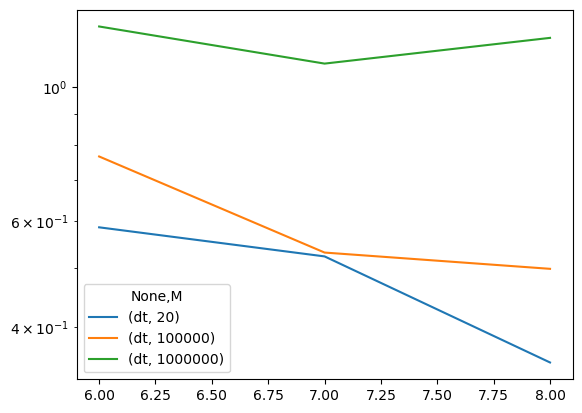

In [55]:
def plot_sim_times(sim):
    
    try:
        dfux = (sim.df_sim[['i', 'dt', 'N', 'M']].sort_values(['N', 'i', 'M']).
                    groupby(['N', 'i', 'M']).mean().unstack('M'))
        dfur = dfux.reset_index()
        display(dfur)
        #print(dfur.columns)
        b = (dfur[('N', '')] == (3000 if RUN_TYPE == 'workstation' else 1000))
        df1000 = dfur[b]
        del df1000[('N',)]
        del df1000[('i',)]
        #print(b)
        #print(df1000)
        df1000.plot(logy=True)
    except:
        print("plot_sim_times failed!")
        
plot_sim_times(sim1)

## Result 2: exchange trading

1. Model can now handle zero exchange trading and zero stabilizing orders; does not crash.
2. Baseline parameters with 500 assets and 100,000 orders.  
3. Baseline exch_phpl_frac = 1.00, exch_epsilon = 1.00e-6, stab_max_qv = 0.10.


In [56]:
@ftimer()
@fthrds()
def simulate2():
    
    sim = Simulations(name_prefix="sim2")

    nreps = 51 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3

    #sim.dd_difficulty['low'] = {'N' : 50, 'M' : 1000}

    #sim.dd_difficulty['base_no_stab'] = {'stab_max_qv' : 0.00}
    
    #difficulty = ['base'] if RUN_TYPE == 'workstation' else ['base'] if RUN_TYPE == 'laptop' else ['base']

    difficulty = ['base_no_stab'] 

    #sim.dvd_change_few['ch2'] = [{'exch_epsilon' : eps} for eps in [
    #    1.0e-99, 1.00e-12, 1.00e-8, 1.00e-6, 1.00e-4, 1.00e-0, 1.00e4, 1.00e8, 1.00e12]]

    sim.dvd_change_few['ch2test'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl} 
        for eps in [1.00e-5, 1.00e-4, 1.00e-3] 
        for phpl in [1.00, 10.00, 100.00]]

    sim.dvd_change_few['ch2DM'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl} 
        for eps in [0.00, 1.0e-99, 1.00e-5, 1.00e-4, 1.00e-3, 1.00e-2, 1.00e-1, 1.00e-0, 1.00e+1, 1.00e4, 1.00e8]
        for phpl in [1.00, 10.00, 100.00]]

    sim.dvd_change_few['ch2PK'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl} 
        for eps in [0.00, 1.0e-99, 1.00e-5, 1.00e-4, 1.00e-3, 1.00e-2, 1.00e-1, 1.00e-0, 1.00e+1, 1.00e4, 1.00e8]
        for phpl in [1.00, 10.00, 100.00]]

    change_few = ['ch2DM'] if RUN_TYPE == 'workstation' else ['ch2PK'] if RUN_TYPE == 'laptop' else ['ch2test'] 

    change_many = ['none']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim2 = simulate2()



nreps =  3
difficulty =  ['base_no_stab']
change_few =  ['ch2test']
change_many =  ['none']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.99s/it]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/sim2_RZtest_2023-1204-2043.csv
nthreads =  2 , user_api =  blas
ftimer =  24.128093957901  sec


In [57]:
@ftimer()
def make_table2(sim):

    vns_drop = ['ch_few', 'ch_many', 'ch_vn0', 'ch_value0']
    
    vns_sort = ['difficulty', 'exch_epsilon']

    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl2", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg2 = make_table2(sim2)


,difficulty,exch_phpl_frac,exch_epsilon,dt_med,dt_std,niter_med,niter_max,unclpM,exchpM,stabpM,p,p_std,count,num_exch_full,num_stab_full,num_stab_active,bchofail,bmaxiter,niter,unclpM_max,n_bad_p,nchreg,dvM,condnum_med,dt_max,dt_min,dt,exchpM_max,exchpM_med,exchpM_min,exchpM_std
0,base_no_stab,1.0000,1.00e-05,0.4280,0.2576,33,34,4.3e-06,5.0e-03,0.0e+00,99.8076,3.52e+04,3,17.6667,0.00e+00,0.00e+00,0.00e+00,0.00e+00,33.0000,1.17e-05,17.6667,0.00e+00,84.8286,4.78e+15,0.8558,0.3933,0.5590,5.36e-03,4.89e-03,4.86e-03,2.81e-04
3,base_no_stab,10.0000,1.00e-05,0.3840,0.0593,33,33,1.1e-06,2.2e-02,0.0e+00,99.8121,1.21e+04,3,10.6667,0.00e+00,0.00e+00,0.00e+00,0.00e+00,32.6667,1.45e-06,22.6667,0.00e+00,84.7808,1.13e+15,0.4804,0.3723,0.4122,0.0243,0.0206,0.0199,2.36e-03
6,base_no_stab,100.0000,1.00e-05,0.4982,0.0784,31,32,8.7e-07,6.3e-02,0.0e+00,99.8079,5.83e+03,3,1.3333,0.00e+00,0.00e+00,0.00e+00,0.00e+00,31.0000,9.58e-07,20.3333,0.00e+00,84.8009,1.38e+13,0.5628,0.4068,0.4893,0.0816,0.0641,0.0426,0.0195
1,base_no_stab,1.0000,1.00e-04,0.5071,0.1056,32,33,2.1e-05,4.8e-02,0.0e+00,99.8121,1.21e+04,3,13.0000,0.00e+00,0.00e+00,0.00e+00,0.00e+00,32.0000,5.77e-05,13.0000,0.00e+00,84.7819,1.12e+15,0.6453,0.4379,0.5301,0.0520,0.0465,0.0462,3.25e-03
4,base_no_stab,10.0000,1.00e-04,0.6102,0.0663,31,31,7.6e-07,1.0e-01,0.0e+00,99.8069,5.70e+03,3,2.6667,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.6667,8.92e-07,12.6667,0.00e+00,84.7950,3.77e+12,0.6754,0.5429,0.6095,0.1167,0.0967,0.0910,0.0135
7,base_no_stab,100.0000,1.00e-04,0.6325,0.1783,31,31,3.5e-06,1.5e-01,0.0e+00,99.8124,200.6865,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.3333,9.50e-06,15.3333,0.00e+00,84.7485,6.22e+11,0.7333,0.3866,0.5842,0.2080,0.1615,0.0928,0.0579
2,base_no_stab,1.0000,1.00e-03,0.5094,0.1094,31,31,1.0e-05,3.9e-01,0.0e+00,99.8069,5.71e+03,3,4.0000,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.6667,2.95e-05,4.0000,0.00e+00,84.7956,3.40e+12,0.6507,0.4354,0.5318,0.4065,0.3864,0.3813,0.0133
5,base_no_stab,10.0000,1.00e-03,0.6345,0.1311,31,31,7.9e-07,4.7e-01,0.0e+00,99.8136,27.8077,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,30.3333,1.42e-06,3.6667,0.00e+00,84.7421,6.25e+10,0.6527,0.4171,0.5681,0.5159,0.4956,0.3850,0.0705
8,base_no_stab,100.0000,1.00e-03,0.3964,0.1557,31,32,7.9e-07,4.7e-01,0.0e+00,99.8136,27.8077,3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,31.0000,1.32e-06,3.6667,0.00e+00,84.7421,6.25e+10,0.6442,0.3570,0.4659,0.5159,0.4956,0.3850,0.0705


ftimer =  0.013803482055664062  sec


## Result 3: stabilizing order
	
1. Add stabilizing order and compare the stdev of prices with and without 
2. With the baseline parameters including 500 assets and 100,000 orders 
3. No stabilizing order everywhere else


In [58]:
@ftimer()
@fthrds()
def simulate3():
    
    sim = Simulations(name_prefix="sim3")

    nreps = 51 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3

    #sim.dd_difficulty['stab'] = {'stab_max_qv' : 20.00, 'stab_ph_frac' : 0.70, 'stab_pl_frac' : 0.20}

    difficulty = ['base'] 

    sim.dvd_change_few['ch2DM'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl, 'stab_max_qv' : stqv} 
        for eps in [0.00, 1.0e-25, 1.00e-4, 1.00e-3, 1.00e-2, 1.00e-1, 1.00e-0, 1.00e4]
        for phpl in [1.00, 10.00, 100.00] for stqv in [0.00, 0.10, 1.00, 10.00]]

    sim.dvd_change_few['ch2PK'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl, 'stab_max_qv' : stqv} 
        for eps in [0.00, 1.00e-4, 1.00e-3, 1.00e-2, 1.00e-1, 1.00e0, 1.00e4]
        for phpl in [1.00, 10.00] for stqv in [0.00, 1.00, 1.00e+1]]

    sim.dvd_change_few['ch2test'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : phpl, 'stab_max_qv' : stqv} 
        for eps in [1.00e-4, 1.00e-3]
        for phpl in [10.00, 100.00] for stqv in [1.00, 10.00]] 

    change_few = ['ch2DM'] if RUN_TYPE == 'workstation' else ['ch2PK'] if RUN_TYPE == 'laptop' else ['ch2test']

    #sim.dvd_change_many['test_many'] = [{'exch_max_qv' : 100.00}, {'fracMA' : 0.99}]
    change_many = ['none']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim3 = simulate3()



nreps =  3
difficulty =  ['base']
change_few =  ['ch2test']
change_many =  ['none']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.76s/it]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/sim3_RZtest_2023-1204-2044.csv
nthreads =  2 , user_api =  blas
ftimer =  20.409128427505493  sec


In [59]:
@ftimer()
def make_table3(sim):

    vns_drop = ['ch_few', 'ch_many', 'ch_vn0', 'ch_value0']

    vns_sort = ['difficulty', 'p_std']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl3", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg3 = make_table3(sim3)


,difficulty,exch_phpl_frac,exch_epsilon,stab_max_qv,dt_med,dt_std,niter_med,niter_max,unclpM,exchpM,stabpM,p,p_std,count,num_exch_full,num_stab_full,num_stab_active,bchofail,bmaxiter,niter,unclpM_max,n_bad_p,nchreg,dvM,condnum_med,dt_max,dt_min,dt,exchpM_max,exchpM_med,exchpM_min,exchpM_std
7,base,100.0000,1.00e-03,10.0000,0.4629,0.1289,28,30,6.8e-07,3.4e-01,8.3e+00,99.8108,9.1123,3,0.00e+00,0.00e+00,18.6667,0.00e+00,0.00e+00,28.3333,1.08e-06,0.00e+00,0.00e+00,84.7445,6.23e+10,0.6163,0.3601,0.4798,0.3708,0.3347,0.3278,0.0231
3,base,10.0000,1.00e-03,10.0000,0.4614,0.1015,28,31,6.0e-07,3.4e-01,8.3e+00,99.8108,9.1123,3,0.00e+00,0.00e+00,18.6667,0.00e+00,0.00e+00,28.6667,7.35e-07,0.00e+00,0.00e+00,84.7445,6.23e+10,0.5836,0.3820,0.4757,0.3708,0.3347,0.3278,0.0231
1,base,10.0000,1.00e-04,10.0000,0.5993,0.1377,29,31,6.4e-07,3.5e-02,8.3e+00,99.8108,9.3342,3,0.00e+00,0.00e+00,21.0000,0.00e+00,0.00e+00,29.6667,7.00e-07,0.00e+00,0.00e+00,84.7446,6.23e+11,0.6511,0.3910,0.5471,0.0374,0.0341,0.0336,2.08e-03
5,base,100.0000,1.00e-04,10.0000,0.4651,0.0921,29,32,5.3e-07,3.5e-02,8.3e+00,99.8108,9.3342,3,0.00e+00,0.00e+00,21.0000,0.00e+00,0.00e+00,29.6667,6.30e-07,0.00e+00,0.00e+00,84.7446,6.23e+11,0.4828,0.3152,0.4210,0.0374,0.0341,0.0336,2.08e-03
6,base,100.0000,1.00e-03,1.0000,0.5029,0.1162,29,31,5.8e-07,3.5e-01,1.6e+00,99.8072,10.3944,3,0.00e+00,0.6667,17.0000,0.00e+00,0.00e+00,29.3333,8.08e-07,0.3333,0.00e+00,84.7451,6.22e+10,0.6242,0.3919,0.5063,0.3835,0.3353,0.3309,0.0292
2,base,10.0000,1.00e-03,1.0000,0.4694,0.0109,30,32,6.3e-07,3.5e-01,1.6e+00,99.8072,10.3944,3,0.00e+00,0.6667,17.0000,0.00e+00,0.00e+00,30.3333,9.67e-07,0.3333,0.00e+00,84.7451,6.22e+10,0.4704,0.4510,0.4636,0.3835,0.3353,0.3309,0.0292
0,base,10.0000,1.00e-04,1.0000,0.3564,0.0671,31,31,6.0e-07,3.6e-02,1.6e+00,99.8083,10.6869,3,0.00e+00,0.6667,20.0000,0.00e+00,0.00e+00,30.6667,7.90e-07,0.3333,0.00e+00,84.7450,6.22e+11,0.4720,0.3554,0.3946,0.0388,0.0344,0.0339,2.70e-03
4,base,100.0000,1.00e-04,1.0000,0.6803,0.1964,31,32,5.6e-07,3.6e-02,1.6e+00,99.8083,10.6869,3,0.00e+00,0.6667,20.0000,0.00e+00,0.00e+00,31.0000,6.54e-07,0.3333,0.00e+00,84.7450,6.22e+11,0.7232,0.3636,0.5890,0.0388,0.0344,0.0339,2.70e-03


ftimer =  0.01909923553466797  sec


## Result 4: number of orders and number of assets (no stabilizing order) 

1. Flip the left and right of the pictures 
2. Find out why there is a jump in the number of orders. (Unknown at this point!) 
3. All with the baseline parameters 
4. For the number of orders: increase the domain to 1e7 and add grid lines for 1e2, 1e4, 1e6, and 1e7 (Grid lines are hard to control.  Making the figure slightly larger increases the number of grid lines.) 


In [60]:
@ftimer()
@fthrds()
def simulate4n():
    
    sim = Simulations(name_prefix="sim4N")

    nreps = 1

    nobs = 500 if RUN_TYPE == 'workstation' else 500 if RUN_TYPE == 'laptop' else 20
    Nmin = 10
    Nmax = 10000 if RUN_TYPE == 'workstation' else 5000 if RUN_TYPE == 'laptop' else 1000
    
    difficulty = ['base'] 

    sim.dvd_change_few['figN'] = reversed([{'N' : int(Nmin * (Nmax/ Nmin)**(x / (nobs-1))) } for x in range(nobs) ])

    print(sim.dvd_change_few['figN'])
    
    change_few = ['figN']
    
    change_many = ['none']

    df = sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim4n = simulate4n()



nreps =  1
difficulty =  ['base']
change_few =  ['figN']
change_many =  ['none']


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.52s/it]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/sim4N_RZtest_2023-1204-2044.csv
nthreads =  2 , user_api =  blas
ftimer =  14.609869241714478  sec


In [61]:
@ftimer()
def make_table4n(sim):

    #vns_drop = ['ch_few', 'ch_many', 'ch_vn0', 'ch_value0']
    
    #vns_sort = ['difficulty', 'N']
    
    #dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl4N", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    dfg = sim.df_sim

    #column names for sim.df_sim:
    #dt, niter, bmaxiter, bchofail, num_cholesky_regularizations, rxnorm, rynorm, rznorm, nubar, pmean_pct, pstd_pct, 
    #n_bad_p, num_exch_full, num_stab_full, num_stab_active, cond_num, nseed, i, difficulty, 
    #ch_few, ch_many, num_changes, ch_vn0, ch_value0, ch_vn1, ch_value1, 
    #norm, unclpM, exchpM, stabpM, pairpM, dvM, dollar_volume, exchange_dollar_volume, single_asset_dollar_volume, 
    #pairs_trade_dollar_volume, uncleared_dollar_volume, uncleared_share, exchange_share, stabilizing_share, 
    #single_asset_share, pairs_trade_share, net_dollar_volume_vec, N, M, exch_liq_model, 
    #exch_epsilon, exch_phpl_frac, stab_max_qv, stab_ph_frac, stab_pl_frac, fracMA, subfracMX, num_size_indexes, 
    #num_industry_indexes, market_index_share, size_index_subshare, ew_mkt_index_subshare, 
    #ew_size_index_subsubshare, ew_industry_index_subsubshare, ew_size_index_alpha, 
    #std_num_orders_asset, std_order_size, dv_single_asset_orders, std_limit_price, limit_bias, 
    #avg_ph_minus_pl_bp, std_ph_minus_pl, index_prices, mean_asset_price, std_asset_price, invariance_exponent, 
    #fraction_buy_orders_asset, fracMX, fracM2, MX, M2, MA, M0, M0s, M1, Mall, NX, NR, ew_mkt_index_share, 
    #vw_mkt_index_share, industry_index_subshare, ew_size_index_share, vw_size_index_share, 
    #ew_industry_index_share, vw_industry_index_share, 
    #maxiter, dtype, device, xtol, ytol, ztol, stol, eta, sigma_exponent, sigma_fac, afac, gamma, one_fac, 
    #max_alpha, alpha_fac, alpha_trunc_factor, regeps0, regeps2, regepsfactor, 
    #print_time, print_iteration_results, print_mkt_results, 
    
    vns = ['difficulty', 'N', 'M', 'dt', 'niter', 'pmean_pct', 'pstd_pct', 
           'unclpM', 'exchpM', 'stabpM', 'pairpM', 'dvM', 'cond_num']
    
    display(dfg[vns])
    
    return dfg

dfg4n = make_table4n(sim4n)


,difficulty,N,M,dt,niter,pmean_pct,pstd_pct,unclpM,exchpM,stabpM,pairpM,dvM,cond_num
0,base,1000,100000,5.50e-01,34,9.91e+01,1.32e+01,1.06e-06,6.10e+00,0.00e+00,1.38e+05,1.12e+02,8.48e+09
1,base,784,100000,4.76e-01,32,9.95e+01,1.40e+01,5.70e-07,5.10e+00,0.00e+00,1.37e+05,1.05e+02,3.63e+09
2,base,615,100000,7.53e-01,32,9.92e+01,1.30e+01,4.54e-07,4.29e+00,0.00e+00,1.47e+05,9.16e+01,1.60e+10
3,base,483,100000,6.97e-01,32,9.97e+01,8.66e+00,6.96e-07,2.97e+00,0.00e+00,1.49e+05,8.45e+01,7.81e+09
4,base,379,100000,5.01e-01,31,1.00e+02,2.09e+01,1.47e-06,3.41e+00,0.00e+00,1.48e+05,7.89e+01,5.36e+10
5,base,297,100000,6.45e-01,30,9.98e+01,1.03e+01,8.65e-07,1.44e+00,0.00e+00,1.56e+05,9.61e+01,1.14e+10
6,base,233,100000,4.95e-01,28,1.00e+02,6.88e+00,7.24e-07,1.06e+00,0.00e+00,1.59e+05,8.82e+01,1.64e+10
7,base,183,100000,3.58e-01,28,9.95e+01,7.69e+00,6.99e-05,9.14e-01,0.00e+00,1.55e+05,8.62e+01,2.64e+06
8,base,143,100000,3.16e-01,28,9.89e+01,6.63e+00,7.18e-06,6.44e-01,0.00e+00,1.59e+05,7.74e+01,4.84e+07
9,base,112,100000,5.97e-01,29,9.97e+01,3.51e+00,3.15e-07,3.82e-01,0.00e+00,1.58e+05,7.29e+01,2.25e+06


ftimer =  0.009595870971679688  sec


In [62]:
@ftimer()
@fthrds()
def simulate4m():

    sim = Simulations(name_prefix="sim4M")

    nreps = 1

    nobs = 500 if RUN_TYPE == 'workstation' else 500 if RUN_TYPE == 'laptop' else 20
    Mmin = 100 if RUN_TYPE == 'test' else 100
    Mmax = 10**7 if RUN_TYPE == 'workstation' else 5 * 10**6 if RUN_TYPE == 'laptop' else 5 * 10**6
    
    difficulty = ['base'] 

    sim.dvd_change_few['figM'] = reversed([{'M' : int(Mmin * (Mmax/ Mmin)**(x / (nobs-1))) } for x in range(nobs) ])

    print(sim.dvd_change_few['figM'])
    
    change_few = ['figM']
    
    change_many = ['none']
    
    torch.cuda.empty_cache()
    
    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim4m = simulate4m()



nreps =  1
difficulty =  ['base']
change_few =  ['figM']
change_many =  ['none']


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.26s/it]

Simulation data save to  C:/Users/richa/Documents/energy_forward_market/outputs/csv/sim4M_RZtest_2023-1204-2044.csv
nthreads =  2 , user_api =  blas
ftimer =  32.42188882827759  sec


In [63]:
@ftimer()
def make_table4m(sim):

    #vns_drop = ['ch_few', 'ch_many', 'ch_vn0', 'ch_value0']
    
    #vns_sort = ['difficulty', 'M']

    #dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl4M", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    
    dfg = sim.df_sim

    #column names for sim.df_sim:
    #dt, niter, bmaxiter, bchofail, num_cholesky_regularizations, rxnorm, rynorm, rznorm, nubar, pmean_pct, pstd_pct, 
    #n_bad_p, num_exch_full, num_stab_full, num_stab_active, cond_num, nseed, i, difficulty, 
    #ch_few, ch_many, num_changes, ch_vn0, ch_value0, ch_vn1, ch_value1, 
    #norm, unclpM, exchpM, stabpM, pairpM, dvM, dollar_volume, exchange_dollar_volume, single_asset_dollar_volume, 
    #pairs_trade_dollar_volume, uncleared_dollar_volume, uncleared_share, exchange_share, stabilizing_share, 
    #single_asset_share, pairs_trade_share, net_dollar_volume_vec, N, M, exch_liq_model, 
    #exch_epsilon, exch_phpl_frac, stab_max_qv, stab_ph_frac, stab_pl_frac, fracMA, subfracMX, num_size_indexes, 
    #num_industry_indexes, market_index_share, size_index_subshare, ew_mkt_index_subshare, 
    #ew_size_index_subsubshare, ew_industry_index_subsubshare, ew_size_index_alpha, 
    #std_num_orders_asset, std_order_size, dv_single_asset_orders, std_limit_price, limit_bias, 
    #avg_ph_minus_pl_bp, std_ph_minus_pl, index_prices, mean_asset_price, std_asset_price, invariance_exponent, 
    #fraction_buy_orders_asset, fracMX, fracM2, MX, M2, MA, M0, M0s, M1, Mall, NX, NR, ew_mkt_index_share, 
    #vw_mkt_index_share, industry_index_subshare, ew_size_index_share, vw_size_index_share, 
    #ew_industry_index_share, vw_industry_index_share, 
    #maxiter, dtype, device, xtol, ytol, ztol, stol, eta, sigma_exponent, sigma_fac, afac, gamma, one_fac, 
    #max_alpha, alpha_fac, alpha_trunc_factor, regeps0, regeps2, regepsfactor, 
    #print_time, print_iteration_results, print_mkt_results, 
    
    vns = ['difficulty', 'N', 'M', 'dt', 'niter', 'pmean_pct', 'pstd_pct', 
           'unclpM', 'exchpM', 'stabpM', 'pairpM', 'dvM', 'cond_num']
    
    display(dfg[vns])

    
    return dfg

dfg4m = make_table4m(sim4m)


,difficulty,N,M,dt,niter,pmean_pct,pstd_pct,unclpM,exchpM,stabpM,pairpM,dvM,cond_num
0,base,500,5000000,3.08e+00,32,9.95e+01,2.04e+00,9.20e-05,7.63e-01,0.00e+00,1.47e+05,8.64e+01,7.50e+08
1,base,500,2829148,1.92e+00,33,9.94e+01,2.31e+00,5.54e-06,8.68e-01,0.00e+00,1.46e+05,8.68e+01,1.17e+08
2,base,500,1600816,1.29e+00,32,9.92e+01,4.37e+00,5.19e-05,1.23e+00,0.00e+00,1.47e+05,8.63e+01,1.96e+09
3,base,500,905789,6.56e-01,31,9.94e+01,5.98e+00,7.10e-07,1.56e+00,0.00e+00,1.45e+05,8.66e+01,1.29e+09
4,base,500,512522,7.21e-01,33,9.97e+01,6.98e+00,7.08e-08,1.86e+00,0.00e+00,1.47e+05,8.62e+01,4.24e+08
5,base,500,290000,4.05e-01,31,9.97e+01,8.63e+00,1.33e-04,2.28e+00,0.00e+00,1.46e+05,8.67e+01,3.22e+11
6,base,500,164090,3.20e-01,29,9.89e+01,8.28e+00,4.32e-07,2.76e+00,0.00e+00,1.48e+05,8.52e+01,4.17e+09
7,base,500,92847,3.67e-01,34,9.97e+01,1.26e+01,4.73e-06,3.57e+00,0.00e+00,1.45e+05,8.67e+01,4.20e+09
8,base,500,52535,3.39e-01,31,9.96e+01,1.63e+01,3.30e-06,4.63e+00,0.00e+00,1.46e+05,8.55e+01,2.71e+10
9,base,500,29726,3.40e-01,30,1.00e+02,4.08e+01,2.12e-05,9.51e+00,0.00e+00,1.60e+05,8.18e+01,1.79e+10


ftimer =  0.02024102210998535  sec


In [64]:
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})  #tex file: \usepackage{mathpazo}.
matplotlib.rc('font',**{'family':'serif','serif':['Times']}) #tex file: \usepackage{mathptmx}
#matplotlib.rc('font',**{'family':'serif','serif':['fourier']}) #Does not work since fourier not allowed. Computer modern.
#matplotlib.rc('font',**{'family':'serif','serif':['Charter']})  #tex file: \usepackage{charter}.
plt.rcParams['font.size'] = 12  # match base font in tex file
#matplotlib.rc('axes.titlesize', 'large')
plt.rcParams['axes.titlesize'] = 'medium'
#plt.rcParams['axes.labelsize'] = 10
matplotlib.rc('text', usetex=True)  #comment out to not use latex fonts

#matplotlib.rcParams.keys()  #list of settings which can be changed

In [65]:

@ftimer()
@fthrds()
def plot_simulation_results_for_assets_and_orders(dfn, dfm): 
    
    #fig1 = plt.figure(figsize=(8.0, 6.0))
    fig1 = plt.figure(figsize=(7.0, 3.5))
    (ax1, ax2) = fig1.subplots(1,2)
    #(ax1, ax2) = fig1.subplots(2,1)

    #fig1.suptitle("Computation Times (sec)")
    #fig1.suptitle("Computation Times (sec)")
    
    ylim =  (0.02, 120.00) if RUN_TYPE=='workstation' else (0.02, 200.00) if RUN_TYPE=='laptop' else (0.01, 200.0)
    
    ax1.set_xlabel("Number of orders \n (Number of assets = 500)")
    #ax1.set_xlabel("Number of assets $N$\n$M=$" + str(int(dfn.loc[0, 'M'])) + " orders assumed")
    ax1.set_ylabel("Computation time (sec)")

    ax1.scatter(dfm['M'], dfm['dt'], c='b', s = 5.00)

    #ax1.legend(loc='best')
    #ax1.set_xscale('linear')
    
    ax1.set_xticks([10**i for i in [1, 2, 3, 4, 5, 6, 7]])
    ax1.set_yticks([10**i for i in [-1, 0, 1]])
    
    ax1.set(ylim = ylim)
    ax1.set(xlim = (2000, 1.2 * 10**7))
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    #ax1.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=3))    

    ax1.grid(visible=True, color='gray', linestyle='dashed', which='major')
    #ax1.grid(visible=True, color='gray', linestyle='dashed', which='both')
    #ax1.grid(b=True, which='minor', color='orange', linestyle=':')    
    
    #ax2.set_title("Number of iterations")
    ax2.set_xlabel("Number of assets\n(Number of orders = 100,000)")
    ax2.set_ylabel("Computation time (sec)")
    #ax2.scatter(dfm['MA'] + dfm['MX'] + dfm['M2'], dfm['dt'], c = 'b', s = 5.00)
    ax2.scatter(dfn['N'], dfn['dt'], c = 'b', s = 5.00)
    
    ax2.set_xticks([10**i for i in [1, 2, 3, 4, 5, 6]])
    ax2.set_yticks([10**i for i in [-1, 0, 1]])
    
    ax2.set(ylim=ylim)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    ax2.grid(visible=True, color='gray', linestyle='dashed', which='major')
    #ax2.grid(visible=True, color='gray', linestyle='dashed', which='both')

    plt.tight_layout()
    
    plt.show()

    B_SAVE_RESULTS = True
    if B_SAVE_RESULTS == True:
        #path = "C:/Users/akyle/ask/code/flow-trading-figures/"
        ts = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
        fp = LATEX_PATH + "dt_vs_n_m_" + ts + "_" + RUN_TYPE + ".pdf"
        fig1.savefig(fp)
        print("Figure saved to ", fp)
        
#try:
#    dfN_saved = pd.read_csv("C:/Users/akyle/Downloads/sim4N_DMworkstation_2022-0126-0202.csv")
#    dfM_saved = pd.read_csv("C:/Users/akyle/Downloads/sim4M_DMworkstation_2022-0126-0212.csv")
#    plot_simulation_results_for_assets_and_orders(dfN_saved, dfM_saved)
#except:
#    pass

plot_simulation_results_for_assets_and_orders(dfg4n, dfg4m)



nthreads =  2 , user_api =  blas
ftimer =  0.11966180801391602  sec


RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x000001DDE6AE9F80> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x350 with 2 Axes>

In [ ]:
ph = 100.00
ph_minus_pl = 1.00e-2
p = ph - 0.50 * ph_minus_pl
q = 1.00
x = q * (ph - p) / ph_minus_pl

print("The following numbers are theoretically all equal to 0.50, but rounding error makes them inaccurate for small phminuspl:")
for ph_minus_pl in [10.00**(-n) for n in range(-1, 16, 1)]:
    print(ph_minus_pl, (ph - (ph - 0.50 * ph_minus_pl))  / ph_minus_pl)

    

## Result 5: robustness to the other parameters 

1. 500 assets and 100,000 orders (no stabilizing order) (PK: "No stabilizing orders" is implemented by having a very small q = 1.00e-99 for stabilizing orders.) 
2. Start with the baseline parameters and change one at a time + changing everything (in the table, please include the baseline)  (PK: Baseline is called 'none')
3. Also check why the standard deviation of limit prices became suddenly important: possibly due to stabilizing order (PK: Fixed a typo in the definition of the stabilizing orders.)


In [ ]:
@ftimer()
@fthrds()
def simulate5b():
    
    sim = Simulations(name_prefix="sim5b")

    nreps = 101 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 2
    
    difficulty = (['base'] if RUN_TYPE == 'workstation' 
                  else ['base'] if RUN_TYPE == 'laptop' else ['base'])

    #sim.dvd_change_few['ch2'] = [{'exch_epsilon' : eps, 'exch_phpl_frac' : 1.00} for eps in [
    #    1.0e-99, 1.00e-12, 1.00e-8, 1.00e-6, 1.00e-4, 1.00e-0, 1.00e4, 1.00e8]]

    change_few = ['none']

    change_many = ['none', 'high1by1', 'low1by1']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim5b = simulate5b()



In [ ]:
@ftimer()
@fthrds()
def make_table5b(sim):

    vns_drop = ['ch_few']
    
    vns_sort = ['difficulty', 'dt_med']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl5b", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg5b = make_table5b(sim5b)


The next table uses the hard case, adds stabilizing orders of 20X volume, changes parameters to 'low1by1' one by one, includes no parameter changes as 'none'.

In [ ]:
@ftimer()
@fthrds()
def simulate5h():
    
    sim = Simulations(name_prefix="sim5h")

    nreps = 51 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3
    
    difficulty = (['high'] if RUN_TYPE == 'workstation' 
                  else ['high'] if RUN_TYPE == 'laptop' else ['high'])

    #sim.dvd_change_few['ch2'] = [{'stab_max_qv' : 20.00}]

    change_few = ['none']

    change_many = ['none', 'low1by1']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim5h = simulate5h()



In [ ]:
@ftimer()
def make_table5h(sim):

    vns_drop = ['ch_few']
    
    vns_sort = ['difficulty', 'dt_med']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl5h", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg5h = make_table5h(sim5h)


In [ ]:
@ftimer()
@fthrds()
def simulate5e():
    
    sim = Simulations(name_prefix="sim5e")

    nreps = 51 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3

    difficulty = (['low'] if RUN_TYPE == 'workstation' 
                  else ['low'] if RUN_TYPE == 'laptop' else ['low'])

    #sim.dvd_change_few['ch2'] = [{'stab_max_qv' : 20.00}]

    change_few = ['none']

    #sim.dvd_change_many['test_many'] = [{'exch_max_qv' : 100.00}, {'fracMA' : 0.99}]

    change_many = ['none', 'high1by1']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim5e = simulate5e()



In [ ]:
@ftimer()
def make_table5e(sim):

    vns_drop = ['ch_few']
    
    vns_sort = ['difficulty', 'dt_med']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl5e", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg5e = make_table5e(sim5e)


In [ ]:
@ftimer()
@fthrds()
def simulate5hard():
    
    sim = Simulations(name_prefix="sim5hard")

    nreps = 101 if RUN_TYPE == 'workstation' else 21 if RUN_TYPE == 'laptop' else 3
    
    difficulty = (['hard'] if RUN_TYPE == 'workstation' 
                  else ['hard'] if RUN_TYPE == 'laptop' else ['hard'])

    #sim.dvd_change_few['ch2'] = [{'stab_max_qv' : 20.00}]

    change_few = ['none']

    change_many = ['none', 'base1by1']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim5hard = simulate5hard()



In [ ]:
@ftimer()
def make_table5hard(sim):

    vns_drop = ['ch_few']
    
    vns_sort = ['difficulty', 'dt_med']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl5hard", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg5hard = make_table5hard(sim5hard)


In [ ]:
@ftimer()
def make_table5all(sim):

    vns_drop = ['ch_few']
    
    #vns_sort = ['difficulty', 'niter', 'dt']
    vns_sort = ['niter', 'dt_med']
    
    dfg = pd.concat([dfg5b, dfg5h, dfg5e, dfg5hard])
    
    dfg = sim.display_and_save_table(dfg=dfg, tbl_name="tbl5all", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

# Does not matter which sim is argument of function since dfg is specified in function:
dfg5all = make_table5all(sim5b)


In [ ]:
Assumptions()

## Result 6: Inaccurate market clearing when $p_H - p_L$ is small 

Use baseline parameter except change $avg_ph_minus_pl_bp$.

In [ ]:
@ftimer()
@fthrds()
def simulate6():
    
    sim = Simulations(name_prefix="sim6")

    nreps = 101 if RUN_TYPE == 'workstation' else 51 if RUN_TYPE == 'laptop' else 11
    
    difficulty = (['base'] if RUN_TYPE == 'workstation' 
                  else ['base'] if RUN_TYPE == 'laptop' else ['base'])

    sim.dvd_change_few['phpl'] = [{'avg_ph_minus_pl_bp' : 10.00**n} for n in range(2, -6, -1)]

    change_few = ['phpl']

    #change_many = ['none', 'high1by1', 'low1by1']
    change_many = ['none']

    sim(nreps=nreps, difficulty=difficulty, change_few=change_few, change_many=change_many, nseed0=NSEED0,
            name_suffix=NAME_SUFFIX)

    return sim

sim6 = simulate6()



In [ ]:
@ftimer()
@fthrds()
def make_table6(sim):

    #vns_drop = ['ch_few']
    vns_drop = []
    
    vns_sort = ['ch_few']
    
    dfg = sim.display_and_save_table(dfg=None, tbl_name="tbl6", vns_keep=None, vns_drop=vns_drop, vns_sort=vns_sort)

    return dfg

dfg6 = make_table6(sim6)


In [ ]:
telapsed = time.time() - tstart
print("Execution time for entire notebook = ", telapsed, " sec")

# Energy Forward Market Simulation 
### Details
- 2021 only. 
- ERCOT only for net load, day ahead market prices, and load. 
- We only clear monthly products, for each load zone.

### Modeling (v1)
- Only ERCOT zone, so we use hub average prices
- 3 agents, Load Serving Entities (LSEs) are buyers, and generators are sellers. Financial arbitrageurs are also included.
- Get a forecast of net load (defined as load less wind and solar production) and day ahead prices for all load zones, for all periods. Using historical data, we add some white noise so that forecasts are not exact. 
- In v1, we only use 3 agents, each of different type

### Utility Functions

In [73]:
import os
#PTH = '/Users/richardz/Desktop/Projects/energy_forward_market/data'
PTH = 'C://Users//richa//Documents//energy_forward_market//data'
LOAD_FILE = 'load_2021.xlsx'
DAM_PRICES_FILE = 'dam_spp_2021.xlsx'
RENEW_FILE = 'wind_solar_2021.xlsx'

# get the historical load data for a specific zone
def get_load(zone): 
	pass

# get the average price of all hubs in ERCOT
def get_dam_prices(zone='HB_BUSAVG'): 
	months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
	df = pd.DataFrame()
	for month in months: 
		dam_prices = pd.read_excel(os.path.join(PTH, DAM_PRICES_FILE), sheet_name=month)
		dam_prices = dam_prices[dam_prices['Settlement Point'] == zone]
		df = pd.concat([df, dam_prices], axis=0)
		
	return df	

# get the wind and solar data
def get_wind_solar(): 
	wind_sheet = 'Wind Data'
	solar_sheet = 'Solar Data'
	wind_data = pd.read_excel(os.path.join(PTH, RENEW_FILE), sheet_name=wind_sheet)
	solar_data = pd.read_excel(os.path.join(PTH, RENEW_FILE), sheet_name=solar_sheet)
	return wind_data, solar_data


In [94]:
dam_prices = get_dam_prices()
dam_prices['Delivery Date'] = pd.to_datetime(dam_prices['Delivery Date'])
wind, solar = get_wind_solar()
wind.set_index('Date', inplace=True)
solar.set_index('Date', inplace=True)
net_load = wind[['ERCOT.LOAD', 'ERCOT.WIND.GEN']].join(solar[['ERCOT.PVGR.GEN']], on='Date', lsuffix='.wind', rsuffix='.solar')
net_load['net_load'] = net_load['ERCOT.LOAD'] - net_load['ERCOT.WIND.GEN'] - net_load['ERCOT.PVGR.GEN']

### Modeling agent preferences
We assume a "template" offer curve for each participant type, of which there are 3 distinct types (no hybrids). Each offer (demand) curve is parameterized by only scalar risk attitudes, and capital costs. Risk attitude and capital costs are related, and determine the slope and level of the offer curve. Additionally, each participant type differs in their general offering strategy. 

- Financial participants are agnostic between buying or selling, but require higher payment for taking larger positions. They aim to have a position of 0 target around their expected price. 
- Generators are natural sellers willing to sell slightly below their expected price, and can even buy if they have physical assets that allow them to do so (batteries, hydro)
- LSE are natural buyers, who offer at a premium to the other participants compared to their expected price, due to the extreme volatility of electricity prices.

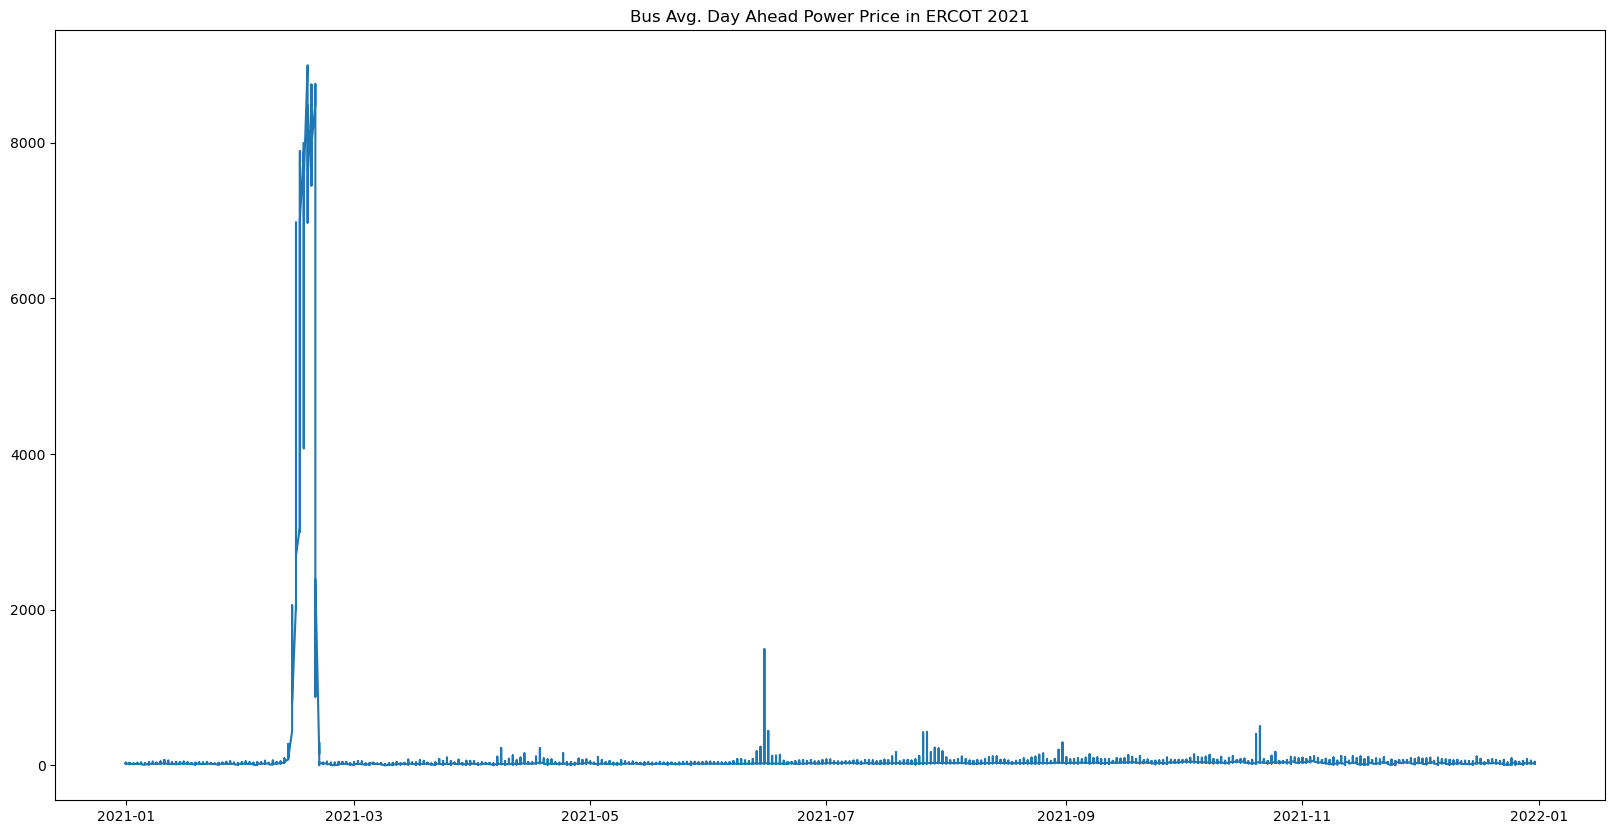

In [124]:
plt.figure(figsize=(20,10))
plt.plot(dam_prices['Delivery Date'], dam_prices['Settlement Point Price'])
plt.title('Bus Avg. Day Ahead Power Price in ERCOT 2021')
plt.show()

In total, each participant uses 4 flow orders, two for "high" absolute quantities and two for "low" absolute quantities. The notion of how high or low a quantity is determined by the "size" of the participant, and their risk attitude. 

Assumptions: 
- Each participant offers in a price range from $[0, 2*E(p)]$

In [302]:
class Participant(): 
    # risk_attitude: is a scalar in [0,1]. 1 is for a perfectly risk neutral participant. ~.9 for small generators
    # capital_costs: is a scalar in [.06, .12] that shifts the offer curve up or down. 
    def __init__(self, risk_attitude, capital_costs): 
        self.risk_attitude = risk_attitude
        self.capital_costs = capital_costs 

    # get_offer_points :return a set of four tuples that indicate (price, quantity) pairs that we use to construct the flow orders
    # this is based on the expected price that the participant anticipates from a forecast. 
    # the prices must be monotonically increasing
    # expected_price: the anticipated price of power in $/MWh
    # net_demand: the sum (demand - supply) for each participant. 
    def get_offer_points(self, expected_price, net_demand):
        pass

    # assume that offer points are a set of 4 tuples that specify (p_i, q_i) for price and quantity
    # assume that offer points are already sorted in decreasing order of price, increasing order of quantity (left to right on graph)
    # we only specify the p_H, p_L, q_i, q_i of the flow order
    def get_flow_orders(self, offer_points): 

        flow_orders = [] 
        # skip first offer, we essentially specify between the curve
        for i, p_i, q_i in enumerate(offer_points[1:]): 
            p_im1, q_im1 = offer_points[i-1]
            flow_orders.append(())

        return flow_orders

class Seller(Participant): 
    
    def get_offer_points(self, expected_price, net_demand): 
        pass

class Buyer(Participant): 
    
    def get_offer_points(self, expected_price, net_demand): 
        pass 

# The arbitrageur offers two points at the forecasted_net_load and -forecasted_net_load
class Arbitrageur(Participant): 
    
    def get_offer_points(self, expected_price, net_demand, forecasted_net_load): 
        discounted_expected_price = expected_price / (1 - self.capital_costs)

        # we assume that an arbitrageur has a relatively high risk attitude close to 1.
        # From their expected price, they are willing to buy large quantities far below expected prices, 
        # and sell large quantities far above expected prices
        # for now, just assume that within 1.5 - 2 multiples of the expected price, the arbitrageur sells with slope 1 in price. 
        
        p1 = 1.6 * discounted_expected_price
        p2 = 1.1 * self.risk_attitude * discounted_expected_price
        p3 = 0.9 * discounted_expected_price 
        p4 = 0.4 * self.risk_attitude * discounted_expected_price
        q1 = -1.3 * forecasted_net_load * self.risk_attitude + net_demand 
        q2 = -1 * forecasted_net_load * self.risk_attitude + net_demand 
        q3 = 1 * forecasted_net_load * self.risk_attitude + net_demand
        q4 = 1.3 * forecasted_net_load * self.risk_attitude + net_demand

        return [(p1, q1), (p2, q2), (p3, q3), (p4, q4)]

In [305]:
Arbitrageur(1, .06).get_offer_points(60, 0, 60)

[(102.1276595744681, -78.0),
 (70.21276595744682, -60),
 (57.4468085106383, 60),
 (25.531914893617024, 78.0)]

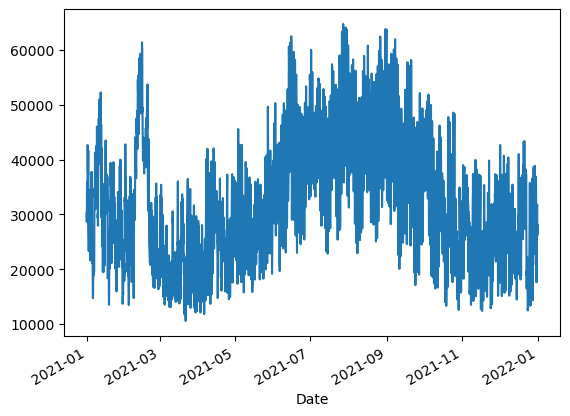

In [306]:
net_load['net_load'].plot()
plt.show()